# Project Overview

> This is an in-depth notebook which explores the Austin Housing Dataset through several different models. The notebook includes a thorough EDA and cleaning section, natural language processing on text descriptions, exploration of different models using different categorical methods (one-hot encoding vs target encoding) with extensive parameter tuning, an evaluation of the final model, and visualizations.

* **Business Objective**


* **Notebook Preparation**
    * Importing our Modules


* **Preprocessing**
    * EDA and Cleaning
        * Scaling target value for Time Series
        * Duplicates
        * Outlier Detection
        * Missing Data
        * Binary Data
        * Studying our Target Variable
    * Natural Language Processing
    * Create Holdout Set
    * Feature Engineering
    * Correlations and Multicollinearity
    * EDA & Process Train Set
        * Categoricals
        * Continuous
            * Standardize Continuous Data
            * Find Interactions
            * Adding Polynomial Features
        * NLP
    * Process Test Set
        * Categoricals
        * Continuous
        * NLP
    * Create Train/Test Final


* **Model Explorations**
    * Picking our Base Features
    * Linear Regressions
        * Basic LR with Top Features One-Hot Encoded
        * Basic LR with Top Features Target Encoded
        * LR with ALL model features
        * Linear Regression with various Feature Selection Methods
            * Permutation Importance
            * Forward-Backward Selector
            * RFECV
    * K-Nearest Neighbors
    * Support Vector Regression
    * Decision Tree Models
        * Decision Tree - One Hot Encoded
            * Random Forest Regressor
            * XGBoost
        * Decision Tree - Target Encoded
            * Random Forest Regressor
            * XGBoost



* **Regression Results and Model Selection**
    * Evaluate results of all attempted models and choose best model


* **Final Model**
    * Process and train final model on data
    * Saving model assets for later use
    * Evaluating final model stats


* Making Predictions with New Data
    * Making new predictions on one entry and imported csv


* Visualizations
    * Feature visualizations


> Analysis
* Statistical analysis and explanations

> Conclusions and Recommendations
* Answers to business questions

> Future Work

> Explanation of Attempts - Feature Engineering/Selection


# Objective

Build a model that accurately predicts house prices in Austin

# Notebook Preparation

In [1]:
# data processing tools
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from math import sqrt
import itertools
from collections import Counter

# model tools
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import neighbors
import xgboost as xgb

# NLP tools
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Visualization tools
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

# Preprocessing

In [2]:
# load and look at our austin housing data
df = pd.read_csv('austinHousingData.csv')
df.head()

zpid          city          streetAddress  zipcode  \
0   111373431  pflugerville   14424 Lake Victor Dr    78660   
1   120900430  pflugerville     1104 Strickling Dr    78660   
2  2084491383  pflugerville    1408 Fort Dessau Rd    78660   
3   120901374  pflugerville     1025 Strickling Dr    78660   
4    60134862  pflugerville  15005 Donna Jane Loop    78660   

                                         description   latitude  longitude  \
0  14424 Lake Victor Dr, Pflugerville, TX 78660 i...  30.430632 -97.663078   
1  Absolutely GORGEOUS 4 Bedroom home with 2 full...  30.432673 -97.661697   
2  Under construction - estimated completion in A...  30.409748 -97.639771   
3  Absolutely darling one story home in charming ...  30.432112 -97.661659   
4  Brimming with appeal & warm livability! Sleek ...  30.437368 -97.656860   

   propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
0             1.98             2            True        True       True   
1             1.98             2            True        True       True   
2             1.98             0            True        True      False   
3             1.98             2            True        True       True   
4             1.98             0            True        True      False   

   hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
0        True   False    False  Single Family              2       2012   
1        True   False    False  Single Family              2       2013   
2        True   False    False  Single Family              0       2018   
3        True   False    False  Single Family              2       2013   
4        True   False    False  Single Family              0       2002   

   latestPrice  numPriceChanges latest_saledate  latest_salemonth  \
0     305000.0                5      2019-09-02                 9   
1     295000.0                1      2020-10-13                10   
2     256125.0                1      2019-07-31                 7   
3     240000.0                4      2018-08-08                 8   
4     239900.0                3      2018-10-31                10   

   latest_saleyear                                latestPriceSource  \
0             2019  Coldwell Banker United, Realtors - South Austin   
1             2020                                   Agent Provided   
2             2019                                   Agent Provided   
3             2018                                   Agent Provided   
4             2018                                   Agent Provided   

   numOfPhotos  numOfAccessibilityFeatures  numOfAppliances  \
0           39                           0                5   
1           29                           0                1   
2            2                           0                4   
3            9                           0                0   
4           27                           0                0   

   numOfParkingFeatures  numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
0                     2                           1                      3   
1                     2                           0                      0   
2                     1                           0                      1   
3                     2                           0                      0   
4                     1                           0                      0   

   numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
0                        0                    1                       0   
1                        0                    0                       0   
2                        0                    0                       0   
3                        0                    0                       0   
4                        0                    0                       0   

   lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  numOfElementarySchools  \
0       6011.0          2601.0         

In [3]:
df.dtypes

zpid                            int64
city                           object
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
homeType                       object
parkingSpaces                   int64
yearBuilt                       int64
latestPrice                   float64
numPriceChanges                 int64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
latestPriceSource              object
numOfPhotos                     int64
numOfAccessibilityFeatures      int64
numOfApplian

In [4]:
df.shape

(15171, 47)

## EDA and Cleaning

### Scale Time Series

We need to bring all of our home sale prices to the same time scale. It's easy to ignore that these homes were sold over the space of many years, but a year is a long time for real estate. We'll need to appreciate all sale prices into our most recent time series, using months.

In [5]:
df.rename(columns={'latestPrice':'price'}, inplace=True)

In [6]:
df['latest_saleyear'].unique()

# our data spans all the way from 2019 to 2021.

array([2019, 2020, 2018, 2021], dtype=int64)

In [7]:
df['latest_saledate'].min()
# earliest sale in january 2018

'2018-01-22'

In [8]:
df['latest_saledate'].max()
# last sale date january 2021

'2021-01-30'

We need to look to some external sources to get house price appreciation info. I went to the Austin Board of Realtors site to get this info from Texas A&M for the Austin metro area that this data covers  
https://www.recenter.tamu.edu/data/housing-activity/#!/activity/MSA/Austin-Round_Rock

* Jan 2018 median: 287000
* Jan 2019 median: 294000 +2.4%
* Jan 2020 median: 305000 +3.7%
* Jan 2021 median: 363830 +19.3% (!!!)

In [9]:
jan2018_to_2019 = .024/12
jan2019_to_2020 = .037/12
jan2020_to_2021 = .193/12

In [10]:
for i in range(1,13):
    df['time_series'] = df['latest_salemonth'].apply(lambda x: abs(x-13))

In [11]:
# adjust 2018 to 2019
df.loc[df['latest_saleyear']==2018, 'adj_price'] = df.loc[df['latest_saleyear']==2018].apply(lambda x: int( (x['price'])*(1+(jan2018_to_2019*x['time_series']))*(1+(jan2019_to_2020*x['time_series']))*(1+(jan2020_to_2021*x['time_series'])) ) , axis=1 )

# adjust 2019 to 2020                                                            
df.loc[df['latest_saleyear']==2019, 'adj_price'] = df.loc[df['latest_saleyear']==2019].apply(lambda x: int( (x['price'])*(1+(jan2019_to_2020*x['time_series']))*(1+(jan2020_to_2021*x['time_series'])) ) , axis=1)
                                                                                  
# adjust 2020 to 2021
df.loc[df['latest_saleyear']==2020, 'adj_price'] = df.loc[df['latest_saleyear']==2020].apply(lambda x: int( (x['price'])*(1+(jan2020_to_2021*x['time_series'])) ), axis=1)

#copy 2021 to self
df.loc[df['latest_saleyear']==2021, 'adj_price'] = df.loc[df['latest_saleyear']==2021].apply(lambda x: int(x['price']), axis=1)

In [12]:
# rename original price column and make adj_price our price column
df.rename(columns={'price' : 'orig_price', 'adj_price' : 'price'}, inplace=True)

# put price at the front of the data frame
df.set_index('price', inplace=True)
df.reset_index(inplace=True)

### Checking homeType

In [13]:
# what are the homeTypes?

df['homeType'].value_counts(normalize=True)

Single Family            0.938699
Condo                    0.030980
Townhouse                0.011469
Multiple Occupancy       0.006328
Vacant Land              0.005471
Residential              0.002439
Apartment                0.002439
Mobile / Manufactured    0.001121
MultiFamily              0.000659
Other                    0.000395
Name: homeType, dtype: float64

In [14]:
# Ultimately, with Single Family, Condo and Townhouse making up most of the data, we are going to remove all multi-family type listings
df = df.loc[((df['homeType'] == 'Single Family') | (df['homeType'] == 'Condo')) | (df['homeType'] == 'Townhouse')]

### Duplicate Data

In [15]:
# check for duplicate data

df[df.duplicated(subset=['latitude','longitude'], keep=False)].sort_values('latitude')

# no duplicate data

Empty DataFrame
Columns: [price, zpid, city, streetAddress, zipcode, description, latitude, longitude, propertyTaxRate, garageSpaces, hasAssociation, hasCooling, hasGarage, hasHeating, hasSpa, hasView, homeType, parkingSpaces, yearBuilt, orig_price, numPriceChanges, latest_saledate, latest_salemonth, latest_saleyear, latestPriceSource, numOfPhotos, numOfAccessibilityFeatures, numOfAppliances, numOfParkingFeatures, numOfPatioAndPorchFeatures, numOfSecurityFeatures, numOfWaterfrontFeatures, numOfWindowFeatures, numOfCommunityFeatures, lotSizeSqFt, livingAreaSqFt, numOfPrimarySchools, numOfElementarySchools, numOfMiddleSchools, numOfHighSchools, avgSchoolDistance, avgSchoolRating, avgSchoolSize, MedianStudentsPerTeacher, numOfBathrooms, numOfBedrooms, numOfStories, homeImage, time_series]
Index: []

### Outlier Detection

In [16]:
'''# plotting latitude and longitude as a visual scatter plot to look for location-based outliers

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");'''

'# plotting latitude and longitude as a visual scatter plot to look for location-based outliers\n\nplt.figure(figsize=(25,25))\n\nsns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");'

Using latitude and longitude, we make a visual map of the Austin area that lets us see any map outliers. There don't appear to be any zones that are well outside of the Austin area, except for just a few down in the lower SE area. So we might plan to cut off our latitude just above 30.1.

This visualization suggests that location is very important to home price. We'll check that out more directly.

In [17]:
# drop latitidue below 30.12 to remove the few outliers in the SE
df.drop(df[df['latitude']<30.12].index , inplace=True)

In [18]:
# looking for outliers in the percentiles

df.describe()

price          zpid       zipcode      latitude     longitude  \
count  1.488000e+04  1.488000e+04  14880.000000  14880.000000  14880.000000   
mean   5.710926e+05  1.043332e+08  78736.001075     30.291923    -97.778870   
std    4.933980e+05  3.171262e+08     18.879984      0.097245      0.084904   
min    6.094000e+03  2.858495e+07  78617.000000     30.127161    -98.022057   
25%    3.445055e+05  2.941134e+07  78727.000000     30.202993    -97.838747   
50%    4.538920e+05  2.949518e+07  78739.000000     30.285250    -97.769810   
75%    6.370388e+05  7.033871e+07  78749.000000     30.367340    -97.718283   
max    1.555613e+07  2.146313e+09  78759.000000     30.517174    -97.569504   

       propertyTaxRate  garageSpaces  parkingSpaces     yearBuilt  \
count     14880.000000  14880.000000   14880.000000  14880.000000   
mean          1.994194      1.228159       1.227554   1988.720228   
std           0.053290      1.342097       1.342224     21.504783   
min           1.980000      0.000000       0.000000   1905.000000   
25%           1.980000      0.000000       0.000000   1975.000000   
50%           1.980000      1.000000       1.000000   1993.000000   
75%           1.980000      2.000000       2.000000   2006.000000   
max           2.210000     22.000000      22.000000   2020.000000   

         orig_price  numPriceChanges  latest_salemonth  latest_saleyear  \
count  1.488000e+04     14880.000000      14880.000000     14880.000000   
mean   5.119011e+05         3.032997          6.722043      2019.077151   
std    4.413982e+05         2.481883          3.137916         0.813532   
min    5.500000e+03         1.000000          1.000000      2018.000000   
25%    3.090000e+05         1.000000          4.000000      2018.000000   
50%    4.050000e+05         2.000000          7.000000      2019.000000   
75%    5.750000e+05         4.000000          9.000000      2020.000000   
max    1.350000e+07        23.000000         12.000000      2021.000000   

        numOfPhotos  numOfAccessibilityFeatures  numOfAppliances  \
count  14880.000000                14880.000000     14880.000000   
mean      30.830645                    0.013239         3.490927   
std       21.187673                    0.181175         1.868605   
min        1.000000                    0.000000         0.000000   
25%       20.000000                    0.000000         2.000000   
50%       29.000000                    0.000000         3.000000   
75%       39.000000                    0.000000         4.000000   
max      179.000000                    8.000000        10.000000   

       numOfParkingFeatures  numOfPatioAndPorchFeatures  \
count          14880.000000                14880.000000   
mean               1.710081                    0.667608   
std                0.778832                    0.983225   
min                0.000000                    0.000000   
25%                1.000000                    0.000000   
50%                2.000000                    0.000000   
75%                2.000000                    1.000000   
max                6.000000                    8.000000   

       numOfSecurityFeatures  numOfWaterfrontFeatures  numOfWindowFeatures  \
count           14880.000000             14880.000000         14880.000000   
mean                0.472446                 0.002621             0.210753   
std                 0.828483                 0.059625             0.490729   
min                 0.000000                 0.000000             0.000000   
25%                 0.000000                 0.000000             0.000000   
50%                 0.000000                 0.000000             0.000000   
75%                 1.000000                 0.000000             0.000000   
max                 6.000000                 2.000000             4.000000   

       numOfCommunityFeatures   lotSizeSqFt  livingAreaSqFt  \
count            14880.000000  1.488000e+04    14880.000000   
mean                 0.011761 

We see potential outliers in price, lotSizeSqFt, livingAreaSqFt, and numOfBathrooms, numOfBedrooms, propertyTaxRate, garageSpaces, parkingSpaces.

In [19]:
'''# check how our histograms are looking
df.hist(figsize=(18,15), bins=100);
'''

'# check how our histograms are looking\ndf.hist(figsize=(18,15), bins=100);\n'

In [20]:
#check what is going on with the lotSizeSqFt outliers by sorting descending
df.sort_values('lotSizeSqFt', ascending=False).head(5)

# This top listing is legitimate. But we have a problem here where condo and townhouse listings are using the 
# size of the overall lot for their lot, and that isn't really accurate/representative
# We'll fix this in a little bit

price       zpid    city          streetAddress  zipcode  \
14654  1941912.0   58297775  austin         3200 W 35th St    78703   
9244    190324.0   62605548  austin  706 W 22nd St APT 306    78705   
11116   208577.0  145652991  austin       4319 Nitschke St    78723   
2340    680880.0  124837778  austin    4304 Front Range Ln    78732   
4635   1038012.0  202157510  austin     201 Charismatic Pl    78737   

                                             description   latitude  \
14654  Fabulous 4 Bed 4 Bath house on one of the larg...  30.314316   
9244   Leased for $1695 though 7/31/2020 - Unique gat...  30.285631   
11116  **Subject to City of Austin SMART Housing and ...  30.294910   
2340   4304 Front Range Ln, Austin, TX 78732 is a sin...  30.380476   
4635   201 Charismatic Pl, Austin, TX 78737 is a sing...  30.205276   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
14654 -97.768044             1.98             5           False        True   
9244  -97.745697             1.98             0            True        True   
11116 -97.698997             1.98             1            True        True   
2340  -97.881027             1.98             2            True        True   
4635  -98.011406             2.01             3            True        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
14654       True        True   False    False  Single Family              5   
9244       False        True   False    False          Condo              0   
11116       True        True   False    False      Townhouse              1   
2340        True        True   False     True  Single Family              2   
4635        True        True    True    False  Single Family              3   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
14654       1955   1650000.0                3      2020-02-20   
9244        1982    179900.0                7      2019-10-15   
11116       2016    187471.0                1      2020-06-29   
2340        2014    569000.0                1      2019-03-29   
4635        2015    999500.0                3      2019-11-08   

       latest_salemonth  latest_saleyear latestPriceSource  numOfPhotos  \
14654                 2             2020   Broker Provided           23   
9244                 10             2019    Agent Provided           16   
11116                 6             2020    Agent Provided           26   
2340                  3             2019    Agent Provided           33   
4635                 11             2019   Broker Provided            1   

       numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
14654                           0                8                     2   
9244                            0                4                     0   
11116                           0                3                     2   
2340                            0                4                     2   
4635                            0                4                     2   

       numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
14654                           2                      1   
9244                            0                      0   
11116                           0                      1   
2340                            0                      0   
4635                            0                      0   

       numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
14654                        0                    0                       0   
9244                         0                    0                       0   
11116                        0                    1                       0   
2340                         0                    0                       0   
4635                         0                    0                       0   

        lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \
14654  1.508

In [21]:
#check what is going on with the livingAreaSqFt outliers by sorting ascending
df.sort_values('livingAreaSqFt', ascending=True).head(5)

# just tiny houses I guess ?

price       zpid    city             streetAddress  zipcode  \
1170   960658.0   94641643  austin    3003 Brass Buttons Trl    78734   
3518   155233.0   29420819  austin           404 Primrose St    78753   
13314  185140.0   29330022  austin  1405 Hartford Rd APT 202    78703   
10118  527915.0   29385318  austin            2202 E 10th St    78702   
9213   164541.0  145658912  austin    1011 W 23rd St APT 103    78705   

                                             description   latitude  \
1170   Lake Austin Waterfront lot in Apache Shores! O...  30.381195   
3518   404 Primrose St, Austin, TX 78753 is a single ...  30.350330   
13314  Old West Austin Efficiency. Close to metro/UT ...  30.284014   
10118  Great opportunity to build on your lot in high...  30.264668   
9213   Very desirable location for UT students only 5...  30.287077   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
1170  -97.915985             1.98             0            True        True   
3518  -97.697739             1.98             0           False       False   
13314 -97.762421             1.98             0            True        True   
10118 -97.717590             1.98             2            True        True   
9213  -97.748085             1.98             1            True        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
1170       False        True   False    False  Single Family              0   
3518       False       False   False    False  Single Family              0   
13314      False        True   False    False          Condo              0   
10118       True        True   False     True          Condo              2   
9213        True        True   False     True          Condo              1   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
1170        2012    850000.0                4      2018-07-21   
3518        1945    139000.0                1      2019-07-02   
13314       1972    175000.0                1      2019-10-01   
10118       2019    499000.0                4      2019-10-22   
9213        1972    151500.0                5      2018-09-29   

       latest_salemonth  latest_saleyear latestPriceSource  numOfPhotos  \
1170                  7             2018    Agent Provided           49   
3518                  7             2019   Broker Provided            1   
13314                10             2019    Agent Provided           16   
10118                10             2019   Broker Provided           29   
9213                  9             2018    Agent Provided            1   

       numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
1170                            0                1                     0   
3518                            0                0                     0   
13314                           0                3                     0   
10118                           0                3                     2   
9213                            0                5                     2   

       numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
1170                            0                      0   
3518                            0                      0   
13314                           1                      1   
10118                           0                      1   
9213                            0                      0   

       numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
1170                         0                    0                       0   
3518                         0                    0                       0   
13314                        0                    1                       0   
10118                        0                    0                       0   
9213                         0                    0                       0   

       lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \


In [22]:
#check what is going on with the livingAreaSqFt outliers by sorting descending
df.sort_values('livingAreaSqFt', ascending=False).head(5)

price       zpid    city            streetAddress  zipcode  \
705     401434.0   70330356  austin            201 Marly Way    78733   
2557   1011842.0   64523076  austin           9704 Saugus Ln    78733   
2316  14076258.0  125904370  austin           12400 Cedar St    78732   
5328   3172530.0   29327226  austin     3509 Lost Creek Blvd    78735   
375    5484816.0   89551873  austin  14800 Flat Top Ranch Rd    78732   

                                            description   latitude  longitude  \
705   Level building site with great canyon views an...  30.323517 -97.861473   
2557  New Construction, EANES Schools, 4bed 3 bath, ...  30.345898 -97.859985   
2316  12400 Cedar Street - Villa Del Lago is a uniqu...  30.392859 -97.877609   
5328  *$6,762,377 is Tax Value - Set in exclusive Ba...  30.272158 -97.856033   
375   GRACIOUS LUXURY ON LAKE AUSTIN\r\nThis award-w...  30.368996 -97.912720   

      propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
705              1.98             0            True        True      False   
2557             1.98             0            True        True      False   
2316             1.98             5           False        True       True   
5328             1.98             7            True        True       True   
375              1.98             6            True        True       True   

      hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
705         True   False    False  Single Family              0       2012   
2557        True   False    False  Single Family              0       2018   
2316        True   False     True  Single Family              5       2016   
5328        True    True    False  Single Family              7       2003   
375         True    True     True  Single Family              6       2014   

      orig_price  numPriceChanges latest_saledate  latest_salemonth  \
705     385000.0                2      2018-11-12                11   
2557    829000.0                1      2018-03-08                 3   
2316  13500000.0                2      2018-11-28                11   
5328   2700000.0                4      2018-05-20                 5   
375    4950000.0                6      2018-08-17                 8   

      latest_saleyear latestPriceSource  numOfPhotos  \
705              2018    Agent Provided            1   
2557             2018    Agent Provided            1   
2316             2018    Agent Provided           13   
5328             2018    Agent Provided           39   
375              2018    Agent Provided           34   

      numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
705                            0                0                     1   
2557                           0                1                     1   
2316                           0                0                     2   
5328                           0                5                     3   
375                            0                3                     2   

      numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
705                            0                      0   
2557                           0                      0   
2316                           0                      0   
5328                           0                      0   
375                            0                      0   

      numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
705                         0                    0                       0   
2557                        0                    0                       0   
2316                        0                    0                       0   
5328                        0                    0                       0   
375                         0                    0                       0   

      lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \
705      109335.6        109292.0                 

In [23]:
# we're dropping the top two listings here. One is a lot, and the other is clearly mistaken.
df.drop(index=[705, 2557], inplace=True)

In [24]:
#check what is going on with the numOfBathrooms outliers by sorting descending
df.sort_values('numOfBathrooms', ascending=False).head(5)

price       zpid    city            streetAddress  zipcode  \
2838    780946.0  111972888  austin       4212 Far West Blvd    78731   
2316  14076258.0  125904370  austin           12400 Cedar St    78732   
184    4165941.0  124843021  austin        13115 Perryton Dr    78732   
5328   3172530.0   29327226  austin     3509 Lost Creek Blvd    78735   
375    5484816.0   89551873  austin  14800 Flat Top Ranch Rd    78732   

                                            description   latitude  longitude  \
2838  Well-maintained home in highly desirable North...  30.361406 -97.769707   
2316  12400 Cedar Street - Villa Del Lago is a uniqu...  30.392859 -97.877609   
184   This highly custom home sits on a well-establi...  30.338959 -97.926979   
5328  *$6,762,377 is Tax Value - Set in exclusive Ba...  30.272158 -97.856033   
375   GRACIOUS LUXURY ON LAKE AUSTIN\r\nThis award-w...  30.368996 -97.912720   

      propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
2838             1.98             2           False        True       True   
2316             1.98             5           False        True       True   
184              1.98             4            True        True       True   
5328             1.98             7            True        True       True   
375              1.98             6            True        True       True   

      hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
2838        True   False    False  Single Family              2       1967   
2316        True   False     True  Single Family              5       2016   
184         True    True     True  Single Family              4       2014   
5328        True    True    False  Single Family              7       2003   
375         True    True     True  Single Family              6       2014   

      orig_price  numPriceChanges latest_saledate  latest_salemonth  \
2838    745000.0                1      2020-10-20                10   
2316  13500000.0                2      2018-11-28                11   
184    4100000.0                3      2020-12-23                12   
5328   2700000.0                4      2018-05-20                 5   
375    4950000.0                6      2018-08-17                 8   

      latest_saleyear latestPriceSource  numOfPhotos  \
2838             2020    Agent Provided           46   
2316             2018    Agent Provided           13   
184              2020   Broker Provided          149   
5328             2018    Agent Provided           39   
375              2018    Agent Provided           34   

      numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
2838                           0                4                     2   
2316                           0                0                     2   
184                            0                8                     3   
5328                           0                5                     3   
375                            0                3                     2   

      numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
2838                           0                      0   
2316                           0                      0   
184                            0                      0   
5328                           0                      0   
375                            0                      0   

      numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
2838                        0                    0                       0   
2316                        0                    0                       0   
184                         0                    0                       0   
5328                        0                    0                       0   
375                         0                    0                       0   

      lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \
2838      10236.0          2137.0                 

In [25]:
# I'm going to say this top listing has 2.5 bathrooms not 27. That is clearly a typo.
df.loc[df.index==2838, 'numOfBathrooms'] = 2.5

In [26]:
#check what is going on with the numOfBathrooms outliers by sorting ascending
df.sort_values('numOfBathrooms', ascending=True).head(5)

price      zpid    city           streetAddress  zipcode  \
6252   1010014.0  29327134  austin       2005 Real Catorce    78746   
6646    493682.0  29503854  austin       8604 Oak Ledge Dr    78748   
1842    995762.0  94642666  austin    10640 Senna Hills Dr    78733   
2223    959366.0  58299964  austin  5138 Mansfield View Ct    78732   
12993   472902.0  58315415  austin   4712 Chesney Ridge Dr    78749   

                                             description   latitude  \
6252   2005 Real Catorce, Austin, TX 78746 is a singl...  30.269354   
6646   8604 Oak Ledge Dr, Austin, TX 78748 is a singl...  30.188589   
1842   Wow! Reduced! First time on the market! Move i...  30.312716   
2223   5138 Mansfield View Ct, Austin, TX 78732 is a ...  30.390335   
12993  This Austin two-story offers a fireplace, an o...  30.197540   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
6252  -97.818771             1.98             0            True        True   
6646  -97.823662             1.98             0           False        True   
1842  -97.900482             1.98             2            True        True   
2223  -97.882072             1.98             2            True        True   
12993 -97.862419             1.98             2            True        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
6252       False        True   False    False  Single Family              0   
6646       False        True   False    False  Single Family              0   
1842        True        True   False     True  Single Family              2   
2223        True        True   False     True  Single Family              2   
12993       True        True   False    False  Single Family              2   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
6252        1999    949000.0                4      2018-10-30   
6646        1971    450000.0                1      2019-08-07   
1842        2011    895000.0                5      2020-06-24   
2223        2000    850000.0                9      2020-05-03   
12993       2000    447000.0               12      2019-10-29   

       latest_salemonth  latest_saleyear latestPriceSource  numOfPhotos  \
6252                 10             2018    Agent Provided            1   
6646                  8             2019   Broker Provided            1   
1842                  6             2020    Agent Provided           35   
2223                  5             2020                              6   
12993                10             2019   Broker Provided            1   

       numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
6252                            0                4                     1   
6646                            0                4                     2   
1842                            0                3                     2   
2223                            0                3                     3   
12993                           0                4                     2   

       numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
6252                            0                      0   
6646                            2                      0   
1842                            0                      0   
2223                            1                      2   
12993                           1                      1   

       numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
6252                         0                    0                       0   
6646                         0                    2                       0   
1842                         0                    0                       0   
2223                         0                    2                       0   
12993                        0                    0                       0   

       lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \
6252       14

In [27]:
# most listings with 0 bathrooms also have 0 bedrooms. This is clearly wrong, but I'm not going to guess if there are no bedrooms.
# I will impute typical bathroom count per bedroom count based on year built
# then drop any remaining listings with 0 bathrooms and 0 bedrooms

df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>0) & (df['yearBuilt'] > 1989), 'numOfBathrooms'] = 2
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>0) & (df['yearBuilt'] <= 1989), 'numOfBathrooms'] = 1
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>=3) & (df['yearBuilt'] > 1989), 'numOfBathrooms'] = 2.5
df.loc[(df['numOfBathrooms']==0) & (df['numOfBedrooms']>=3) & (df['yearBuilt'] <= 1989), 'numOfBathrooms'] = 2

df.drop(df[df['numOfBathrooms']==0].index, inplace=True)
df.drop(df[df['numOfBedrooms']==0].index, inplace=True)

In [28]:
#check what is going on with the numOfBedrooms outliers by sorting descending
df.sort_values('numOfBedrooms', ascending=False).head(5)

price        zpid    city         streetAddress  zipcode  \
8597    180525.0  2094498207  austin  4902 Duval Rd R2 #R2    78727   
8531    702270.0    58306332  austin     3906 Hawkshead Dr    78727   
14435   898270.0    29401385  austin   4302 Avenue G APT C    78751   
13910  3949387.0    29322655  austin         1608 S 2nd St    78704   
9314    696494.0    29384319  austin         1310 E 2nd St    78702   

                                             description   latitude  \
8597   Lovely convenient condo, with a private wooded...  30.415489   
8531   Enjoy this home across from The Domain! Comple...  30.416149   
14435  Charming 3-unit multifamily property built by ...  30.305981   
13910  Modern luxury by Joseph Design Build with prim...  30.249325   
9314   Contact owner for showing, day before advance ...  30.260422   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
8597  -97.737213             1.98             0            True        True   
8531  -97.722801             1.98             2           False        True   
14435 -97.728012             1.98             0           False       False   
13910 -97.757095             1.98             5           False        True   
9314  -97.730194             1.98             2           False        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
8597       False        True   False     True          Condo              0   
8531        True        True   False    False  Single Family              2   
14435      False        True   False    False  Single Family              0   
13910       True        True   False    False  Single Family              5   
9314        True        True   False     True  Single Family              2   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
8597        1985    174900.0                2      2020-11-13   
8531        2006    650000.0                1      2020-08-05   
14435       1925    750000.0                1      2018-04-27   
13910       2020   3450000.0                4      2020-04-30   
9314        1915    599995.0                7      2020-03-17   

       latest_salemonth  latest_saleyear latestPriceSource  numOfPhotos  \
8597                 11             2020    Agent Provided           25   
8531                  8             2020    Agent Provided           36   
14435                 4             2018    Agent Provided           15   
13910                 4             2020    Agent Provided           37   
9314                  3             2020    Agent Provided            1   

       numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
8597                            0                4                     1   
8531                            0                2                     2   
14435                           0                0                     1   
13910                           0                4                     3   
9314                            0                3                     3   

       numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
8597                            0                      0   
8531                            2                      3   
14435                           0                      0   
13910                           0                      0   
9314                            0                      0   

       numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
8597                         0                    0                       0   
8531                         0                    1                       0   
14435                        0                    0                       0   
13910                        0                    0                       0   
9314                         0                    0                       0   

       lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \
8597        5

In [29]:
# That condo is supposed to have 2 bathrooms, not 20.
df.loc[df.index==8597, 'numOfBedrooms'] = 2


In [30]:
#check what is going on with the propertyTaxRate outliers by sorting descending
df.sort_values('propertyTaxRate', ascending=False).head(5)

# looks like some of these are just in a higher tax rate area.

price       zpid    city        streetAddress  zipcode  \
1370   401665.0  243334033  austin   11913 Harpster Bnd    78717   
13983  259628.0   29555235  austin  13301 Wisterwood St    78729   
1387   726039.0  116081028  austin  14504 Laurinburg Dr    78717   
3848   360728.0   29591651  austin        7716 Tovar Dr    78729   
13975  352901.0   29555259  austin  13309 Perthshire St    78729   

                                             description   latitude  \
1370   2-story stone home located in the highly covet...  30.491783   
13983  Great home in a SPECTACULAR well established n...  30.463890   
1387   xquisite 1.5 story home nestled on corner lot ...  30.488985   
3848   NW Austin Charmer with Master down and updated...  30.455126   
13975  Nestled in the Forest North Estates subdivisio...  30.465160   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
1370  -97.800270             2.21             2            True        True   
13983 -97.778755             2.21             2           False        True   
1387  -97.795937             2.21             0            True        True   
3848  -97.755081             2.21             2           False        True   
13975 -97.778023             2.21             0           False        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
1370        True        True   False    False  Single Family              2   
13983       True        True   False    False  Single Family              2   
1387       False        True   False     True  Single Family              0   
3848        True        True   False    False  Single Family              2   
13975      False        True   False    False  Single Family              0   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
1370        2016    362500.0                1      2018-08-03   
13983       1975    249000.0                4      2018-11-09   
1387        2014    616900.0                2      2020-02-07   
3848        1994    307000.0                1      2018-05-10   
13975       1976    317191.0                1      2020-06-17   

       latest_salemonth  latest_saleyear latestPriceSource  numOfPhotos  \
1370                  8             2018    Agent Provided           40   
13983                11             2018    Agent Provided           31   
1387                  2             2020    Agent Provided           40   
3848                  5             2018    Agent Provided           52   
13975                 6             2020    Agent Provided           37   

       numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
1370                            0                5                     3   
13983                           0                3                     2   
1387                            0                8                     2   
3848                            0                3                     3   
13975                           0                4                     2   

       numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
1370                            0                      0   
13983                           0                      0   
1387                            1                      2   
3848                            0                      0   
13975                           1                      0   

       numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
1370                         0                    0                       0   
13983                        0                    0                       0   
1387                         0                    1                       0   
3848                         0                    0                       0   
13975                        0                    0                       0   

       lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \
1370        9583.0          24

In [31]:
#check what is going on with the garageSpaces outliers by sorting descending
df.sort_values('garageSpaces', ascending=False).head(10)

price       zpid    city             streetAddress  zipcode  \
6885    411834.0  145656156  austin       705 Mc Queen St #34    78745   
4533   1006838.0   28587235  austin  13100 Rooster Springs Rd    78737   
4777   1620652.0   29331364  austin    3301 Barton Creek Blvd    78735   
9240   3892150.0   29396074  austin              908 Keith Ln    78705   
6805    575963.0   29502805  austin        7600 Elm Forest Rd    78745   
6985    333275.0   29494837  austin        6907 Cherrydale Dr    78745   
11108   516083.0   29409917  austin         1405 Berkshire Dr    78723   
14875   511468.0   29415933  austin           5804 Bullard Dr    78757   
6230   2009247.0   29327172  austin   1814 Randolph Ridge Trl    78746   
3459    533443.0   29423855  austin          8909 Georgian Dr    78753   

                                             description   latitude  \
6885   Beautiful 2-story home located in highly sough...  30.189331   
4533   Enjoy country living with the convenience of t...  30.204746   
4777   Privately gated Barton Creek estate on 1.58 Ac...  30.283585   
9240   Keith Lane is has our homes strategically plac...  30.291706   
6805   Gorgeous 3/2 home owner remodel on almost 2/3 ...  30.190971   
6985   Beautifully remodeled home in HOT 78745!! This...  30.200857   
11108  Beautifully renovated single story mid-century...  30.317060   
14875  5804 Bullard Dr, Austin, TX 78757 is a single ...  30.336634   
6230   Stunning  home in Eanes, minutes  from downtow...  30.272011   
3459   Unique opportunity to own a large lot in an ar...  30.356129   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
6885  -97.792809             1.98            22            True        True   
4533  -97.991356             2.01            20           False        True   
4777  -97.875526             1.98            12            True        True   
9240  -97.725502             1.98            12           False        True   
6805  -97.800804             1.98            12           False        True   
6985  -97.803902             1.98            12           False        True   
11108 -97.697220             1.98            12           False        True   
14875 -97.750031             1.98            10           False        True   
6230  -97.821548             1.98            10            True        True   
3459  -97.695686             1.98            10           False        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
6885        True        True   False     True          Condo             22   
4533        True        True   False     True  Single Family             20   
4777        True        True    True    False  Single Family             12   
9240        True        True   False    False  Single Family             12   
6805        True        True   False    False  Single Family             12   
6985        True        True   False     True  Single Family             12   
11108       True        True   False     True  Single Family             12   
14875       True        True   False     True  Single Family             10   
6230        True        True    True     True  Single Family             10   
3459        True        True    True    False  Single Family             10   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
6885        2016    399000.0                1      2020-11-15   
4533        2018    824900.0                2      2018-03-08   
4777        1991   1595000.0               15      2020-12-04   
9240        2003   3400000.0                1      2020-04-01   
6805        1960    525000.0                7      2019-08-19   
6985        1972    328000.0                3      2020-12-28   
11108       1955    500000.0                2      2020-11-10   
14875       1958    450000.0                5      2019-06-21   
6230        1999   1850000.0                5      2018-09-13   
3459        1949    5250

In [32]:
# a bunch of these garage spaces are definitely just bogus numbers. I'm going to force change a lot of them to numbers that make sense
df.loc[(df['garageSpaces'] > 3) & (df['price'] < 1000000) & (df['homeType'] == 'Single Family'), 'garageSpaces'] = 3
df.loc[(df['garageSpaces'] > 5) & (df['price'] > 1000000)& (df['homeType'] == 'Single Family'), 'garageSpaces'] = 4
df.loc[df.index==6885, 'garageSpaces'] = 2

In [33]:
#check what is going on with the parkingSpaces outliers by sorting descending
df.sort_values('parkingSpaces', ascending=False).head(5)

price       zpid    city             streetAddress  zipcode  \
6885    411834.0  145656156  austin       705 Mc Queen St #34    78745   
4533   1006838.0   28587235  austin  13100 Rooster Springs Rd    78737   
6985    333275.0   29494837  austin        6907 Cherrydale Dr    78745   
6805    575963.0   29502805  austin        7600 Elm Forest Rd    78745   
11108   516083.0   29409917  austin         1405 Berkshire Dr    78723   

                                             description   latitude  \
6885   Beautiful 2-story home located in highly sough...  30.189331   
4533   Enjoy country living with the convenience of t...  30.204746   
6985   Beautifully remodeled home in HOT 78745!! This...  30.200857   
6805   Gorgeous 3/2 home owner remodel on almost 2/3 ...  30.190971   
11108  Beautifully renovated single story mid-century...  30.317060   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
6885  -97.792809             1.98             2            True        True   
4533  -97.991356             2.01             4           False        True   
6985  -97.803902             1.98             3           False        True   
6805  -97.800804             1.98             3           False        True   
11108 -97.697220             1.98             3           False        True   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
6885        True        True   False     True          Condo             22   
4533        True        True   False     True  Single Family             20   
6985        True        True   False     True  Single Family             12   
6805        True        True   False    False  Single Family             12   
11108       True        True   False     True  Single Family             12   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
6885        2016    399000.0                1      2020-11-15   
4533        2018    824900.0                2      2018-03-08   
6985        1972    328000.0                3      2020-12-28   
6805        1960    525000.0                7      2019-08-19   
11108       1955    500000.0                2      2020-11-10   

       latest_salemonth  latest_saleyear latestPriceSource  numOfPhotos  \
6885                 11             2020    Agent Provided           30   
4533                  3             2018    Agent Provided            3   
6985                 12             2020    Agent Provided           46   
6805                  8             2019    Agent Provided           33   
11108                11             2020    Agent Provided           29   

       numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
6885                            0                2                     2   
4533                            0                7                     3   
6985                            0                4                     2   
6805                            0                8                     1   
11108                           0                3                     2   

       numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
6885                            3                      0   
4533                            0                      0   
6985                            1                      0   
6805                            2                      2   
11108                           2                      0   

       numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
6885                         0                    0                       0   
4533                         0                    0                       0   
6985                         0                    0                       0   
6805                         0                    2                       0   
11108                        0                    0                       0   

       lotSizeSqFt  livingAreaSqFt  numOfPrimarySchool

In [34]:
# We are going to do the same forced conversions on parking spaces
df.loc[(df['parkingSpaces'] > 3) & (df['price'] < 1000000 & (df['homeType'] == 'Single Family')), 'parkingSpaces'] = 3
df.loc[(df['parkingSpaces'] > 5) & (df['price'] > 1000000& (df['homeType'] == 'Single Family')), 'parkingSpaces'] = 5
df.loc[df.index==6885, 'parkingSpaces'] = 2

df.sort_values('parkingSpaces', ascending=False).head(5)

price      zpid    city          streetAddress  zipcode  \
6114  1233761.0  29326930  austin  1308 Brians Meadow Cv    78746   
5605   472308.0  29361586  austin      12712 Mcnelly Trl    78732   
7073   302792.0  29488557  austin       6507 Krollton Dr    78745   
4987   293174.0  70332724  austin        10901 Strand St    78748   
3558   345824.0  29425216  austin      8519 Parkfield Dr    78758   

                                            description   latitude  longitude  \
6114  Award winning EANES ISD. Cedar Creek Elementar...  30.269625 -97.803162   
5605  Home is in immaculate condition with loads of ...  30.381527 -97.891388   
7073  Beautiful one story home in Cherry Creek.  Two...  30.208628 -97.810165   
4987  South Austin Gem! This beautifully updated 4 b...  30.167471 -97.843445   
3558  Soak up the sunshine in this remodeled 3BR/4BA...  30.358917 -97.711327   

      propertyTaxRate  garageSpaces  hasAssociation  hasCooling  hasGarage  \
6114             1.98             4           False        True       True   
5605             1.98             3            True        True       True   
7073             1.98             3           False        True       True   
4987             1.98             3            True        True       True   
3558             1.98             3           False        True       True   

      hasHeating  hasSpa  hasView       homeType  parkingSpaces  yearBuilt  \
6114        True   False     True  Single Family              5       1995   
5605        True   False     True  Single Family              5       1993   
7073        True    True    False  Single Family              5       1973   
4987        True   False    False  Single Family              5       2006   
3558        True    True    False  Single Family              5       1965   

      orig_price  numPriceChanges latest_saledate  latest_salemonth  \
6114   1050000.0                1      2018-05-26                 5   
5605    394700.0                3      2019-03-07                 3   
7073    298000.0                9      2020-12-16                12   
4987    253500.0                4      2019-05-21                 5   
3558    289000.0                4      2019-03-05                 3   

      latest_saleyear latestPriceSource  numOfPhotos  \
6114             2018    Agent Provided           52   
5605             2019   Broker Provided            1   
7073             2020   Broker Provided           35   
4987             2019    Agent Provided           32   
3558             2019    Agent Provided           24   

      numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
6114                           0                7                     3   
5605                           0                4                     2   
7073                           0                4                     2   
4987                           0                7                     4   
3558                           0                8                     3   

      numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
6114                           0                      0   
5605                           0                      0   
7073                           1                      2   
4987                           0                      1   
3558                           0                      0   

      numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  \
6114                        0                    0                       0   
5605                        0                    0                       0   
7073                        0                    0                       0   
4987                        0                    1                       0   
3558                        0                    0                       0   

      lotSizeSqFt  livingAreaSqFt  numOfPrimarySchools  \
6114      13939.2          3372.0                    0   
5605       8276

In [35]:
df['city'].value_counts()

austin              14718
del valle              85
pflugerville           36
driftwood              12
manor                   5
dripping springs        4
manchaca                3
west lake hills         2
road                    1
Name: city, dtype: int64

In [36]:
'''# check how our histograms are looking for our columns that seem to have outliers

df.hist(figsize=(18,15), bins=100);'''

'# check how our histograms are looking for our columns that seem to have outliers\n\ndf.hist(figsize=(18,15), bins=100);'

For the square footage variables, I ultimately concluded that extremely large houses and lots are so seriously under-represented in the dataset that we won't be able to reliably predict on them anyway and they are better left off.

Ultimately I opt to remove via IQR on these items. 

In order to prevent a lot of data loss in this way, I kept IQR range of 1.6 instead of the standard 1.5

In [37]:
# A lot of our variables are not normally shaped, so we can't reliably remove outliers via standard deviation.
# We will use IQR to remove our outliers with the following function

def iqr_outliers(column):
    """return the lower range and upper range for the data based on IQR*1.6"""
    Q1,Q3 = np.percentile(column , [25,75])
    iqr = Q3 - Q1
    lower_range = Q1 - (1.6 * iqr)
    upper_range = Q3 + (1.6 * iqr)
    return lower_range,upper_range  

In [38]:
# determing our IQR for price, lot size, sq footage and longitude
lotlower,lotupper = iqr_outliers(df.lotSizeSqFt)
sqftlower, sqftupper = iqr_outliers(df.livingAreaSqFt)

# dropping the things outside of our lower and upper range
df.drop(df[ (df.lotSizeSqFt > lotupper) | (df.lotSizeSqFt < lotlower) ].index , inplace=True)
df.drop(df[ (df.livingAreaSqFt > sqftupper) | (df.livingAreaSqFt < sqftlower) ].index , inplace=True)

In [39]:
# We'll imputing the median lot size into condo and townhouse listings that are over-listed for lot size square feet

df.loc[(df['homeType']=='Condo') | (df['homeType']=='Townhouse') & (df['livingAreaSqFt']<1200) & (df['lotSizeSqFt']>8000), 'lotSizeSqFt'] = df['lotSizeSqFt'].median()

In [40]:
'''# check how our histograms are looking

df.hist(figsize=(18,20), bins=100);

# much better'''

'# check how our histograms are looking\n\ndf.hist(figsize=(18,20), bins=100);\n\n# much better'

#### Manually locating price outliers

In [41]:
# we're using the median house value for a zip code to determine the zip code's sort, so we can visualize the zip code

# group our dataframe by zipcode on median home price, sorted ascending. 
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

# apply the median home price per zip code to the data frame
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

In [42]:
'''# visualize zip code as a color function

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Median Home Price per Zip', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20)
;'''

"# visualize zip code as a color function\n\nfig, ax = plt.subplots(figsize=(20, 15))\n\nax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')\n\nax.set_xlabel('Median Home Price per Zip', fontsize=12)\nax.set_ylabel('Price in $100,000', fontsize=12)\nax.set_title('Price per Zip Code Median, by Zip Code Median Rank', fontsize=20)\n;"

We can see that a few of our zip codes are very high value. There are also some clear outliers in this data set. We'll take care of removing those, and then come back to this visual again later after we've done some cleanup.

In [43]:
'''# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['livingAreaSqFt'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Feet, by Zip Code Median Rank', fontsize=20)
;'''

"# visualize zip code as a color function, on a plot of price per square footage\n\nfig, ax = plt.subplots(figsize=(20, 15))\n\nax.scatter(df['livingAreaSqFt'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')\n\nax.set_xlabel('Square Feet of Living Space', fontsize=12)\nax.set_ylabel('Price in $100,000', fontsize=12)\nax.set_title('Price per Total Square Feet, by Zip Code Median Rank', fontsize=20)\n;"

In [44]:
# we're dropping the values above 3 million, and the 3 entries from zipcode 78734
df.drop(df[df['price']>3000000].index, inplace=True)
df.drop(df[df['zipcode']==78734].index, inplace=True)

In [45]:
# check price stats by zip code and displaying top 30 zip codes by mean

find_zip_outliers = df.groupby('zipcode')['price'].describe()
find_zip_outliers.sort_values('mean', ascending=False).head(35)

# very suspicious values in many zip codes for min

count          mean            std       min        25%        50%  \
zipcode                                                                        
78703     262.0  1.131643e+06  534468.432885    7666.0  744354.25  1028931.0   
78746     114.0  1.115630e+06  491398.252409    8027.0  807784.75  1003793.5   
78704     666.0  9.273607e+05  480752.220309    7741.0  598974.75   794092.0   
78731     420.0  8.348040e+05  335816.364393  126382.0  617115.50   817683.5   
78738       1.0  8.060850e+05            NaN  806085.0  806085.00   806085.0   
78730     106.0  7.891463e+05  253355.681670  139416.0  627736.50   765292.0   
78756     133.0  7.604781e+05  363554.170002   22745.0  511784.00   668810.0   
78733     114.0  7.500451e+05  211673.142505  228079.0  613901.75   780109.0   
78701       7.0  7.159867e+05  260604.517143  439037.0  514681.50   657534.0   
78735     201.0  6.973620e+05  282137.912541  248596.0  521416.00   634661.0   
78705      59.0  6.707730e+05  427468.722453   28072.0  312823.50   622245.0   
78751     168.0  6.292409e+05  282274.243392  161511.0  429929.00   557533.0   
78750     276.0  6.241476e+05  165344.987111  190063.0  506283.00   634987.0   
78739     536.0  5.915358e+05  125754.827091  265976.0  507957.75   581425.0   
78732     471.0  5.914672e+05  188043.442873    6094.0  452941.50   557668.0   
78757     511.0  5.765948e+05  212926.962775  139999.0  448091.50   532179.0   
78702     379.0  5.708228e+05  233576.611768    6582.0  419006.50   532179.0   
78759     493.0  5.606238e+05  174327.435197  143595.0  438670.00   539769.0   
78722      93.0  5.430428e+05  151104.736935  274125.0  423072.00   520688.0   
78726     162.0  5.361001e+05  106014.565144  132243.0  474446.00   544300.0   
78737     400.0  5.315657e+05  110348.228851  215380.0  446129.25   526470.0   
78723     524.0  4.829730e+05  181236.426885   58431.0  383917.75   461224.5   
78717     495.0  4.734575e+05  131783.031489  165172.0  388798.50   453438.0   
78749     757.0  4.369393e+05   91572.423810  145871.0  382443.00   441193.0   
78736     139.0  4.346564e+05  104710.124151  186502.0  366615.50   415790.0   
78652       4.0  4.165435e+05   81502.870880  333218.0  357937.25   411038.0   
78741     211.0  4.108405e+05  170287.567908   96043.0  303419.00   382206.0   
78727     385.0  4.019071e+05  100527.480005  142890.0  333253.00   409753.0   
78721     229.0  4.011924e+05  135665.980413    8772.0  311455.00   381031.0   
78752     145.0  3.981187e+05  145163.241137   84493.0  293635.00   404047.0   
78745     982.0  3.952865e+05   99092.050708   92064.0  338794.00   389432.0   
78729     302.0  3.785499e+05   77209.617837  111508.0  330459.00   371091.5   
78758     383.0  3.741494e+05  107006.779577   74939.0  305000.00   380759.0   
78748    1086.0  3.533726e+05   84799.590812  116671.0  301519.75   345795.0   
78728     223.0  3.342930e+05   64627.708166  112810.0  303201.00   341756.0   

                75%        max  
zipcode                         
78703    1452630.25  2803681.0  
78746    1316520.25  2838458.0  
78704    1132878.75  2761945.0  
78731     984791.50  2187517.0  
78738     806085.00   806085.0  
78730     920347.25  1602650.0  
78756     963823.00  2235383.0  
78733     887561.75  1329652.0  
78701     904084.50  1077804.0  
78735     779398.00  2002437.0  
78705     912197.00  1983649.0  
78751     748590.00  1568417.0  
78750     739221.25  1143420.0  
78739     665365.50  1076878.0  
78732     700313.00  1467549.0  
78757     665195.50  1783628.0  
78702     678462.00  1543176.0  
78759     674699.00  1228463.0  
78722     647803.00   935330.0  
78726     602171.50   829879.0  
78737     609615.50   903207.0  
78723     550374.25  1398037.0  
78717     555125.50   999385.0  
78749     493425.00   778215.0  
78736     515729.00   679087.0  
78652     469644.25   510880.0  
78741     478541.00  1098490.0  
78727     463690.00   668043.0  
78721     478530.00   824701.0  
78752     458647.00  10734

In [46]:
# anything under 75k is no way a legitimate market value sale. 
# anything in this range is certainly a inter-family sale,
# non-commercial, some weird sale type.
# We are dropping all of those. 
df.drop(df.loc[(df['price'] <= 75000)].index, axis=0, inplace=True)

In [47]:
# Eliminating outliers on a per-zipcode basis using our IQR 1.6

zipcodes = df['zipcode'].unique()

for i in zipcodes:
    lower, upper = iqr_outliers(df[df['zipcode'] == i]['price'])
    df.drop(df[ ( (df.price > upper) & (df['zipcode'] == i) ) | ( (df.price < lower)  & (df['zipcode'] == i) ) ].index , inplace=True)


In [48]:
'''#We can check our price per zip code histograms.

df['price'].hist(by=df['zipcode'], figsize=(30,30));    

# some of our zip codes don't have enough sales to give us information'''

"#We can check our price per zip code histograms.\n\ndf['price'].hist(by=df['zipcode'], figsize=(30,30));    \n\n# some of our zip codes don't have enough sales to give us information"

In [49]:
# We're going to drop our few zip codes where we have only a couple of data points

df.drop( df.loc[(df['zipcode']==78653) | (df['zipcode']==78738) | (df['zipcode']==78719)| (df['zipcode']==78652)| (df['zipcode']==78742)].index, axis=0, inplace=True)

In [50]:
# redo our zip code medians and rankings after outlier removal

# apply the median home price per zip code to the data frame again after outlier removal
df['median_zip'] = df['zipcode'].apply(lambda x: round(df.loc[df['zipcode']==x]['price'].median(), 0))

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)), 1)[0]+1

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df['zip_rank'] = df['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

In [51]:
'''# re-visualize zip code as a color function, using the median zip after outlier removal. 

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Zip Code by Median Rank', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Zip Code Median, by Zip Code Median Home Value', fontsize=20);

# save visualization to png
#plt.savefig('images/zip_prices.png')'''

"# re-visualize zip code as a color function, using the median zip after outlier removal. \n\nfig, ax = plt.subplots(figsize=(20, 15))\n\nax.scatter(df['median_zip'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')\n\nax.set_xlabel('Zip Code by Median Rank', fontsize=12)\nax.set_ylabel('Price in $100,000', fontsize=12)\nax.set_title('Price per Zip Code Median, by Zip Code Median Home Value', fontsize=20);\n\n# save visualization to png\n#plt.savefig('images/zip_prices.png')"

In [52]:
# apply the median price per square foot per zip code to the data frame
df['pr_sqft'] = df.apply(lambda x: round( (x['price'] / x['livingAreaSqFt'] ), 0), axis=1 )

In [53]:
'''fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['livingAreaSqFt'], df['pr_sqft'], c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Total Square Footage', fontsize=12)
ax.set_ylabel('Price Per Square Foot', fontsize=12)
ax.set_title('Price Per Square Foot to Total Square Footage, by Zip Code Median Rank', fontsize=20);

# save visualization to png
#plt.savefig('images/zip_prices.png')'''

"fig, ax = plt.subplots(figsize=(20, 15))\n\nax.scatter(df['livingAreaSqFt'], df['pr_sqft'], c=df['zip_rank'], cmap='magma_r')\n\nax.set_xlabel('Total Square Footage', fontsize=12)\nax.set_ylabel('Price Per Square Foot', fontsize=12)\nax.set_title('Price Per Square Foot to Total Square Footage, by Zip Code Median Rank', fontsize=20);\n\n# save visualization to png\n#plt.savefig('images/zip_prices.png')"

In [54]:
#dropping irrationally high pr/sqft
df.drop(df[df['pr_sqft']>1000].index, inplace=True)

In [55]:
'''# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(df['livingAreaSqFt'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank', fontsize=20)
;'''

"# visualize zip code as a color function, on a plot of price per square footage\n\nfig, ax = plt.subplots(figsize=(20, 15))\n\nax.scatter(df['livingAreaSqFt'], df['price'] /100000, c=df['zip_rank'], cmap='magma_r')\n\nax.set_xlabel('Square Feet of Living Space', fontsize=12)\nax.set_ylabel('Price in $100,000', fontsize=12)\nax.set_title('Price per Total Square Footage, by Zip Code Median Rank', fontsize=20)\n;"

In [56]:
df['price'].mean()

494688.68014032947

In [57]:
low_zips = df.loc[df['median_zip']<500000]
high_zips = df.loc[df['median_zip']>=500000]

In [58]:
'''# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(low_zips['livingAreaSqFt'], low_zips['price'] /100000, c=low_zips['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank \nFor Zip Medians under 500k', fontsize=20)
;'''

"# visualize zip code as a color function, on a plot of price per square footage\n\nfig, ax = plt.subplots(figsize=(20, 15))\n\nax.scatter(low_zips['livingAreaSqFt'], low_zips['price'] /100000, c=low_zips['zip_rank'], cmap='magma_r')\n\nax.set_xlabel('Square Feet of Living Space', fontsize=12)\nax.set_ylabel('Price in $100,000', fontsize=12)\nax.set_title('Price per Total Square Footage, by Zip Code Median Rank \nFor Zip Medians under 500k', fontsize=20)\n;"

In [59]:
'''# visualize zip code as a color function, on a plot of price per square footage

fig, ax = plt.subplots(figsize=(20, 15))

ax.scatter(high_zips['livingAreaSqFt'], high_zips['price'] /100000, c=high_zips['zip_rank'], cmap='magma_r')

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Price in $100,000', fontsize=12)
ax.set_title('Price per Total Square Footage, by Zip Code Median Rank\nFor Zip Medians over 500k', fontsize=20)
;'''

"# visualize zip code as a color function, on a plot of price per square footage\n\nfig, ax = plt.subplots(figsize=(20, 15))\n\nax.scatter(high_zips['livingAreaSqFt'], high_zips['price'] /100000, c=high_zips['zip_rank'], cmap='magma_r')\n\nax.set_xlabel('Square Feet of Living Space', fontsize=12)\nax.set_ylabel('Price in $100,000', fontsize=12)\nax.set_title('Price per Total Square Footage, by Zip Code Median Rank\nFor Zip Medians over 500k', fontsize=20)\n;"

Here's a fun way to see the improvements to our data quality after we clean outliers! A much deeper color map.

In [60]:
'''# plotting latitude and longitude as a visual scatter plot. The improved color map actually visually demonstrates
# the removal of extreme price outliers.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");'''

'# plotting latitude and longitude as a visual scatter plot. The improved color map actually visually demonstrates\n# the removal of extreme price outliers.\n\nplt.figure(figsize=(25,25))\n\nsns.scatterplot(data=df, x="longitude", y="latitude", hue="price", palette="magma_r");'

In [61]:
'''# we can also map our zip codes in this way.

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="longitude", y="latitude", hue="zip_rank", palette="magma_r");'''

'# we can also map our zip codes in this way.\n\nplt.figure(figsize=(25,25))\n\nsns.scatterplot(data=df, x="longitude", y="latitude", hue="zip_rank", palette="magma_r");'

### Missing Data

In [62]:
# look for nulls

df.isna().sum()

# no missing data. impressive!

price                         0
zpid                          0
city                          0
streetAddress                 0
zipcode                       0
description                   0
latitude                      0
longitude                     0
propertyTaxRate               0
garageSpaces                  0
hasAssociation                0
hasCooling                    0
hasGarage                     0
hasHeating                    0
hasSpa                        0
hasView                       0
homeType                      0
parkingSpaces                 0
yearBuilt                     0
orig_price                    0
numPriceChanges               0
latest_saledate               0
latest_salemonth              0
latest_saleyear               0
latestPriceSource             0
numOfPhotos                   0
numOfAccessibilityFeatures    0
numOfAppliances               0
numOfParkingFeatures          0
numOfPatioAndPorchFeatures    0
numOfSecurityFeatures         0
numOfWat

In [63]:
# check data types

df.dtypes

# data types all look correct

price                         float64
zpid                            int64
city                           object
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
homeType                       object
parkingSpaces                   int64
yearBuilt                       int64
orig_price                    float64
numPriceChanges                 int64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
latestPriceSource              object
numOfPhotos                     int64
numOfAccessi

### Binary Data

In [64]:
# we're going to convert some of our ordinal features to binary 0/1
convert_to_bool = ['numOfAccessibilityFeatures', 'numOfAppliances', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures', 'numOfWaterfrontFeatures', 'numOfWindowFeatures', 'numOfCommunityFeatures']

df_convert_to_bool = df[convert_to_bool]
df_convert_to_bool.describe()

numOfAccessibilityFeatures  numOfAppliances  numOfParkingFeatures  \
count                13112.000000     13112.000000          13112.000000   
mean                     0.013270         3.474680              1.694097   
std                      0.185611         1.848499              0.777321   
min                      0.000000         0.000000              0.000000   
25%                      0.000000         2.000000              1.000000   
50%                      0.000000         3.000000              2.000000   
75%                      0.000000         4.000000              2.000000   
max                      8.000000        10.000000              6.000000   

       numOfPatioAndPorchFeatures  numOfSecurityFeatures  \
count                13112.000000           13112.000000   
mean                     0.651388               0.465909   
std                      0.961921               0.819578   
min                      0.000000               0.000000   
25%                      0.000000               0.000000   
50%                      0.000000               0.000000   
75%                      1.000000               1.000000   
max                      8.000000               6.000000   

       numOfWaterfrontFeatures  numOfWindowFeatures  numOfCommunityFeatures  
count             13112.000000         13112.000000            13112.000000  
mean                  0.001144             0.203935                0.011440  
std                   0.035990             0.478719                0.111939  
min                   0.000000             0.000000                0.000000  
25%                   0.000000             0.000000                0.000000  
50%                   0.000000             0.000000                0.000000  
75%                   0.000000             0.000000                0.000000  
max                   2.000000             3.000000                3.000000

In [65]:
# Any element that has no features by the 50th percentile is getting converted to a binary 

# change all non-null values > 0 in those columns to 1
df.loc[df['numOfAccessibilityFeatures'] > 0, 'numOfAccessibilityFeatures'] = 1
df.loc[df['numOfPatioAndPorchFeatures'] > 0, 'numOfPatioAndPorchFeatures'] = 1
df.loc[df['numOfSecurityFeatures'] > 0, 'numOfSecurityFeatures'] = 1
df.loc[df['numOfWaterfrontFeatures'] > 0, 'numOfWaterfrontFeatures'] = 1
df.loc[df['numOfWindowFeatures'] > 0, 'numOfWindowFeatures'] = 1
df.loc[df['numOfCommunityFeatures'] > 0, 'numOfCommunityFeatures'] = 1

# now anything that is not a 1 becomes a 0
df.loc[df['numOfAccessibilityFeatures']!= 1, 'numOfAccessibilityFeatures'] = 0
df.loc[df['numOfPatioAndPorchFeatures'] != 1, 'numOfPatioAndPorchFeatures'] = 0
df.loc[df['numOfSecurityFeatures'] != 1, 'numOfSecurityFeatures'] = 0
df.loc[df['numOfWaterfrontFeatures'] != 1, 'numOfWaterfrontFeatures'] = 0
df.loc[df['numOfWindowFeatures'] != 1, 'numOfWindowFeatures'] = 0
df.loc[df['numOfCommunityFeatures'] != 1, 'numOfCommunityFeatures'] = 0

# rename to reflect binary
df.rename(columns={'numOfAccessibilityFeatures' : 'accessibility', 'numOfPatioAndPorchFeatures' : 'patioporch', 'numOfSecurityFeatures': 'security', 
                  'numOfWaterfrontFeatures': 'waterfront', 'numOfWindowFeatures' : 'windowfeatures', 'numOfCommunityFeatures' : 'community'}, inplace=True)

In [66]:
# convert original boolean columns to binary 0/1
boolean = ['hasAssociation', 'hasCooling', 'hasGarage', 'hasHeating', 'hasSpa', 'hasView']

for item in boolean:
    df[boolean] = df[boolean].astype(int)

### Study Target Variable

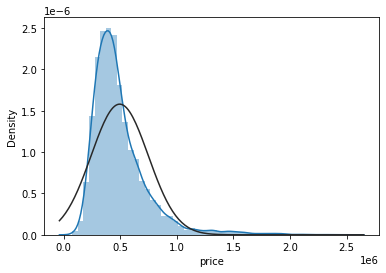

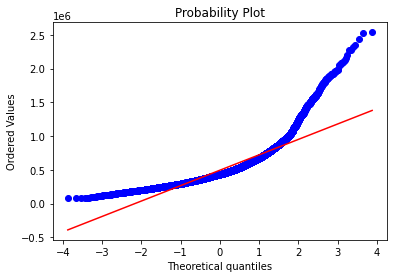

In [67]:
#histogram and normal probability plot
sns.distplot(df['price'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['price'], plot=plt)

# our sales price histogram is positively skewed and has a high peak
# Our QQ-plot shows that we have heavy tails with right skew

In [68]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

# price is highly right skewed
# very positive kurtosis, indicating lots in the tails. We can see those tails in the right skew.

Skewness: 2.289715
Kurtosis: 8.229123


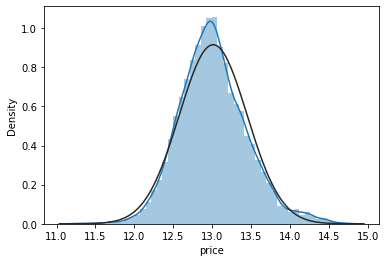

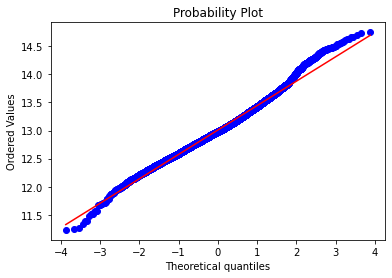

In [69]:
# log transform our target price to improve normality of distribution
df_target_log = np.log(df['price'])

#histogram and normal probability plot
sns.distplot(df_target_log, fit=norm);
fig = plt.figure()
res = stats.probplot(df_target_log, plot=plt)

# Our target price is more normally distributed when log transformed, so we'll be doing that when we make our model


## Natural Language Processing

Our data set includes the listing text for each sale. We're going to use Natural Language Processing methods to extract relevant information from the listing text to boost the effectiveness of our model.

We're using spaCy and after basic package installation, we also need to load the english language pipeline.

In [70]:
# Load spaCy with English language processor
nlp = spacy.load("en_core_web_sm")

# add real estate related stop words to default stop word list
nlp.Defaults.stop_words |= {"bedroom", "bathroom","bath","home", "austin", "tx", "pron", "sq", "ft", "rent", "mo",
                            "w", "bed", 'single', 'family', 'contain', 'st', 'dr', 'square', 'foot', 'room', 'square', 'feet',
                            '-pron-', 'garage', 'pflugerville', 'story', '1st', '1story', '2car', '2nd',
                            '2story', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', 'street', 'avenue', 'ave', 
                            'sac', 
                            
                           }

nlp.Defaults.stop_words.remove('is')
nlp.Defaults.stop_words.remove('as')

In [71]:
# text processing functions for NLP

def preprocessor(word):
    '''processes an individual word to remove punctuation, numbers, special characters etc
    Returns processed word, or blank string if character removal resulted in no word
    ARGUMENT:
    word from line of text'''
    if type(word) == str:
        word = re.sub(r'[^\w\s]', '', word)
        word = re.sub('<[^>]*>', '', word)
        word = re.sub('<[0-9]*>', '', word)
        word = re.sub('[\W]+', '', word.lower())
        try:
            word = int(word)
            word = ''
            return word
        except:
            return word

def word_processor(line):
    '''Takes a line of text. Tokenizes each word of sentence. 
    If token is stop word, goes to next token. If not stop word,
    calls preprocessor on word
    Returns processed words from line
    ARGUMENT: 
    line of text'''
    
    tokens = nlp(line) # nlp reads line and creates tokens from each word  
    words = [] # empty list of words for this line
    
    for token in tokens:
        if token.is_stop == False: # only continues if token is not stop word
            token_preprocessed = preprocessor(token.lemma_) # calls preprocessor on word
            if token_preprocessed != '': # only continues if returned word is not empty
                words.append(token_preprocessed) # appends word to list of words
    return(words) # return list of words for this line

def text_block_processor(text):
    '''Takes a block of text. Divides block into sentences with words lemmatized.
    Sends each sentence to word processor. Concatenates all words into one string
    If the string contains "zestimate", returns a DEFAULT listing note
    Otherwise returns string of cleaned and processed words from text block
    ARGUMENTS:
    block of text
    '''
    
    make_sentences = nlp(text)
    
    sentences_lemmata_list = [sentence.lemma_.lower() for sentence in make_sentences.sents]
    
    these_processed_sentences = ''

    
    for item in sentences_lemmata_list:
        words = word_processor(item)
        line = ' '.join(words)
        these_processed_sentences += (' ' + line)
        
    if 'zestimate' in these_processed_sentences:
        return 'DEFAULT'
    else:
        return these_processed_sentences

In [72]:
# reset indices on original data frame before making a copy
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [73]:
'''# copy the description column to a new data frame for text processing
listing_text = pd.DataFrame(df['description'])
listing_text

# cleaning all of the text in our listing_text description field and adding it to the listing_text data frame 
sentences = []

listing_text['sentences'] = None

for row in listing_text.index:
    thistext = listing_text['description'][row]
    the_sentences = text_block_processor(thistext)
    listing_text['sentences'][row] = the_sentences
    sentences += the_sentences

# drop the description field and export our listing_text to csv so we don't have to run it again
listing_text.drop('description', axis=1, inplace=True)

listing_text.to_pickle("listing_text.pkl")'''

'# copy the description column to a new data frame for text processing\nlisting_text = pd.DataFrame(df[\'description\'])\nlisting_text\n\n# cleaning all of the text in our listing_text description field and adding it to the listing_text data frame \nsentences = []\n\nlisting_text[\'sentences\'] = None\n\nfor row in listing_text.index:\n    thistext = listing_text[\'description\'][row]\n    the_sentences = text_block_processor(thistext)\n    listing_text[\'sentences\'][row] = the_sentences\n    sentences += the_sentences\n\n# drop the description field and export our listing_text to csv so we don\'t have to run it again\nlisting_text.drop(\'description\', axis=1, inplace=True)\n\nlisting_text.to_pickle("listing_text.pkl")'

In [74]:
listing_desc = pd.read_pickle("listing_text.pkl")
listing_desc

sentences
0                                                DEFAULT
1       absolutely gorgeous locate tuck away communit...
2       construction estimate completion august pione...
3       absolutely darle charming book like lake nort...
4       brim appeal warm livability sleek stylish mod...
...                                                  ...
13107   nestle mature shade tree locate establish nei...
13108    beautiful texas oaks huge covered patio neig...
13109   contemporary detach condo convenience downtow...
13110   original bungalow modern addition large corne...
13111                                            DEFAULT

[13112 rows x 1 columns]

In [75]:
# append our listing text to our original data frame
df = pd.concat([df, listing_desc], axis=1)

df

price        zpid          city                   streetAddress  \
0      328625.0   111373431  pflugerville            14424 Lake Victor Dr   
1      309233.0   120900430  pflugerville              1104 Strickling Dr   
2      286036.0  2084491383  pflugerville             1408 Fort Dessau Rd   
3      265930.0   120901374  pflugerville              1025 Strickling Dr   
4      255324.0    60134862  pflugerville           15005 Donna Jane Loop   
...         ...         ...           ...                             ...   
13107  289006.0    29504086        austin                   9013 Marsh Dr   
13108  335307.0    29512934        austin                 905 Silcantu Dr   
13109  558845.0   241937773        austin  1413 Waterloo Shore Ln UNIT 12   
13110  875000.0    29473281        austin                   2206 S 3rd St   
13111  374900.0    29390174        austin                  3110 E 12th St   

       zipcode                                        description   latitude  \
0        78660  14424 Lake Victor Dr, Pflugerville, TX 78660 i...  30.430632   
1        78660  Absolutely GORGEOUS 4 Bedroom home with 2 full...  30.432673   
2        78660  Under construction - estimated completion in A...  30.409748   
3        78660  Absolutely darling one story home in charming ...  30.432112   
4        78660  Brimming with appeal & warm livability! Sleek ...  30.437368   
...        ...                                                ...        ...   
13107    78748  This 3 bedroom home is nestled among mature sh...  30.185915   
13108    78748  Not for rent!\n\nBeautiful one story home in T...  30.161997   
13109    78741  This contemporary three-story detached condo h...  30.240223   
13110    78704  Original bungalow with a modern addition. Larg...  30.244835   
13111    78702  3110 E 12th St, Austin, TX 78702 is a single f...  30.276930   

       longitude  propertyTaxRate  garageSpaces  hasAssociation  hasCooling  \
0     -97.663078             1.98             2               1           1   
1     -97.661697             1.98             2               1           1   
2     -97.639771             1.98             0               1           1   
3     -97.661659             1.98             2               1           1   
4     -97.656860             1.98             0               1           1   
...          ...              ...           ...             ...         ...   
13107 -97.828415             1.98             2               0           1   
13108 -97.816345             1.98             3               0           1   
13109 -97.772835             1.98             2               1           1   
13110 -97.761124             1.98             2               0           1   
13111 -97.701523             1.98             1               0           1   

       hasGarage  hasHeating  hasSpa  hasView       homeType  parkingSpaces  \
0              1           1       0        0  Single Family              2   
1              1           1       0        0  Single Family              2   
2              0           1       0        0  Single Family              0   
3              1           1       0        0  Single Family              2   
4              0           1       0        0  Single Family              0   
...          ...         ...     ...      ...            ...            ...   
13107          1           1       1        0  Single Family              2   
13108          1           1       0        1  Single Family              5   
13109          1           1       1        1  Single Family              2   
13110          1           1       0        0  Single Family              2   
13111          1           1       0        1  Single Family              1   

       yearBuilt  orig_price  numPriceChanges latest_saledate  \
0           2012    305000.0                5      2019-09-02   
1           2013    295000.0                1      2020-10-13   
2           2018    256125.0   

## Create Holdout Set

We need to create our holdout data before any further processing.

The reasons for this are:
   * We will standardize our continuous variables, and you should standardize only on your train set and apply that to your test set.
   * We will be feature engineering on our train set, and applying that later to our test set. We cannot have our test set data leak into our engineered features.
   * We'll be doing some natural language processing, fitting on our train set and applying to our test set. We don't want data leakage for the same reasons as above.
    

In [76]:
# set our random seed for the notebook. We could randomize this each time the notebook is run,
# but ultimately we want all of our train/test splits to use the same data
randomstate = 2

y = pd.DataFrame(df['price'])
x = df.drop('price', axis=1,)

# creating our train/validation sets and our test sets
train_data, holdout, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=randomstate)

# reset indices to prevent any index mismatches
train_data.reset_index(inplace=True)
train_data.drop('index', axis=1, inplace=True)

holdout.reset_index(inplace=True)
holdout.drop('index', axis=1, inplace=True)

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

## Feature Engineering

In [77]:
# Adding target encoding, which we will opt to try instead of one-hot with a few models

# smooth mean function by MAx Halford at https://maxhalford.github.io/blog/target-encoding/

def calc_smooth_mean(df, by, on, m, target_df):
    '''input a pandas.DataFrame, a categorical column name, the name of the target column, and a weight .'''
    # Compute the global mean
    mean = df[on].mean() 

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])  
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return round(target_df[by].map(smooth), 0) 

num_of_samples = train_data.shape[0]
zip_samples = num_of_samples/train_data['zipcode'].unique().shape[0]
month_samples = num_of_samples/train_data['latest_salemonth'].unique().shape[0]


# create smooth additive encoded variables for zipcode, year built, and monthsold
train_data['zip_smooth'] = calc_smooth_mean(train_data, 'zipcode', 'price', zip_samples, train_data)
train_data['year_smooth'] = calc_smooth_mean(train_data, 'yearBuilt', 'price', 300, train_data)
train_data['month_smooth'] = calc_smooth_mean(train_data, 'latest_salemonth', 'price', month_samples, train_data)

# Create a wider lat and long zone to calculate an area mean
train_data['lat_zone'] = round(train_data['latitude'], 2)
train_data['long_zone'] = round(train_data['longitude'], 2)

lat_samples = num_of_samples/train_data['lat_zone'].unique().shape[0]
long_samples = num_of_samples/train_data['long_zone'].unique().shape[0]

# calculate smooth mean variables for lat and long, then create an interactive variable describing both together
train_data['lat_smooth'] = calc_smooth_mean(train_data, 'lat_zone', 'price', lat_samples, train_data)
train_data['long_smooth'] = calc_smooth_mean(train_data, 'long_zone', 'price', long_samples, train_data)
train_data['lat_long'] = round(np.sqrt(train_data['lat_smooth'] * train_data['long_smooth']), 0)

## Correlations/Multicollinearity

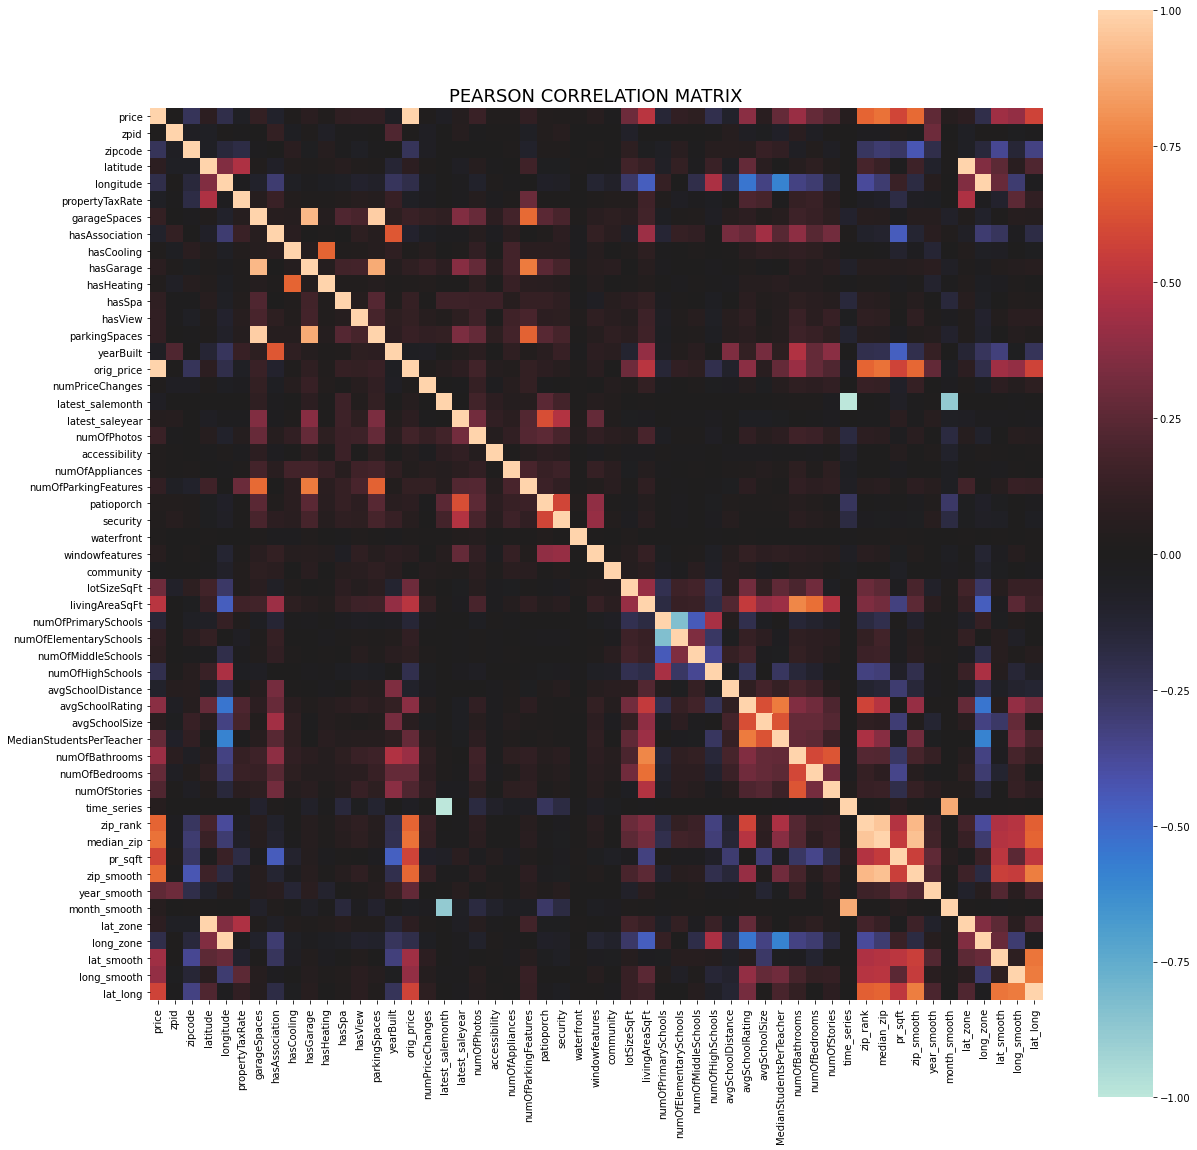

In [78]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(train_data.corr(), center=0,  
           vmin=-1, vmax=1,  square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [79]:
train_data.corr()

price      zpid   zipcode  latitude  longitude  \
price                     1.000000  0.009843 -0.235924  0.083482  -0.198288   
zpid                      0.009843  1.000000 -0.049849 -0.058464   0.009543   
zipcode                  -0.235924 -0.049849  1.000000 -0.055874  -0.150689   
latitude                  0.083482 -0.058464 -0.055874  1.000000   0.353445   
longitude                -0.198288  0.009543 -0.150689  0.353445   1.000000   
propertyTaxRate          -0.057975 -0.011761 -0.185847  0.475419  -0.018168   
garageSpaces              0.116301  0.007022 -0.020177  0.025583  -0.088659   
hasAssociation           -0.092607  0.111637 -0.007227 -0.070428  -0.290569   
hasCooling                0.020688 -0.040175  0.077758  0.035597  -0.062213   
hasGarage                 0.077534  0.023236 -0.032169  0.017674  -0.022099   
hasHeating                0.024869 -0.069831  0.051278  0.031670  -0.042387   
hasSpa                    0.096570 -0.010724 -0.010617  0.057535  -0.055044   
hasView                   0.108982 -0.009223 -0.054963  0.030181  -0.101470   
parkingSpaces             0.105161  0.002165 -0.011426  0.023118  -0.085774   
yearBuilt                -0.047434  0.211211  0.001655 -0.128187  -0.244932   
orig_price                0.992320  0.011135 -0.235896  0.081690  -0.197325   
numPriceChanges           0.019714 -0.048165 -0.048013  0.019911  -0.046720   
latest_salemonth         -0.048954 -0.001665 -0.006088  0.000884  -0.001907   
latest_saleyear           0.046659  0.052319 -0.002946 -0.049919  -0.020845   
numOfPhotos               0.140553 -0.014444 -0.002269  0.051288  -0.092089   
accessibility             0.027295  0.009428 -0.006023 -0.011891   0.021784   
numOfAppliances           0.027986  0.009402  0.019765 -0.001143  -0.015042   
numOfParkingFeatures      0.102846 -0.058560 -0.092738  0.163968   0.003944   
patioporch                0.037784  0.034940  0.026241 -0.034451  -0.075053   
security                  0.025220  0.055728  0.023611 -0.037467  -0.066640   
waterfront                0.016382 -0.004205 -0.001695  0.013068   0.004524   
windowfeatures            0.055042 -0.006626  0.018582  0.003076  -0.121428   
community                -0.009123  0.000833  0.006531 -0.011458  -0.085741   
lotSizeSqFt               0.300847 -0.078596  0.092617  0.168886  -0.271558   
livingAreaSqFt            0.503059 -0.002300 -0.033014  0.128777  -0.461383   
numOfPrimarySchools      -0.140267 -0.003929 -0.061646 -0.065127   0.121307   
numOfElementarySchools    0.107482  0.007717  0.065737  0.116861  -0.001248   
numOfMiddleSchools        0.087577 -0.001156 -0.013916 -0.023348  -0.195360   
numOfHighSchools         -0.206649  0.013913  0.055231  0.135399   0.465105   
avgSchoolDistance        -0.089477  0.054352  0.055956 -0.042642  -0.206142   
avgSchoolRating           0.379111 -0.049475  0.054345  0.277464  -0.541141   
avgSchoolSize             0.067305 -0.032786  0.130949  0.068954  -0.333218   
MedianStudentsPerTeacher  0.278755 -0.073571  0.108692 -0.003815  -0.591490   
numOfBathrooms            0.419324  0.075099 -0.051157  0.048399  -0.335836   
numOfBedrooms             0.274806 -0.051439  0.032500  0.087325  -0.289715   
numOfStories              0.215601  0.011134 -0.052631  0.038252  -0.152475   
time_series               0.048954  0.001665  0.006088 -0.000884   0.001907   
zip_rank                  0.686382 -0.030854 -0.251921  0.179934  -0.379443   
median_zip                0.724253 -0.023509 -0.294319  0.132882  -0.290428   
pr_sqft                   0.579848  0.027137 -0.258766 -0.012793   0.134932   
zip_smooth                0.697567 -0.012000 -0.431799  0.149841  -0.178567   
year_smooth               0.264736  0.299878 -0.195837 -0.093092   0.053284   
month_smooth              0.053658  0.001550  0.009054  0.014460  -0.004215   
lat_zone                  0.083292 -0.058376 -0.055965  0.999579   0.353887   
long_zone                -0.198094  0.009636 -0.149986  0.353766   0.999403   


In [80]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


level_0  \
pairs                                                                   
(median_zip, zip_smooth)                                   median_zip   
(zip_smooth, median_zip)                                   zip_smooth   
(garageSpaces, hasGarage)                                garageSpaces   
(hasGarage, garageSpaces)                                   hasGarage   
(zip_smooth, zip_rank)                                     zip_smooth   
(zip_rank, zip_smooth)                                       zip_rank   
(time_series, month_smooth)                               time_series   
(month_smooth, time_series)                              month_smooth   
(month_smooth, latest_salemonth)                         month_smooth   
(latest_salemonth, month_smooth)                     latest_salemonth   
(hasGarage, parkingSpaces)                                  hasGarage   
(parkingSpaces, hasGarage)                              parkingSpaces   
(numOfPrimarySchools, numOfElementarySchools)     numOfPrimarySchools   
(numOfElementarySchools, numOfPrimarySchools)  numOfElementarySchools   
(livingAreaSqFt, numOfBathrooms)                       livingAreaSqFt   
(numOfBathrooms, livingAreaSqFt)                       numOfBathrooms   
(lat_long, zip_smooth)                                       lat_long   
(zip_smooth, lat_long)                                     zip_smooth   

                                                              level_1  \
pairs                                                                   
(median_zip, zip_smooth)                                   zip_smooth   
(zip_smooth, median_zip)                                   median_zip   
(garageSpaces, hasGarage)                                   hasGarage   
(hasGarage, garageSpaces)                                garageSpaces   
(zip_smooth, zip_rank)                                       zip_rank   
(zip_rank, zip_smooth)                                     zip_smooth   
(time_series, month_smooth)                              month_smooth   
(month_smooth, time_series)                               time_series   
(month_smooth, latest_salemonth)                     latest_salemonth   
(latest_salemonth, month_smooth)                         month_smooth   
(hasGarage, parkingSpaces)                              parkingSpaces   
(parkingSpaces, hasGarage)                                  hasGarage   
(numOfPrimarySchools, numOfElementarySchools)  numOfElementarySchools   
(numOfElementarySchools, numOfPrimarySchools)     numOfPrimarySchools   
(livingAreaSqFt, numOfBathrooms)                       numOfBathrooms   
(numOfBathrooms, livingAreaSqFt)                       livingAreaSqFt   
(lat_long, zip_smooth)                                     zip_smooth   
(zip_smooth, lat_long)                                       lat_long   

                                               correlation  
pairs                                                       
(median_zip, zip_smooth)                          0.939143  
(zip_smooth, median_zip)                          0.939143  
(garageSpaces, hasGarage)                         0.921581  
(hasGarage, garageSpaces)                         0.921581  
(zip_smooth, zip_rank)                            0.914548  
(zip_rank, zip_smooth)                            0.914548  
(time_series, month_smooth)                       0.878466  
(month_smooth, time_series)                       0.878466  
(month_smooth, latest_salemonth)                  0.878466  
(latest_salemonth, month_smooth)                  0.878466  
(hasGarage, parkingSpaces)                        0.875227  
(parkingSpaces, hasGarage)                        0.875227  
(numOfPrimarySchools, numOfElementarySchools)     0.831407  
(numOfElementarySchools, numOfPrimarySchools)     0.831407  
(livingAreaSqFt, numOfBathrooms)                  0.780524  
(numOfBathrooms, livingAreaSqFt)                  0.780524  
(lat_long, zip_smooth)                    

In [81]:
# Check out our variables correlationg with price
df_correlations = train_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'price'].sort_values(0, ascending=False)

level_0                   level_1         0
0    price                     price  1.000000
15   price                orig_price  0.992320
43   price                median_zip  0.724253
45   price                zip_smooth  0.697567
42   price                  zip_rank  0.686382
44   price                   pr_sqft  0.579848
52   price                  lat_long  0.575761
29   price            livingAreaSqFt  0.503059
50   price                lat_smooth  0.430168
38   price            numOfBathrooms  0.419324
51   price               long_smooth  0.405965
35   price           avgSchoolRating  0.379111
28   price               lotSizeSqFt  0.300847
37   price  MedianStudentsPerTeacher  0.278755
39   price             numOfBedrooms  0.274806
46   price               year_smooth  0.264736
2    price                   zipcode  0.235924
40   price              numOfStories  0.215601
33   price          numOfHighSchools  0.206649
4    price                 longitude  0.198288
49   price                 long_zone  0.198094
19   price               numOfPhotos  0.140553
30   price       numOfPrimarySchools  0.140267
6    price              garageSpaces  0.116301
12   price                   hasView  0.108982
31   price    numOfElementarySchools  0.107482
13   price             parkingSpaces  0.105161
22   price      numOfParkingFeatures  0.102846
11   price                    hasSpa  0.096570
7    price            hasAssociation  0.092607
34   price         avgSchoolDistance  0.089477
32   price        numOfMiddleSchools  0.087577
3    price                  latitude  0.083482
48   price                  lat_zone  0.083292
9    price                 hasGarage  0.077534
36   price             avgSchoolSize  0.067305
5    price           propertyTaxRate  0.057975
26   price            windowfeatures  0.055042
47   price              month_smooth  0.053658
41   price               time_series  0.048954
17   price          latest_salemonth  0.048954
14   price                 yearBuilt  0.047434
18   price           latest_saleyear  0.046659
23   price                patioporch  0.037784
21   price           numOfAppliances  0.027986
20   price             accessibility  0.027295
24   price                  security  0.025220
10   price                hasHeating  0.024869
8    price                hasCooling  0.020688
16   price           numPriceChanges  0.019714
25   price                waterfront  0.016382
1    price                      zpid  0.009843
27   price                 community  0.009123

We'll drop:

* parkingSpaces, hasGarage, numOfParkingFeatures and keep garageSpaces (higher relationship with Price)
* numOfElementarySchools, and keep numOfPrimarySchools (higher relationship with Price)
* MedianStudentsPerTeacher, keeping avgSchoolRating
* numOfBathrooms correlates with square footage, but I'm not dropping either

We can get a sense of the most important features to our price from our correlation table. Zipcode as a plain variable does not correlate, which makes sense, because without some sort of transformation it is an arbitrary unordered number. We can see how transformed as median_zip or zip_rank it becomes the MOST important contributor to price. We can see here that big contributors to price include
    
    * Lat/long in a target encoded form
    * zip code (in some altered form, not as arbitrary number)
    * livingAreaSqFt
    * numBathrooms
    * avgSchoolRating

In [82]:
train_data['numOfSchools'] = train_data['numOfPrimarySchools'] + train_data['numOfElementarySchools'] + train_data['numOfMiddleSchools'] + train_data['numOfHighSchools']
holdout['numOfSchools'] = holdout['numOfPrimarySchools']  + holdout['numOfElementarySchools'] + holdout['numOfMiddleSchools'] + holdout['numOfHighSchools']

In [83]:
# drop multicollinear features
train_data.drop(['parkingSpaces', 'hasGarage', 'numOfElementarySchools', 'numOfPrimarySchools', 'numOfMiddleSchools', 
         'numOfHighSchools', 'MedianStudentsPerTeacher', 'numOfParkingFeatures'], axis=1, inplace=True)
holdout.drop(['parkingSpaces', 'hasGarage', 'numOfElementarySchools', 'numOfPrimarySchools', 'numOfMiddleSchools', 
         'numOfHighSchools', 'MedianStudentsPerTeacher', 'numOfParkingFeatures'], axis=1, inplace=True)

## EDA and Processing Train Set

### Categoricals

In [84]:
categories = ['zipcode', 'yearBuilt', 'hasAssociation', 'hasCooling', 'hasHeating', 'hasSpa', 'hasView', 'accessibility', 'patioporch', 'security',
          'waterfront', 'windowfeatures', 'community', 'latest_salemonth', 'numOfSchools', 'garageSpaces', 'propertyTaxRate', ]

df_categoricals = train_data[categories]

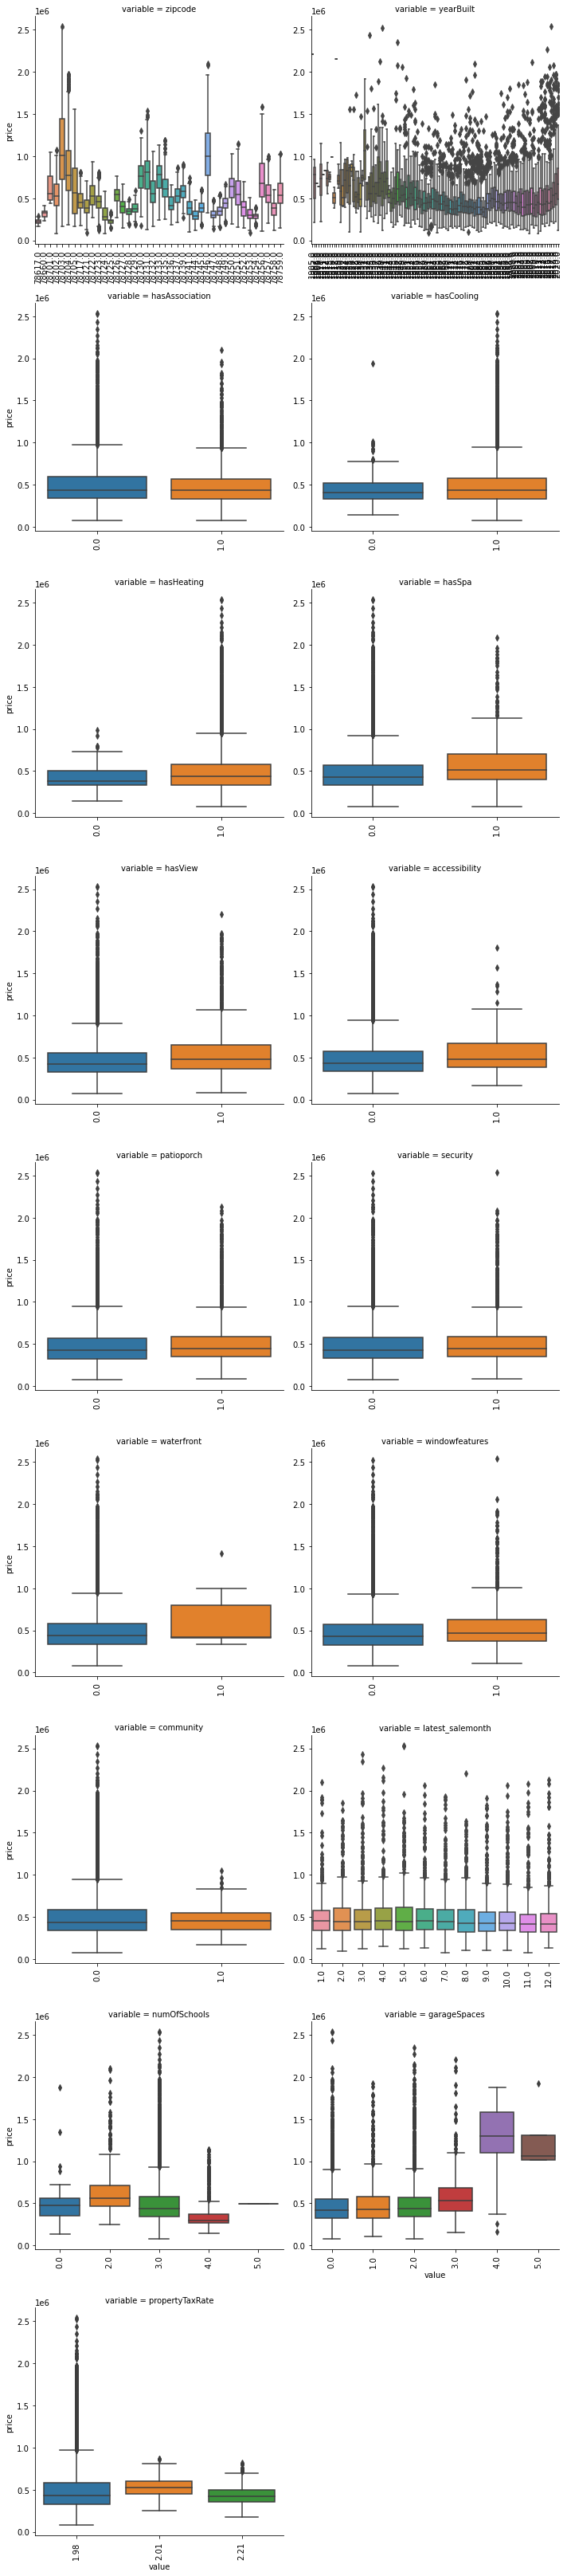

In [85]:
# adding price to our dataframe so that we can do some visualizations    

df_categoricals['price'] = train_data['price']

# plot our categoricals as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(df_categoricals, id_vars=['price'], value_vars=categories)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

df_categoricals.drop('price', axis=1, inplace=True)

In [86]:
# there is only ONE listing with 5 schools, so we will change that one to 4
df_categoricals.loc[df_categoricals['numOfSchools']==5, 'numOfSchools'] = 4

In [87]:
# binning our year built bins
# We're also saving the bin information to year_bins because we will need the bin information to make new predictions
num_bins = 30
labels = np.array(range(1,num_bins+1))
df_categoricals["year_block"], year_bins = pd.qcut(df_categoricals['yearBuilt'], q=num_bins, retbins=True, labels=labels)

df_categoricals.drop('yearBuilt', axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in df_categoricals.columns:
    df_categoricals[item] = df_categoricals[item].astype('category')

In [88]:
# make a processed bins file for use with linear regression
# We're making TWO categorical sets. One is high one hot encoding. One is low one hot encoding, and the 
# categoricals in that one will be target encoded as continuous instead

high_one_hot_cat =  ['zipcode', 'year_block', 'hasAssociation', 
                 'hasCooling', 'hasHeating', 'hasSpa', 'hasView', 
                 'accessibility', 'patioporch', 'security', 'numOfSchools',
              'waterfront', 'windowfeatures', 'community', 'latest_salemonth',
                    'garageSpaces', 'propertyTaxRate', ]
low_one_hot_cat =  ['hasAssociation', 
                'hasCooling', 'hasHeating', 'hasSpa', 
                'hasView', 'accessibility', 'patioporch', 'numOfSchools',
                'security', 'waterfront', 'windowfeatures', 'community', 'garageSpaces', 'propertyTaxRate', ]

df_cats_high_one_hot = pd.get_dummies(df_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=True)
df_cats_low_one_hot = pd.get_dummies(df_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=True)

### Continuous

In [89]:
continuous = ['numPriceChanges', 
              'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 
              'numOfStories', 'numOfPhotos', 
              'numOfAppliances', 'latest_salemonth',
             'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long'] 

x_continuous = train_data[continuous]
x_continuous['price'] = train_data['price']

Let's look at mean price by month and see if there are any better insights.

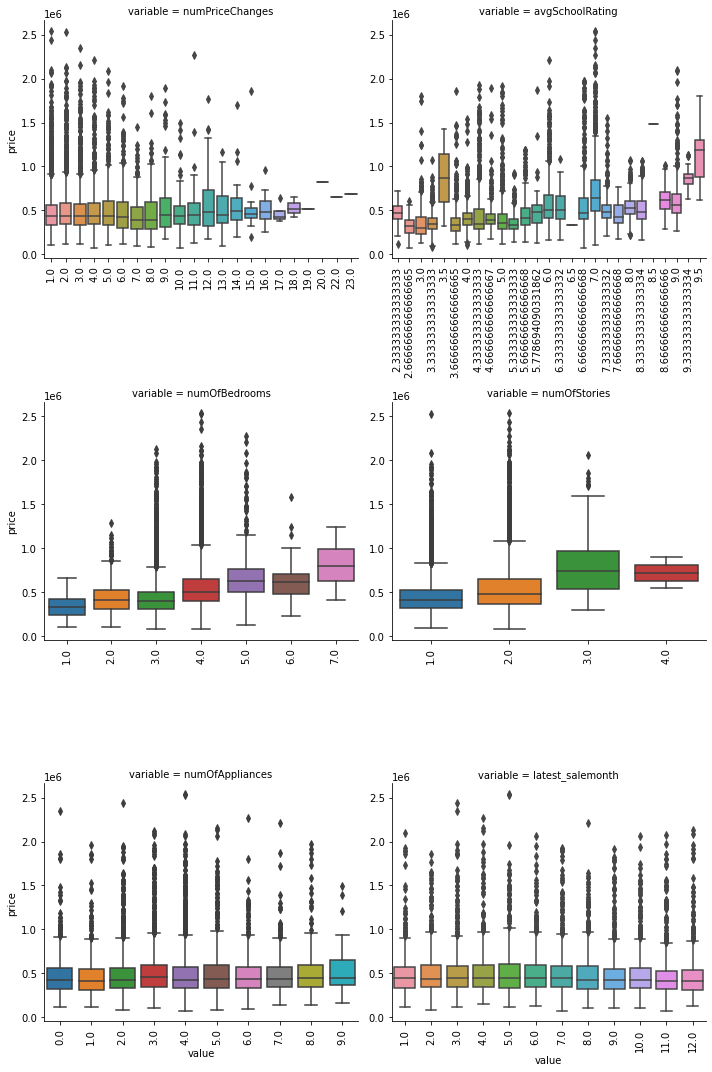

In [90]:
small_cont = ['numPriceChanges', 
              'avgSchoolRating', 'numOfBedrooms', 
              'numOfStories', 'numOfAppliances', 
              'latest_salemonth']
# plot our continuous as box plots vs price
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(x_continuous, id_vars=['price'], value_vars=small_cont)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")


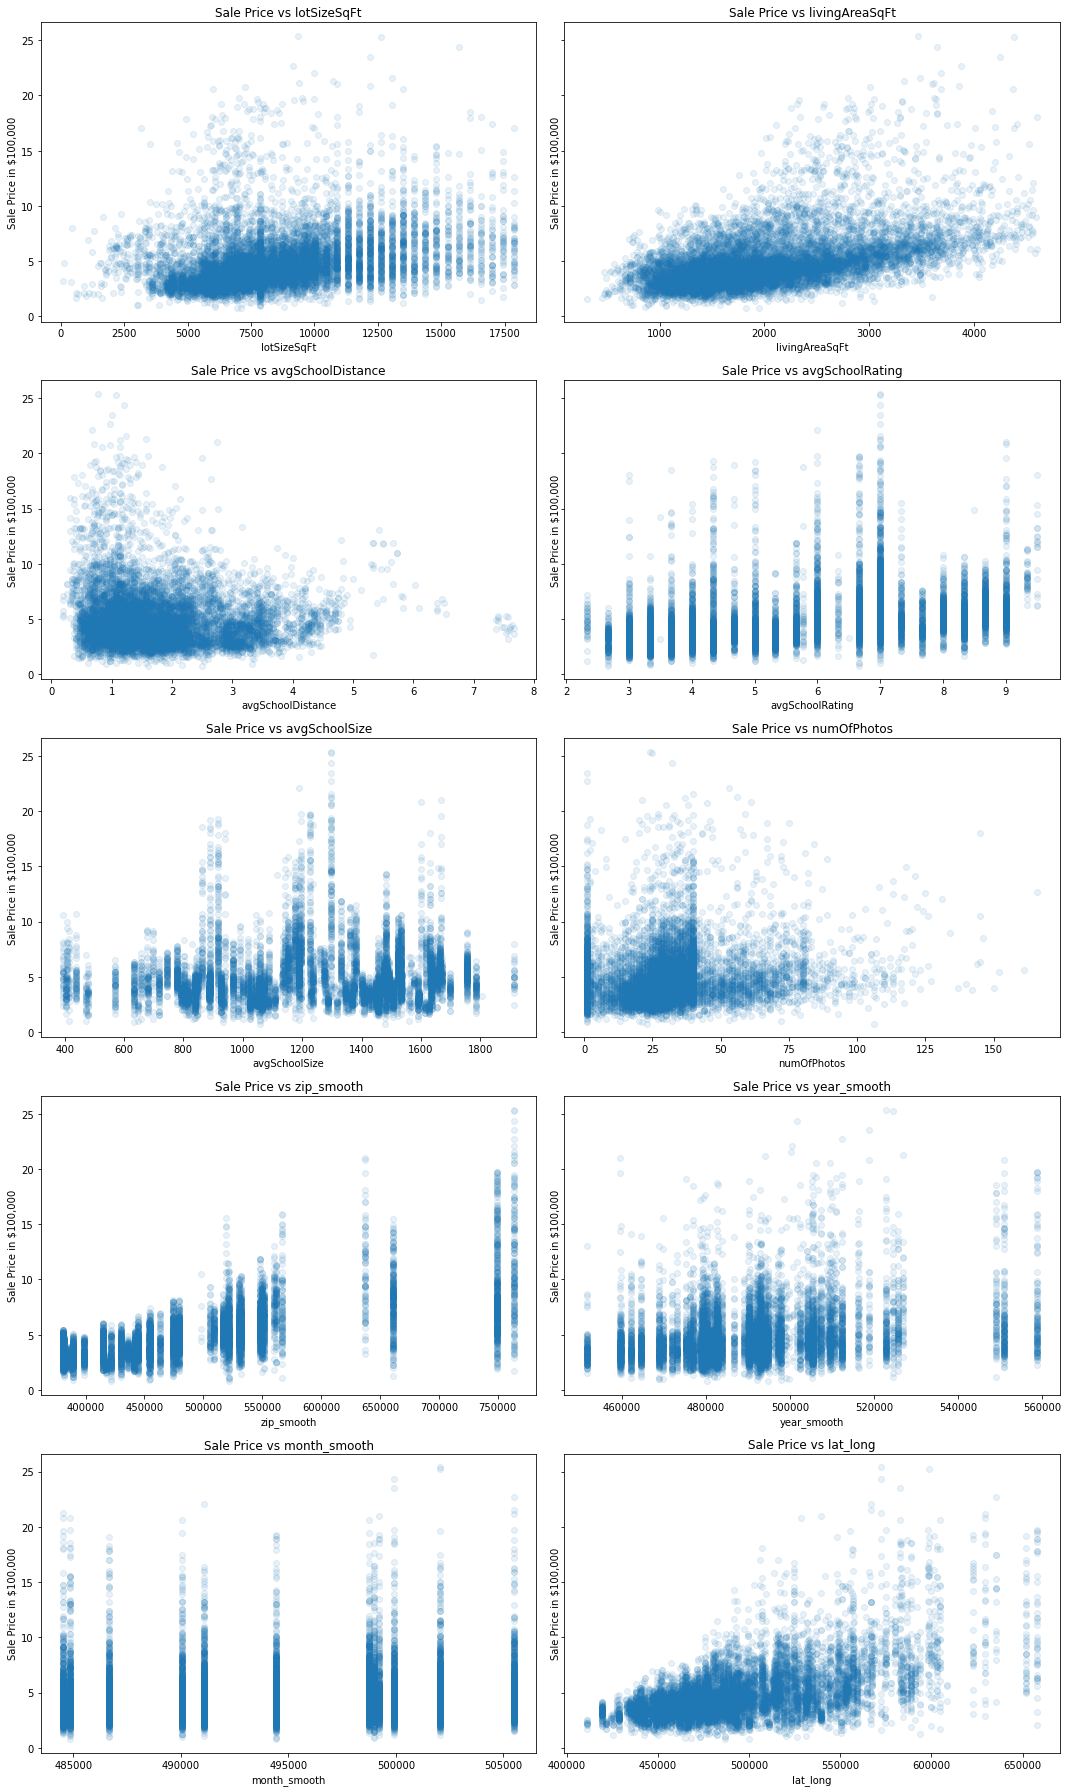

In [91]:
large_cont = ['lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfPhotos',
             'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long']

# check linearity of continuous predictors

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,25), sharey=True)

for ax, column in zip(axes.flatten(), large_cont):
    ax.scatter(x_continuous[column], x_continuous['price']/100000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()

Positive relationship observed with:
* lot size
* square footage
* school rating
* number of bedrooms
* lat/long

Negative relationship observed with:
* number of price changes

Others seem neutral/uncertain

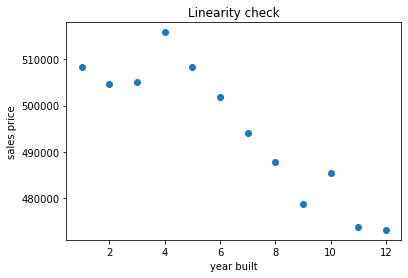

In [92]:
# Checking out our mean sales price for year built scattered versus price shows a polynomial relationship

yearly_prices = train_data.groupby('latest_salemonth')['price'].mean()

plt.scatter(yearly_prices.index, yearly_prices)
plt.title("Linearity check")
plt.xlabel('year built')
plt.ylabel('sales price')
plt.show()

Our average per month looks polynomial.

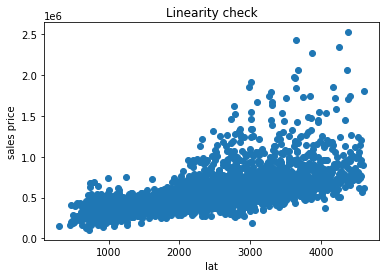

In [93]:
# Checking out our mean sales price for latitude  scattered versus price shows a polynomial relationship
lat_prices = train_data.groupby('livingAreaSqFt')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

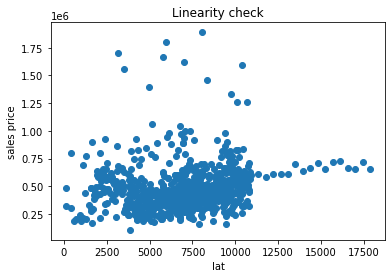

In [94]:
# Checking out our mean sales price for latitude  scattered versus price shows a polynomial relationship
lat_prices = train_data.groupby('lotSizeSqFt')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

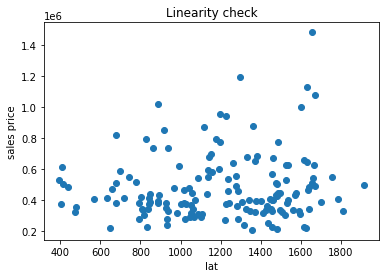

In [95]:
# Checking out our mean sales price for latitude  scattered versus price shows a polynomial relationship
lat_prices = train_data.groupby('avgSchoolSize')['price'].mean()

plt.scatter(lat_prices.index, lat_prices)
plt.title("Linearity check")
plt.xlabel('lat')
plt.ylabel('sales price')
plt.show()

#### Standardize

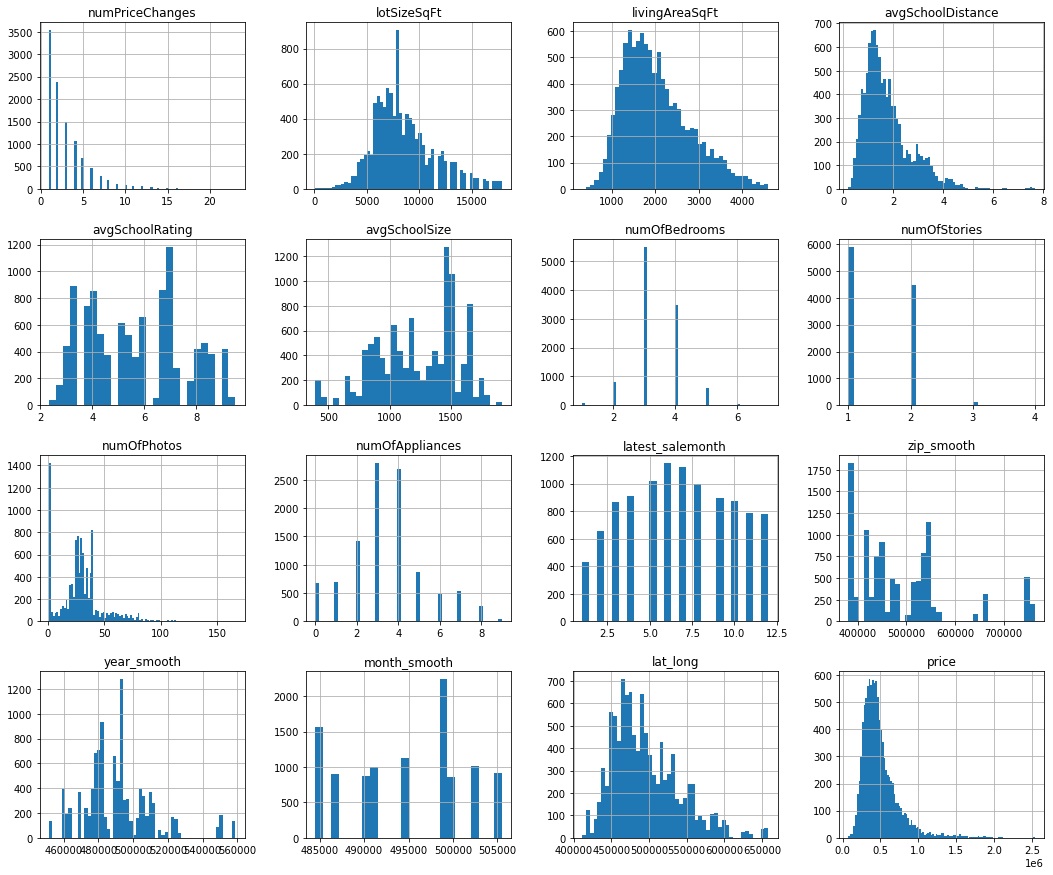

In [96]:
# check out our histograms

x_continuous.hist(figsize=(18,15), bins='auto');

In [97]:
# don't need price in there anymore
x_continuous.drop('price', axis=1, inplace=True)

# standardize all of our values with scikit-learn StandardScaler
scaler = StandardScaler()

#transformed_scaled_continuous = pd.DataFrame(scaler.fit_transform(x_train_cont_log),columns = x_train_cont_log.columns)
scaled_continuous = pd.DataFrame(scaler.fit_transform(x_continuous),columns = x_continuous.columns)
scaled_continuous.head(5)

numPriceChanges  lotSizeSqFt  livingAreaSqFt  avgSchoolDistance  \
0         0.417376    -0.311963        0.092986          -0.998521   
1        -0.807885     0.094855       -1.192421          -0.716288   
2        -0.807885    -0.071052       -0.809506           1.788532   
3        -0.807885     1.148780        1.772911           4.928376   
4        -0.807885    -1.185049       -0.757935          -0.469334   

   avgSchoolRating  avgSchoolSize  numOfBedrooms  numOfStories  numOfPhotos  \
0         1.076298       0.154115       2.186686     -0.863622    -0.196141   
1         0.715907      -0.126976      -0.495905      1.071135    -1.415948   
2        -0.004875       0.309937       0.845391     -0.863622    -0.342518   
3         0.715907      -0.285853       0.845391      1.071135     1.950718   
4         1.076298       1.694004      -0.495905     -0.863622    -0.391310   

   numOfAppliances  latest_salemonth  zip_smooth  year_smooth  month_smooth  \
0         0.291213         -1.190807    0.622508    -1.591035      0.770904   
1        -1.876662         -0.871841    0.412092     1.282138      1.603875   
2         0.291213         -0.871841    0.594146    -0.748616      1.603875   
3         0.291213          0.085055    0.267325     0.934150     -0.046864   
4        -0.792724         -0.233910   -0.114273    -1.983102      0.600704   

   lat_long  
0 -0.727286  
1  0.448982  
2  0.282460  
3 -0.985157  
4 -0.040848

In [98]:
# make a processed bins file for use with linear regression
# We're making TWO continuous sets. One is high one hot encoding. One is low one hot encoding, and includes the 
# categoricals that are target encoded as continuous instead

high_one_hot_cont =  ['numPriceChanges', 
              'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 
              'numOfStories', 'numOfPhotos', 
              'numOfAppliances']
low_one_hot_cont =  ['numPriceChanges', 
              'lotSizeSqFt', 'livingAreaSqFt', 'avgSchoolDistance', 
              'avgSchoolRating', 'avgSchoolSize', 'numOfBedrooms', 
              'numOfStories', 'numOfPhotos', 
              'numOfAppliances',  
             'zip_smooth', 'year_smooth', 'month_smooth', 'lat_long']

df_cont_high_one_hot = scaled_continuous[high_one_hot_cont]
df_cont_low_one_hot = scaled_continuous[low_one_hot_cont]

#### Finding Interactions

I wrote a function which finds all of the feature combinations possible in our dataset. Then for each combination, the function runs a linear regression with cross validation on 5 folds and gets the r^2 score for the regression including that feature combination. All scores are recorded and r^2 score improvement is assessed, with the resulting table giving the increase in model improvement from a feature combo. 

In [99]:
'''def test_feature_combinations(price, variables):
    
    """Function takes in target price and a dataframe of independent variables, and 
    tests model improvement for each combination of variables
    ARGUMENTS:
    Y of target values
    X-dataframe of continuous features
    Returns dataframe of score improvements over base score for each interaction combination"""
    
    # select our estimator and our cross validation plan
    regression = LinearRegression()
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    
    # prepare our scoring dataframe
    scoring_df = pd.DataFrame()
    
    # prepare our lists to store our features and scores as we iterate
    scores = []
    feature1 = []
    feature2 = []
    
    # Get a list of all of our features, and remove our target variable 'price' from the list
    features = list(variables.columns)

    # make a list of all of our possible feature combinations
    feature_combos = itertools.combinations(features, 2)
    feature_combos = list(feature_combos)
    
    # set our y-value as our target variable
    y = price
    
    # prepare our x-value with our independent variables. We do an initial split here in order to run a 
    # linear regression to get a base r^2 on our basic model without interactions
    X = variables
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
    base_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)   
    print("Model base score is ",base_score)
    
    # now we run the regression on each feature combo
    for feature in feature_combos:
        feat1, feat2 = feature[0], feature[1]
        
        # create the test interaction on our data set
        variables['test_interaction'] = variables[feat1] * variables[feat2]
        # create a new X which includes the test interaction and drops our target value
        X = variables
        # make a new split so that our x-splits include the test interaction
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
        
        # Run a linear regression with cross-val just like our base model, and append the score to our scores list
        new_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)
        scores.append(new_score)
        # put feature 1 on a list
        feature1.append(feat1)
        # put feature 2 on a list
        feature2.append(feat2)
        print(feat1, feat2, new_score)
        
        
    
    # load all of our lists into the scoring dataframe
    scoring_df['feature1'] = feature1
    scoring_df['feature2'] = feature2
    scoring_df['scores'] = scores
    scoring_df['improvement'] = scoring_df['scores'] - base_score
    variables.drop('test_interaction', axis=1, inplace=True)
    
    # return our scoring dataframe to the function
    return scoring_df'''

'def test_feature_combinations(price, variables):\n    \n    """Function takes in target price and a dataframe of independent variables, and \n    tests model improvement for each combination of variables\n    ARGUMENTS:\n    Y of target values\n    X-dataframe of continuous features\n    Returns dataframe of score improvements over base score for each interaction combination"""\n    \n    # select our estimator and our cross validation plan\n    regression = LinearRegression()\n    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)\n    \n    # prepare our scoring dataframe\n    scoring_df = pd.DataFrame()\n    \n    # prepare our lists to store our features and scores as we iterate\n    scores = []\n    feature1 = []\n    feature2 = []\n    \n    # Get a list of all of our features, and remove our target variable \'price\' from the list\n    features = list(variables.columns)\n\n    # make a list of all of our possible feature combinations\n    feature_combos = itertools.com

In [100]:
# running our function on our continuous variables to look for improvement
# our R2 is much lower for model base score because we aren't including our categorical variables in this improvement assessment

#scoring_df = test_feature_combinations(y_train, df_cont_low_one_hot)

In [101]:
# showing our improvement scores for our interactions

#scoring_df.sort_values('improvement', ascending=False)

We won't add any interactions. None of these improvements were significant enough.

#### Add polynomial features

In [102]:
def plot_polys(y, xlabel, title):
    '''Takes in a y-axis, x-axis label, and title and plots with various polynomial levels
    ARGUMENTS:
    y axis variable values
    x-axis label
    visualization title'''
    x = y.index
    
    # express numbers as arrays and reshape
    y = np.array(y)
    x = np.array(x)
    x = x.reshape(-1, 1)
    
    # make sure indices match up
    y = y[x[:,0].argsort()]
    x = x[x[:, 0].argsort()]

    # plot figure
    plt.figure(figsize=(16, 8))

    # standard linear regression
    linreg = LinearRegression()
    linreg.fit(x, y)

    # 2nd degree polynomial regression
    poly2 = PolynomialFeatures(degree=2)
    x_poly2 = poly2.fit_transform(x)
    poly_reg2 = LinearRegression()
    poly_reg2.fit(x_poly2, y)

    # third degree polynomial regression 
    poly3 = PolynomialFeatures(degree=3)
    x_poly3 = poly3.fit_transform(x)
    poly_reg3 = LinearRegression()
    poly_reg3.fit(x_poly3, y)

    # predict on x values
    pred = linreg.predict(x)
    pred2 = poly_reg2.predict(x_poly2)
    pred3 = poly_reg3.predict(x_poly3)

    # plot regression lines
    plt.scatter(x, y)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Average')
    plt.plot(x, pred, c='red', label='Linear regression line')
    plt.plot(x, pred2, c='yellow', label='Polynomial regression line 2')
    plt.plot(x, pred3, c='#a3cfa3', label='Polynomial regression line 3');

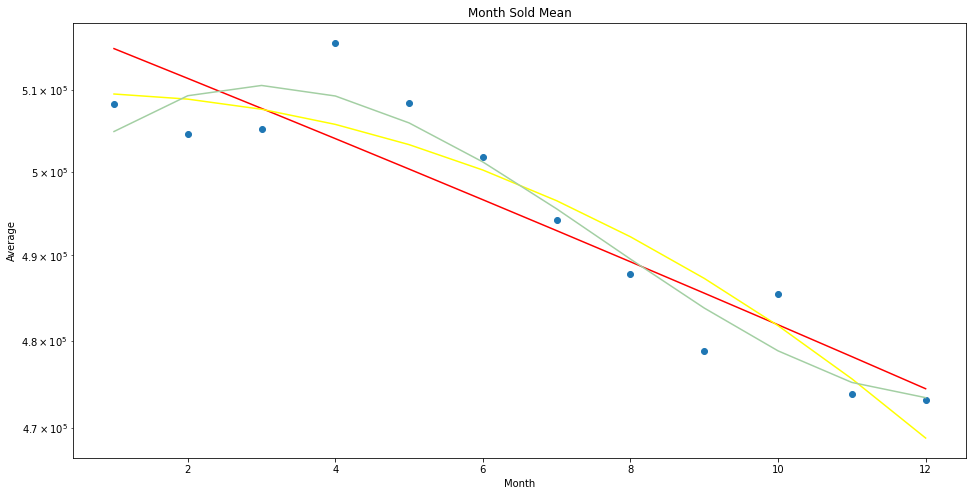

In [103]:
# group by average month sold mean to see relationship
y = train_data.groupby('latest_salemonth')['price'].mean()
plot_polys(y, "Month", "Month Sold Mean")

In [104]:
# adding our chosen polynomial features

def create_polynomial_array(data, column, num_features):
    values = data[column]
    poly_array = np.array(values)
    poly_array = poly_array.reshape(-1,1)
    poly_fit = PolynomialFeatures(degree=num_features, include_bias=False)
    fit_features = poly_fit.fit_transform(poly_array)
    poly_df = pd.DataFrame(fit_features)
    return poly_df

month_poly = create_polynomial_array(df_cont_low_one_hot, 'month_smooth',2)

df_cont_low_one_hot['month1'] = month_poly[1]


### NLP 

In [105]:
nlp = ['sentences']

nlp_train = train_data[nlp]

In [106]:
nlp_train.head(10)

sentences
0   anderson mill beauty open floorplan gorgeous ...
1   great highly desire crestview hardwood floor ...
2   charming long greenbelt corner interior origi...
3   miss chance live beautiful reunion ranch ceil...
4   beautiful locate cul de large treed lot enjoy...
5   readylocate large woode lot popular south nei...
6   great large tree cover corner lot near future...
7   picturesque buffington feature spacious layou...
8   new construction gate live eane isd day compl...
9   beautiful maintain highly desirable area matu...

In [107]:
v = TfidfVectorizer(sublinear_tf=True, max_df=0.9, min_df=.005, ngram_range=(1,4), max_features=1000)
x = v.fit_transform(nlp_train['sentences'])

train_word_vectors = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

In [108]:
predictors_train = sm.add_constant(train_word_vectors)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     6.940
Date:                Tue, 25 May 2021   Prob (F-statistic):               0.00
Time:                        22:31:23   Log-Likelihood:            -1.4251e+05
No. Observations:               10489   AIC:                         2.870e+05
Df Residuals:                    9491   BIC:                         2.943e+05
Df Model:                         997                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       4.319e+05   1.36e+04     31.763      0.000    4.05e+05    4.59e+05
1story                     -1.304e+04   1.04e+05     -0.126      0.900   -2.16e+05     1.9e+05
2car                       -4.243e+04   1.09e+05     -0.388      0.698   -2.57e+05    1.72e+05
2story                      2.305e+04   9.91e+04      0.233      0.816   -1.71e+05    2.17e+05
abundance                   1.005e+05   1.44e+05      0.696      0.487   -1.83e+05    3.84e+05
abundance natural           1.081e+04   1.76e+05      0.061      0.951   -3.35e+05    3.57e+05
abundant                    8.672e+04   9.95e+04      0.872      0.383   -1.08e+05    2.82e+05
ac                         -6.657e+04   8.35e+04     -0.797      0.425    -2.3e+05    9.71e+04
accent                      9.399e+04   9.85e+04      0.954      0.340   -9.91e+04    2.87e+05
access                      1.649e+05   8.58e+04      1.921      0.055   -3388.395    3.33e+05
access mopac                1.664e+05   2.16e+05      0.769      0.442   -2.58e+05    5.91e+05
acre                        8.732e+04    8.5e+04      1.027      0.304   -7.93e+04    2.54e+05
acre lot                    7.155e+04   1.11e+05      0.642      0.521   -1.47e+05     2.9e+05
add                        -3.207e+04   6.47e+04     -0.495      0.620   -1.59e+05    9.48e+04
addition                    3.668e+05   8.54e+04      4.293      0.000    1.99e+05    5.34e+05
additional                  7451.1230   7.31e+04      0.102      0.919   -1.36e+05    1.51e+05
adorable                   -2.487e+05   8.53e+04     -2.916      0.004   -4.16e+05   -8.15e+04
agent                       4.093e+04   7.85e+04      0.522      0.602   -1.13e+05    1.95e+05
air                         1.323e+05   1.03e+05      1.288      0.198   -6.91e+04    3.34e+05
airport                    -2.486e+05   7.87e+04     -3.157      0.002   -4.03e+05   -9.42e+04
airy                        6.593e+04   1.09e+05      0.606      0.545   -1.47e+05    2.79e+05
alamo                      -5.845e+04   1.16e+05     -0.502      0.616   -2.87e+05     1.7e+05
allow                       1.164e+05   8.41e+04      1.384      0.166   -4.84e+04    2.81e+05
amazing                    -2.819e+04   5.98e+04     -0.471      0.638   -1.46e+05    8.91e+04
amenity                    -1.933e+05   8.36e+04     -2.312      0.021   -3.57e+05   -2.94e+04
amenity include             5.892e+04   1.27e+05      0.464      0.643    -1.9e+05    3.08e+05
ample                       4.308e+04   8.64e+04      0.498      0.618   -1.26e+05    2.12e+05
anderson                    2.006e+05   1.04e+05      1.921      0.055   -4143.635    4.05e+05
appeal                      1.647e+05   2.01e+05      0.818      0.414    -2.3e+05    5.59e+05
apple                      -5.629e+04   1.3

In [109]:
'''model = LinearRegression()
model.fit(train_word_vectors, y_train)

from sklearn.inspection import permutation_importance
r = permutation_importance(model, train_word_vectors, y_train,
                           n_repeats=10,
                            random_state=0,
                          n_jobs=-1)

importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        importances[train_word_vectors.columns[i]] = r.importances_mean[i]
    else: continue
        
importances

important_ngrams = list(importances.keys())
important_ngrams '''

'model = LinearRegression()\nmodel.fit(train_word_vectors, y_train)\n\nfrom sklearn.inspection import permutation_importance\nr = permutation_importance(model, train_word_vectors, y_train,\n                           n_repeats=10,\n                            random_state=0,\n                          n_jobs=-1)\n\nimportances = {}\n\nfor i in r.importances_mean.argsort()[::-1]:\n    if r.importances_mean[i] >= 0.001:\n        importances[train_word_vectors.columns[i]] = r.importances_mean[i]\n    else: continue\n        \nimportances\n\nimportant_ngrams = list(importances.keys())\nimportant_ngrams '

In [110]:
important_ngrams = ['en suite',
 'en',
 'quiet cul de',
 'quiet cul',
 'sys yes',
 'sprinkler sys yes',
 'de',
 'cul de',
 'de lot',
 'cul de lot',
 'default',
 'pool',
 'main',
 'zilker',
 'steel',
 'cul',
 'natural light',
 'stainless steel',
 'large corner lot',
 'mid century',
 'award win',
 'barton',
 'washer dryer',
 'large corner',
 'natural',
 'floor',
 'wine',
 'heart',
 'award',
 'corner lot',
 'design',
 'corner',
 'washer',
 'view',
 'finish',
 'steel appliance',
 'swimming',
 'round rock',
 'garden tub separate',
 'hill country',
 'brand new',
 'easy access',
 'south',
 'open concept',
 'hill',
 'new',
 'energy efficient',
 'brand',
 'ton natural light',
 'distance',
 'lake',
 'hike bike',
 'walk distance',
 'country',
 'curb appeal',
 'year old',
 'level',
 'luxury',
 'dryer',
 'condo',
 'vault ceiling',
 'community',
 'chef kitchen',
 'appliance',
 'isd',
 'pane',
 'minute',
 'park pool',
 'curb',
 'space',
 'old',
 'formal',
 'living',
 'new construction',
 'vault',
 'walk closet',
 'floor plan',
 'classic',
 'lot natural light',
 'nest',
 'nest thermostat',
 'marble',
 'meadow',
 'recess lighting',
 'convenient',
 'courtyard',
 'tub separate',
 'green space',
 'main floor',
 'congress',
 'walkable',
 'flat',
 'sys',
 'bike trail',
 'main living',
 'double pane',
 'lot natural',
 'master suite',
 'century',
 'vinyl',
 'addition',
 'conveniently locate',
 'hardwood',
 'guest',
 'character',
 'miss',
 'garden tub separate shower',
 'formal living',
 'west',
 'swimming pool',
 'main level',
 'energy',
 'subway',
 'medium',
 'efficient',
 'sport',
 'ton natural',
 'ut',
 'living area',
 'access mopac',
 'gas fireplace',
 'downstairs',
 'formal dining',
 'recess',
 'laminate',
 'mid',
 'steiner ranch',
 'stone fireplace',
 'creek greenbelt',
 'tennis court',
 'access',
 'build',
 'community pool',
 'interior exterior paint',
 'fresh',
 'fan',
 'outdoor kitchen',
 'airport',
 'sport court',
 'double',
 'tile',
 'investment',
 'walnut creek',
 'amenity',
 'elementary',
 'contemporary',
 'mckinney',
 'great',
 'elementary school',
 'ground',
 'garden tub',
 'ih35',
 'entertainer',
 'car',
 'detach',
 'parking',
 'south congress',
 'east',
 'indoor',
 'round',
 'replace',
 'like',
 'city',
 'adorable',
 'bamboo',
 'i35',
 'restaurant',
 'quartz',
 'mother',
 'soak tub',
 'office',
 'upgrade',
 'large',
 'yes',
 'quality',
 'set',
 'builder',
 'northwest',
 'green',
 'breakfast bar',
 'height',
 'tankless',
 'exterior paint',
 'north',
 'vinyl plank',
 'branch',
 'outdoor living',
 'paint',
 'large backyard',
 'easy access mopac',
 'light',
 'stone',
 'lot',
 'luxurious',
 'large walk closet',
 'gourmet kitchen',
 'warranty',
 'living kitchen',
 'tennis',
 'walnut',
 'travertine',
 'hoa',
 'subway tile',
 'concept']

In [111]:
# Run our linear regression again, using only the features recommended by our feature selector

train_word_vectors_refined = train_word_vectors[important_ngrams]

predictors_int = sm.add_constant(train_word_vectors_refined)
model = sm.OLS(y_train, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     27.52
Date:                Tue, 25 May 2021   Prob (F-statistic):               0.00
Time:                        22:31:24   Log-Likelihood:            -1.4313e+05
No. Observations:               10489   AIC:                         2.867e+05
Df Residuals:                   10287   BIC:                         2.881e+05
Df Model:                         201                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       4.201e+05   7489.342     56.091      0.000    4.05e+05    4.35e+05
en suite                     2.29e+05   4.93e+04      4.644      0.000    1.32e+05    3.26e+05
en                           2.29e+05   4.93e+04      4.644      0.000    1.32e+05    3.26e+05
quiet cul de                2.048e+04   5.46e+04      0.375      0.708   -8.66e+04    1.28e+05
quiet cul                   2.048e+04   5.46e+04      0.375      0.708   -8.66e+04    1.28e+05
sys yes                     1.309e+05   1.93e+05      0.679      0.497   -2.47e+05    5.08e+05
sprinkler sys yes           1.309e+05   1.93e+05      0.679      0.497   -2.47e+05    5.08e+05
de                           2.15e+06    3.1e+05      6.943      0.000    1.54e+06    2.76e+06
cul de                     -1.715e+06   6.16e+05     -2.781      0.005   -2.92e+06   -5.06e+05
de lot                      -2.34e+06   1.23e+06     -1.905      0.057   -4.75e+06    6.74e+04
cul de lot                  2.219e+06   1.23e+06      1.802      0.072   -1.95e+05    4.63e+06
default                     7.073e+04   8632.763      8.193      0.000    5.38e+04    8.77e+04
pool                         7.31e+05   5.94e+04     12.308      0.000    6.15e+05    8.47e+05
main                        6.659e+05   9.82e+04      6.783      0.000    4.73e+05    8.58e+05
zilker                      1.022e+06   8.45e+04     12.102      0.000    8.57e+05    1.19e+06
steel                       8.223e+05   2.65e+05      3.104      0.002    3.03e+05    1.34e+06
cul                        -3.812e+05    5.3e+05     -0.720      0.472   -1.42e+06    6.57e+05
natural light              -5.743e+05   1.57e+05     -3.659      0.000   -8.82e+05   -2.67e+05
stainless steel            -8.406e+05   2.97e+05     -2.835      0.005   -1.42e+06   -2.59e+05
large corner lot           -7.309e+05    4.1e+05     -1.783      0.075   -1.53e+06    7.27e+04
mid century                 7.864e+05   3.51e+05      2.242      0.025    9.87e+04    1.47e+06
award win                   6.382e+05   4.08e+05      1.565      0.118   -1.61e+05    1.44e+06
barton                      7.322e+05   8.24e+04      8.882      0.000    5.71e+05    8.94e+05
washer dryer                6.807e+05   3.85e+05      1.769      0.077   -7.36e+04    1.44e+06
large corner                6.973e+05   4.02e+05      1.732      0.083   -9.17e+04    1.49e+06
natural                     5.066e+05   1.36e+05      3.723      0.000     2.4e+05    7.73e+05
floor                       3.381e+05    6.6e+04      5.124      0.000    2.09e+05    4.67e+05
wine                        8.433e+05   9.56e+04      8.818      0.000    6.56e+05    1.03e+06
heart                       5.383e+05   6.48e+04      8.313      0.000    4.11e+05    6.65e+05
award                      -5.615e+05   3.9

## Process Test Set

### Categoricals

In [112]:
holdout_categoricals = holdout[categories]

# binning our year built bins
holdout_categoricals["year_block"], year_bins = pd.qcut(holdout_categoricals['yearBuilt'], q=num_bins, retbins=True, labels=labels)

holdout_categoricals.drop('yearBuilt', axis=1, inplace=True)

# telling Pandas that these columns are categoricals
for item in holdout_categoricals.columns:
    holdout_categoricals[item] = holdout_categoricals[item].astype('category')

# make a processed bins file for use with linear regression
df_cats_high_one_hot_holdout = pd.get_dummies(holdout_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=True)
df_cats_low_one_hot_holdout = pd.get_dummies(holdout_categoricals[low_one_hot_cat], prefix=low_one_hot_cat, drop_first=True)

### Continuous

In [113]:
# apply target encoding to test data, using train data to map

# create smooth additive encoded variables for zipcode, year built, and monthsold
holdout['zip_smooth'] = calc_smooth_mean(train_data, 'zipcode', 'price', zip_samples, holdout)
holdout['year_smooth'] = calc_smooth_mean(train_data, 'yearBuilt', 'price', 300, holdout)
holdout['month_smooth'] = calc_smooth_mean(train_data, 'latest_salemonth', 'price', month_samples, holdout)

# Create a wider lat and long zone to calculate an area mean
holdout['lat_zone'] = round(holdout['latitude'], 2)
holdout['long_zone'] = round(holdout['longitude'], 2)

# calculate smooth mean variables for lat and long, then create an interactive variable describing both together
holdout['lat_smooth'] = calc_smooth_mean(train_data, 'lat_zone', 'price', lat_samples, holdout)
holdout['long_smooth'] = calc_smooth_mean(train_data, 'long_zone', 'price', long_samples, holdout)
holdout['lat_long'] = round(np.sqrt(holdout['lat_smooth'] * holdout['long_smooth']), 0)

In [114]:
holdout['year_smooth'].isna().sum()

2

In [115]:
holdout.loc[holdout['year_smooth'].isna(), 'year_smooth'] = train_data['year_smooth'].mean()

In [116]:
holdout_continuous = holdout[continuous]

In [117]:
scaled_holdout_continuous = pd.DataFrame(scaler.transform(holdout_continuous),columns = holdout_continuous.columns)

# making our two continuous sets
df_cont_high_one_hot_holdout = scaled_holdout_continuous[high_one_hot_cont]
df_cont_low_one_hot_holdout = scaled_holdout_continuous[low_one_hot_cont]

In [118]:
# adding polynomial features

month_poly = create_polynomial_array(df_cont_low_one_hot_holdout, 'month_smooth',2)

df_cont_low_one_hot_holdout['month1'] = month_poly[1]

### NLP

In [119]:
nlp_holdout = holdout[nlp]

In [120]:
x = v.transform(nlp_holdout['sentences'])

holdout_word_vectors = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

holdout_word_vectors_refined = holdout_word_vectors[important_ngrams]

## Create Train/Test Final Set

In [121]:
# make our train sets for one-hot encoded and target-encoded categoricals
X_train_onehot = pd.concat([df_cont_high_one_hot, df_cats_high_one_hot, train_word_vectors_refined], axis=1)
X_train_encoded = pd.concat([df_cont_low_one_hot, df_cats_low_one_hot, train_word_vectors_refined], axis=1)

# make our test sets for one-hot encoded and target-encoded categoricals
X_test_onehot = pd.concat([df_cont_high_one_hot_holdout, df_cats_high_one_hot_holdout, holdout_word_vectors_refined], axis=1)
X_test_encoded = pd.concat([df_cont_low_one_hot_holdout, df_cats_low_one_hot_holdout, holdout_word_vectors_refined], axis=1)

# make our target variable train and test sets, after log transforming our target variable
target = 'price' # target variable
y = np.log(df[target]) # our log-transformed target variable

y_train, y_test = train_test_split(y, test_size=0.2, random_state=randomstate) #
test_actual = np.exp(y_test)

y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

### Data Sets Reference

Our final data sets include:

* X_train_onehot, X_test_onehot - train/test split predictors for one-hot sets
* X_train_encoded, X_test_encoded - train/test split predictors for encoded sets
* y_train, y_test - target values for all sets
* y - log transformed price
* test_actual - exponentiated y_test prices

# Model Explorations

We're going to evaluate a few different variations of our linear regression model, as well as a few more complex model types. In order to keep track of our results, we'll be making a dictionary to store our model accuracy results.

In [122]:
# prepare dictionary to store results
models = {}
models['Models'] = []
models['r2'] = []
models['mae'] = []
models['mae_500'] = []

values = pd.DataFrame({'actual':test_actual})

Our final data sets include:

* x_final_one_hot - Predictors with one-hot encoding for zipcode, month and year
* x_final_encoded - Predictors with additive smoothed encoding for zipcode, month and year
* y - log transformed price


* X_train_onehot, X_test_onehot - train/test split predictors for one-hot sets
* X_train_encoded, X_test_encoded - train/test split predictors for encoded sets
* y_train, y_test - target values for all sets
* test_actual - exponentiated y_test prices

## Picking our Base Features

We can use residuals plots to determine if features are important enough to add to our model. If we regress our target on a predictor, and then plot those residuals against a DIFFERENT predictor, our plot will tell us if the new feature might add to our model.

We're planning to one-hot encode our zips, but we'll use our zip_median continuous variable for now to start on.

We're going to add features in order of their correlation with price on our correlation heat map, so our base feature is zip code because it has the strongest correlation.

We regress our target on zip code, then we plot our residuals against total square footage.

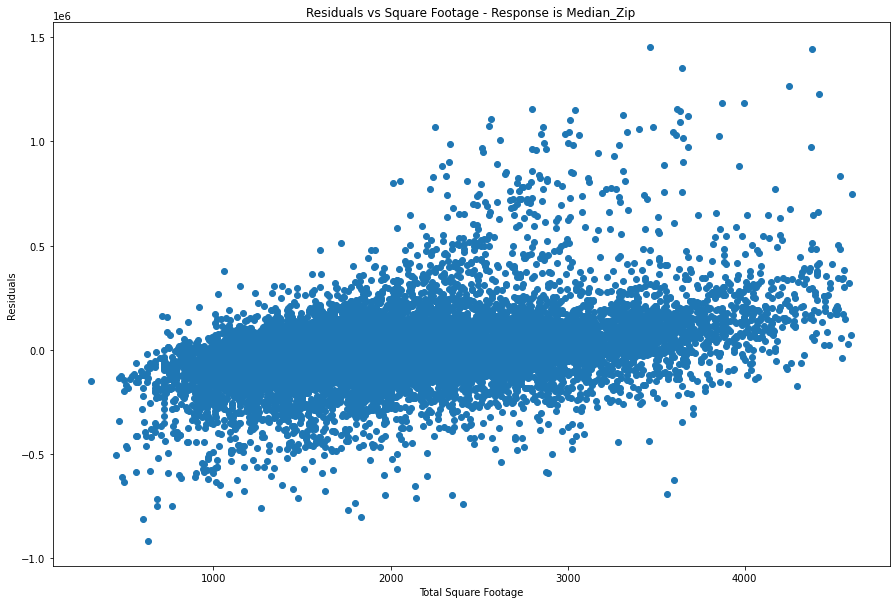

In [123]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['livingAreaSqFt']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Total Square Footage')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Square Footage - Response is Median_Zip')


plt.scatter(z, residuals, label="sample");

Regression on median zip, this time residuals plotted against school rating. This may not have the strong relationship we expected.

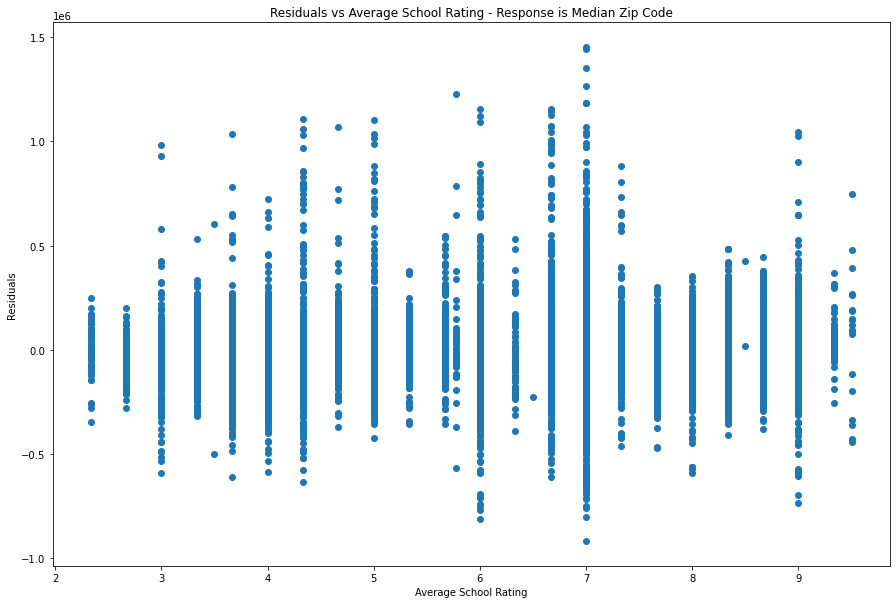

In [124]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['avgSchoolRating']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Average School Rating')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Average School Rating - Response is Median Zip Code')


plt.scatter(z, residuals, label="sample");

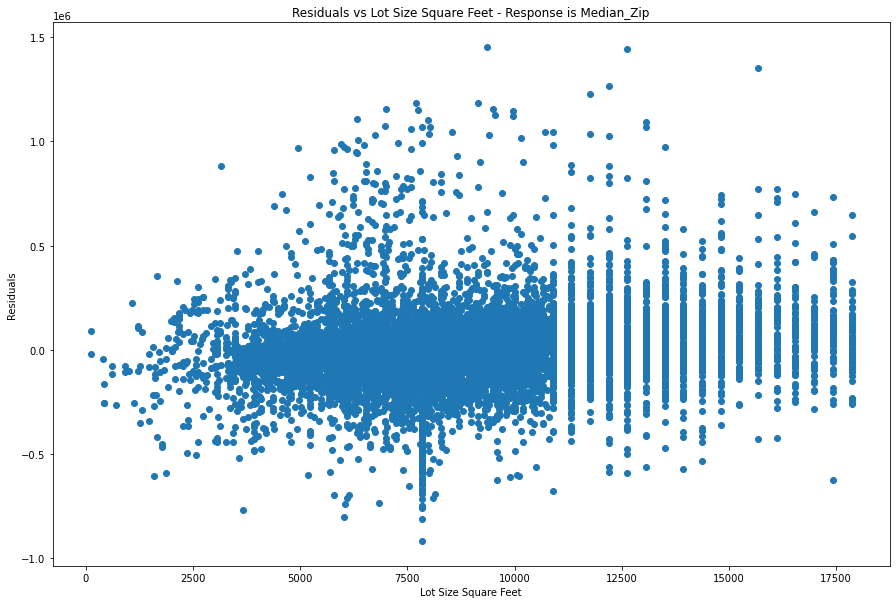

In [125]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['lotSizeSqFt']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Lot Size Square Feet')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Lot Size Square Feet - Response is Median_Zip')

plt.scatter(z, residuals, label="sample");

Interesting how past a certain lot size, larger rounded numbers are used instead of specific numbers. There does seem to be a relationship here.

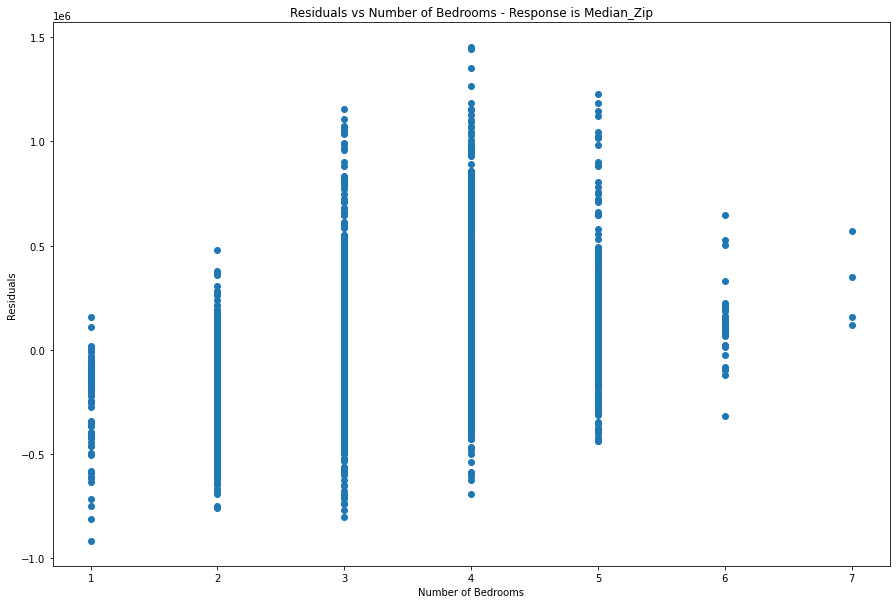

In [126]:
x, y = np.array(df['median_zip']).reshape(-1,1), df['price']
z = np.array(df['numOfBedrooms']).reshape(-1,1)

model = LinearRegression()
model.fit(x, y)

test_predictions = model.predict(x)

residuals = y - test_predictions

fig = plt.figure(figsize=(15,10))

# Add labels for x and y axes
plt.xlabel('Number of Bedrooms')
plt.ylabel('Residuals')

# Add a title for the plot
plt.title('Residuals vs Number of Bedrooms - Response is Median_Zip')

plt.scatter(z, residuals, label="sample");

If we can see a pattern when we plot residuals vs a different predictor, it can tell us if a feature might add value to our model.

## Linear Regressions

### Basic Model Top Features Only

We're going to build our most baseline model using only the top three features -
    
    * zipcode
    * avgSchoolRating
    * livingAreaSqFt
    * numOfBathrooms

We can identify top features from our correlation heat map. Here's a reminder of the top:

#### One-Hot Encoded Categoricals

In [127]:
# put together our basic feature set and preprocess

# one-hot encode categorical
base_cat = pd.DataFrame()
base_cat['zipcode'] = df['zipcode']
base_cat['zipcode'] = base_cat['zipcode'].astype('category')
base_cat_processed = pd.get_dummies(base_cat['zipcode'], prefix='zipcode', drop_first=True)
base_cat_processed.reset_index(inplace=True)
base_cat_processed.drop('index', axis=1, inplace=True)

# log transform and standard scale our continuous
base_cont = df[['avgSchoolRating', 'livingAreaSqFt', 'numOfBathrooms']]
#base_cont = np.log(base_cont)

scaler = StandardScaler()
base_cont_processed = pd.DataFrame(scaler.fit_transform(base_cont),columns = base_cont.columns)

#join cat and cont into predictor data frame
#x_base_set = pd.concat([base_cont_processed, base_cat_processed], axis=1)
x_base_set = base_cont_processed.join([base_cat_processed], how='inner') 

# train/test split
x_base_train, x_base_test = train_test_split(x_base_set, test_size=0.2, random_state=randomstate)

In [128]:
# run model for R^2 score

model = LinearRegression()
model.fit(x_base_train, y_train)
cv_5 = cross_val_score(model, x_base_train, y_train, cv=5)
r2 = cv_5.mean()
r2

0.7043007318063743

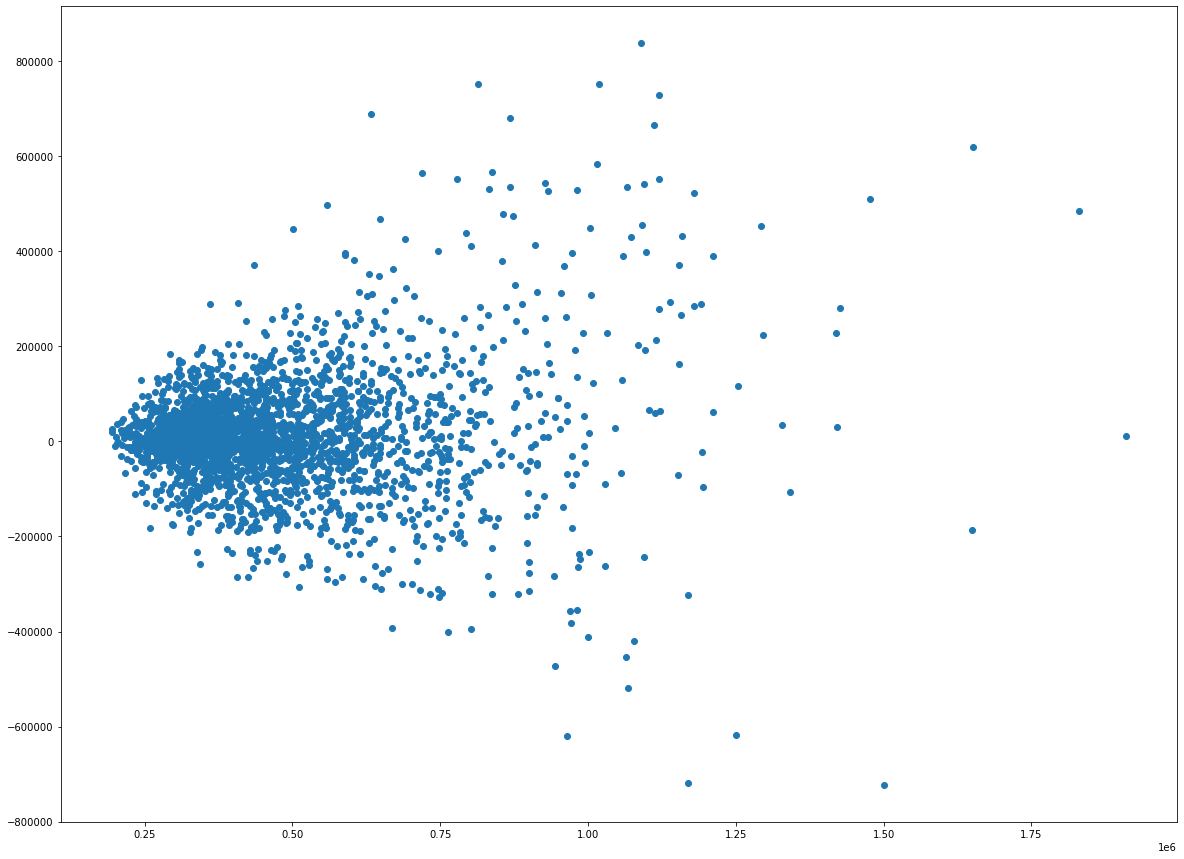

In [129]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(x_base_test)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions).astype(int)
test_predictions_unscaled = test_predictions_unscaled.flatten()

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);
# Residuals plot

In [130]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
mae

83429.59

In [131]:
# MAE for properties UNDER 500k

under500 = pd.DataFrame(list(zip(test_actual, test_predictions_unscaled)), columns =['actual', 'predictions'])
under500 = under500[under500['actual'] < 500000]
mae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)
mae500

59538.07

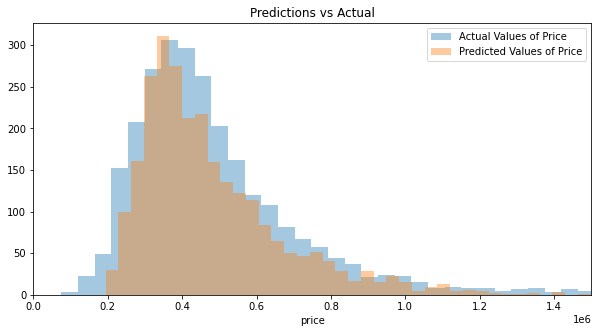

In [132]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(test_predictions_unscaled, hist=True, kde=False)
plt.title("Predictions vs Actual")
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,1500000);

In [133]:
# append our results to our lists

models['Models'].append('Bare Bones Features LR - One-Hot Zip')
models['r2'].append(r2)
models['mae'].append(mae)
models['mae_500'].append(mae500)
values['lin_pred'] = test_predictions_unscaled

Our baseline model has an R^2 of 70% on only a few features. Our MAE is pretty high. We will see if we can improve on that with some other feature selection methods, and even some other model types.

#### Target Encoded Categoricals

In [134]:
# put together our basic feature set and preprocess

# log transform and standard scale our continuous
base_cont = train_data[['avgSchoolRating', 'livingAreaSqFt', 'numOfBathrooms', 'zip_smooth']]
scaler = StandardScaler()
x_base_train = pd.DataFrame(scaler.fit_transform(base_cont),columns = base_cont.columns)


test_cont = holdout[['avgSchoolRating', 'livingAreaSqFt', 'numOfBathrooms', 'zip_smooth']]
scaler = StandardScaler()
x_base_test = pd.DataFrame(scaler.fit_transform(test_cont),columns = test_cont.columns)

In [135]:
# run model for R^2 score

model = LinearRegression()
model.fit(x_base_train, y_train)
cv_5 = cross_val_score(model, x_base_train, y_train, cv=5)
r2 = cv_5.mean()
r2

0.6105315044021117

Our R-squared of 60.5% is much lower than when we used our zip code as categoricals.

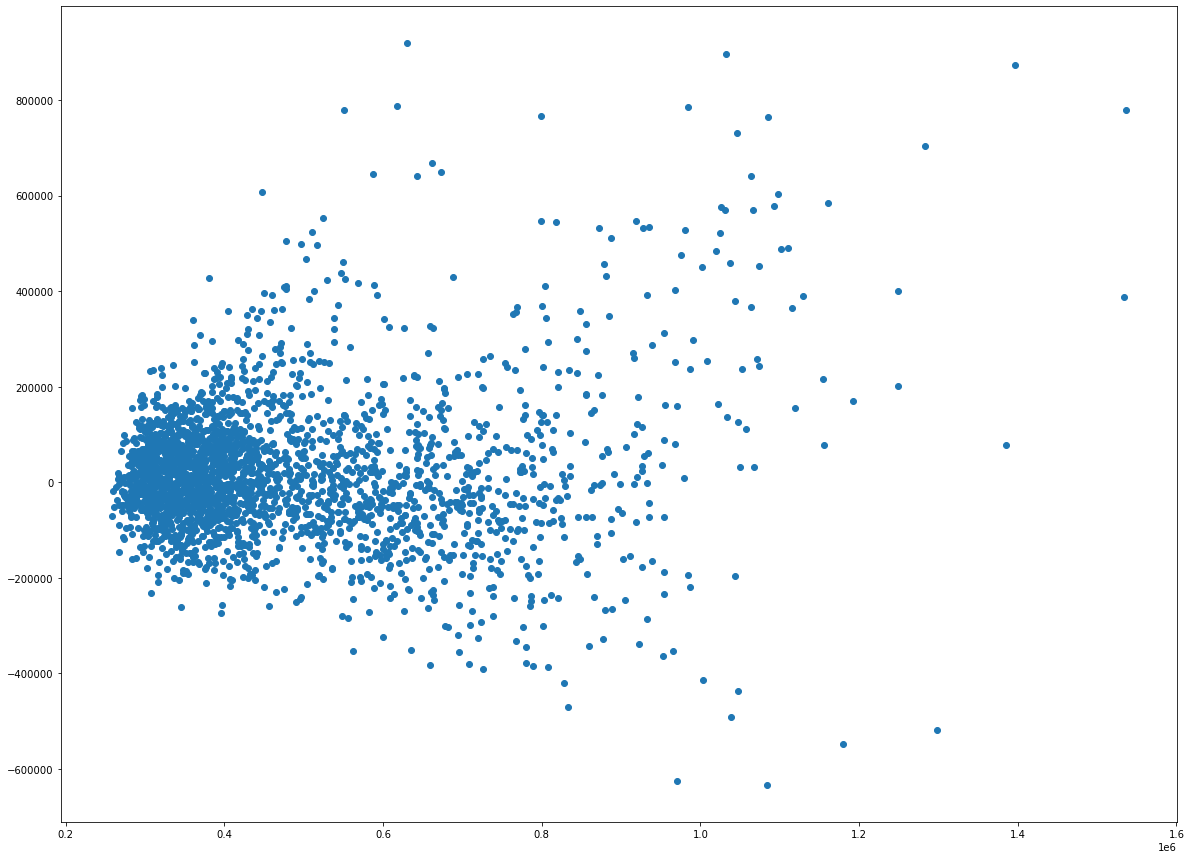

In [136]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(x_base_test)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions).flatten().astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);
# Residuals plot

In [137]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
mae

100227.1

In [138]:
# MAE for properties UNDER 500k

under500 = pd.DataFrame(list(zip(test_actual, test_predictions_unscaled)), columns =['actual', 'predictions'])
under500 = under500[under500['actual'] < 500000]
mae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)
mae500

71143.49

In [139]:
# append our results to our lists

models['Models'].append('Bare Bones Features LR - Encoded Zip')
models['r2'].append(r2)
models['mae'].append(mae)
models['mae_500'].append(mae500)
values['lin_pred'] = test_predictions_unscaled

### Linear Regression Model - ALL Features

#### One Hot Set

Run a base model with no cross-validation or specific feature selection with ALL possible features. We're going to use our one-hot encoded set which performed better in our first test.

In [140]:
predictors_train = sm.add_constant(X_train_onehot)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     122.5
Date:                Tue, 25 May 2021   Prob (F-statistic):               0.00
Time:                        22:31:26   Log-Likelihood:                 2005.1
No. Observations:               10489   AIC:                            -3384.
Df Residuals:                   10176   BIC:                            -1112.
Df Model:                         312                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         12.5926      0.054    234.891      0.000      12.487      12.698
numPriceChanges               -0.0638      0.002    -30.235      0.000      -0.068      -0.060
lotSizeSqFt                    0.0274      0.003      9.878      0.000       0.022       0.033
livingAreaSqFt                 0.2188      0.005     46.950      0.000       0.210       0.228
avgSchoolDistance              0.0121      0.003      3.952      0.000       0.006       0.018
avgSchoolRating                0.0615      0.005     11.866      0.000       0.051       0.072
avgSchoolSize                 -0.0281      0.005     -5.251      0.000      -0.039      -0.018
numOfBedrooms                  0.0012      0.003      0.387      0.699      -0.005       0.007
numOfStories                  -0.0192      0.003     -7.190      0.000      -0.024      -0.014
numOfPhotos                    0.0204      0.002      8.601      0.000       0.016       0.025
numOfAppliances                0.0028      0.002      1.305      0.192      -0.001       0.007
zipcode_78660                  0.1298      0.048      2.690      0.007       0.035       0.224
zipcode_78701                  0.9974      0.098     10.128      0.000       0.804       1.190
zipcode_78702                  0.6491      0.035     18.421      0.000       0.580       0.718
zipcode_78703                  1.0183      0.034     29.601      0.000       0.951       1.086
zipcode_78704                  0.9430      0.032     29.616      0.000       0.881       1.005
zipcode_78705                  0.7242      0.045     15.964      0.000       0.635       0.813
zipcode_78717                  0.5099      0.048     10.706      0.000       0.417       0.603
zipcode_78721                  0.4400      0.036     12.225      0.000       0.369       0.511
zipcode_78722                  0.6121      0.039     15.523      0.000       0.535       0.689
zipcode_78723                  0.5136      0.032     15.847      0.000       0.450       0.577
zipcode_78724                  0.1630      0.035      4.671      0.000       0.095       0.231
zipcode_78725                  0.0152      0.033      0.456      0.648      -0.050       0.080
zipcode_78726                  0.2674      0.036      7.363      0.000       0.196       0.339
zipcode_78727                  0.3584      0.032     11.294      0.000       0.296       0.421
zipcode_78728                  0.2468      0.034      7.180      0.000       0.179       0.314
zipcode_78729                  0.5477      0.046     11.794      0.000       0.457       0.639
zipcode_78730                  0.5040      0.039     12.968      0.000       0.428       0.580
zipcode_78731                  0.7390      0.033     22.286      0.000       0.674       0.804
zipcode_78732                  0.2821      

There is a multicollinearity of features in our feature set somewhere. Let's check.

The correlations it picked up are circumstancial.

There are a good number of features included in this model with a p-value over .05, meaning there is a greater than 5% chance that the results are due to randomness of the sample rather than the feature. A lot of our features have a very low p-value which indicates a very low chance that these results are not affected by the feature. 

Now we perform cross-validation with our base model over 5 splits and get our mean R^2.

In [141]:
model = LinearRegression()
model.fit(X_train_onehot, y_train)
cv_5 = cross_val_score(model, X_train_onehot, y_train, cv=5)
r2 = cv_5.mean()
r2

0.7750726168190529

In [142]:
# How many predictors are in our base model?
print("{} predictors used for this model".format(X_train_onehot.shape[1]))

315 predictors used for this model


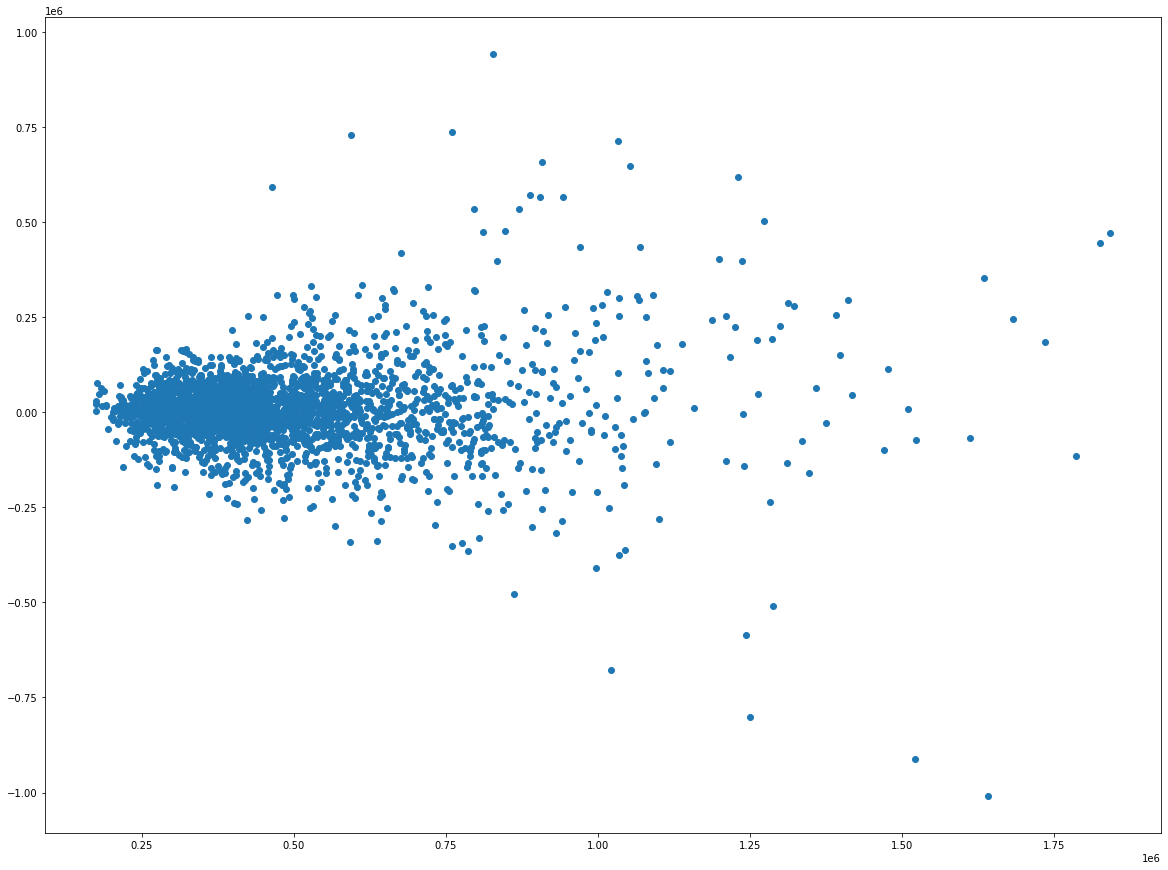

In [143]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(X_test_onehot)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions)
test_predictions_unscaled = test_predictions_unscaled.flatten().astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);

# Residuals plot

In [144]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
mae

70484.53

In [145]:
# MAE for properties UNDER 500k

under500 = pd.DataFrame(list(zip(test_actual, test_predictions_unscaled)), columns =['actual', 'predictions'])
under500 = under500[under500['actual'] < 500000]
mae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)
mae500

51295.61

In [146]:
# append our results to our lists

models['Models'].append('Basic LR - One-Hot')
models['r2'].append(r2)
models['mae'].append(mae)
models['mae_500'].append(mae500)
values['lin_pred'] = test_predictions_unscaled

##### Study Residuals

In [147]:
# We need our statsmodels model again to plot residuals
predictors_train = sm.add_constant(X_train_onehot)
model = sm.OLS(y_train, predictors_train).fit()

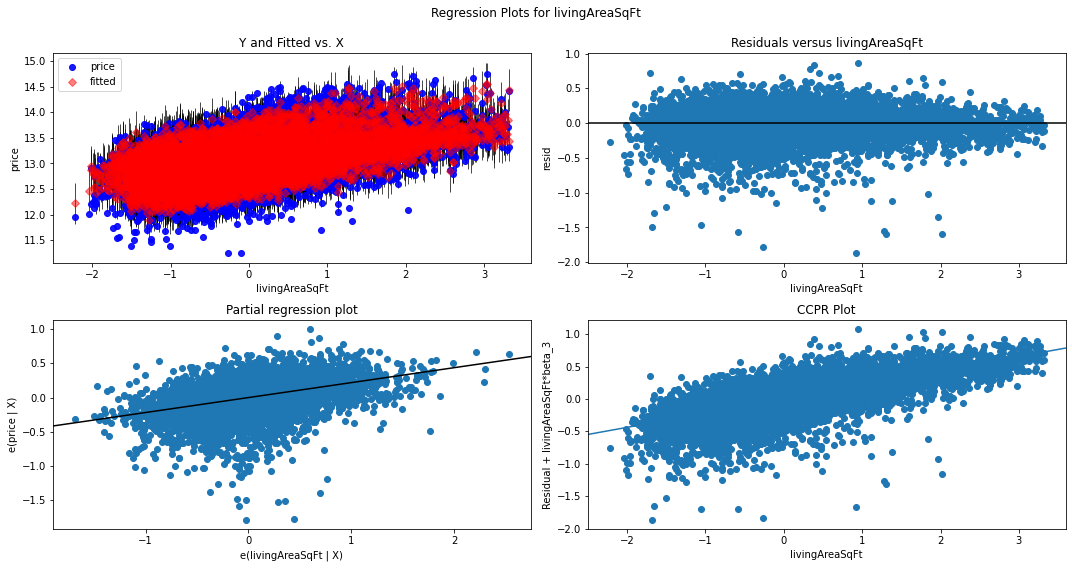

In [148]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "livingAreaSqFt", fig=fig)
plt.show()

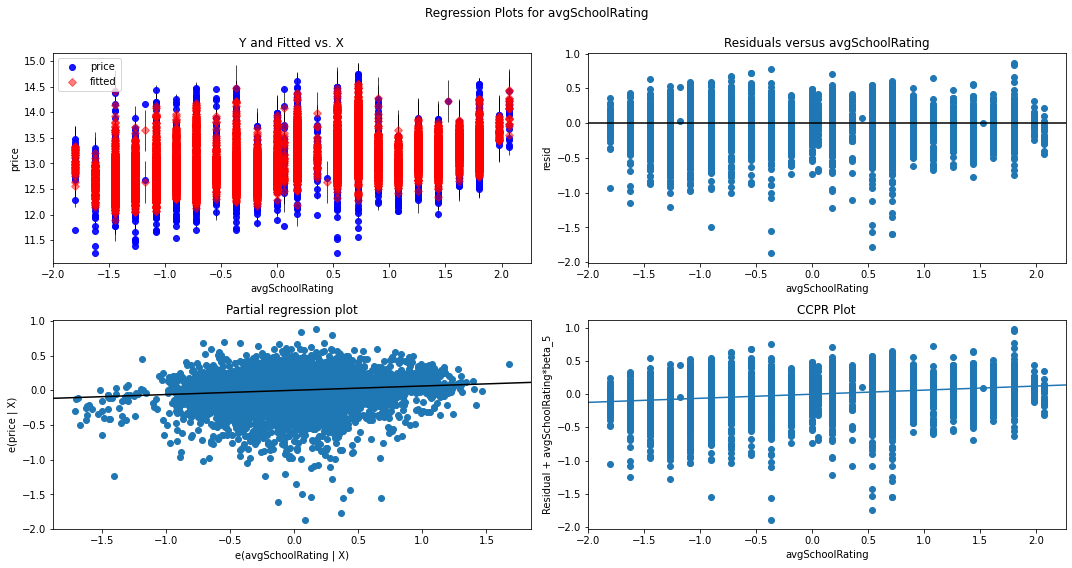

In [149]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "avgSchoolRating", fig=fig)
plt.show()

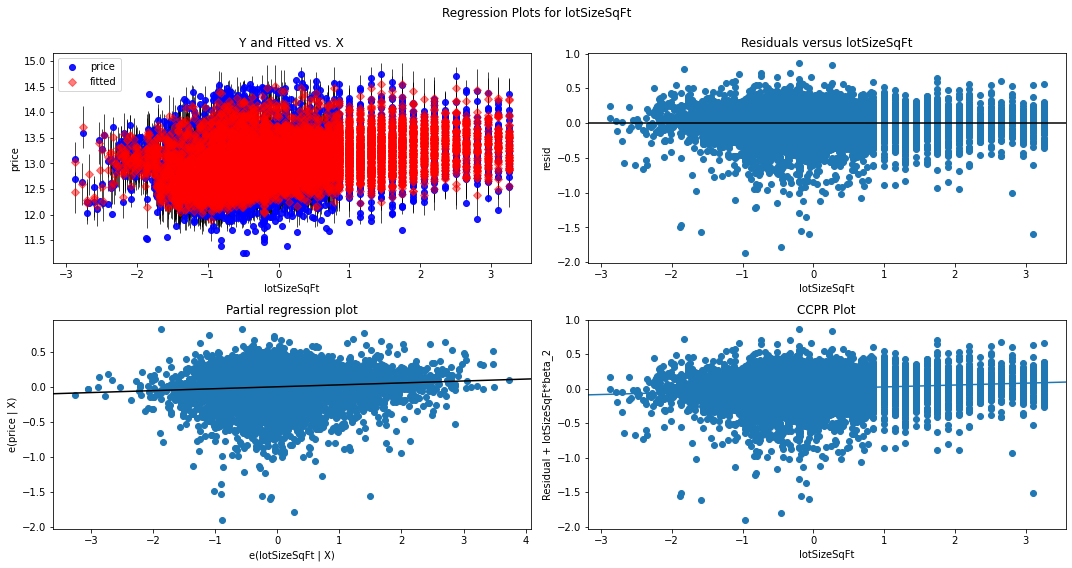

In [150]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "lotSizeSqFt", fig=fig)
plt.show()

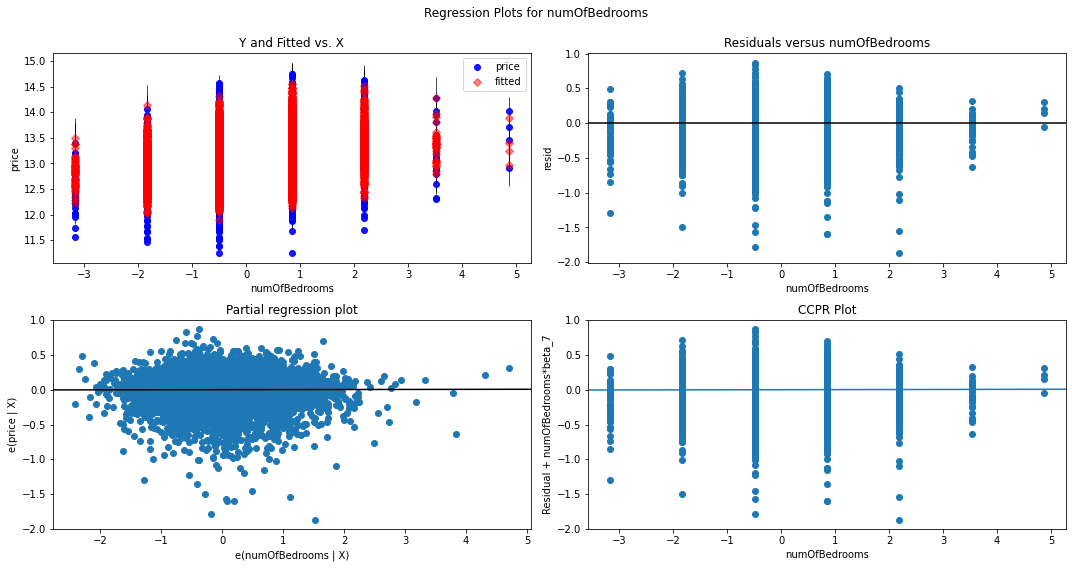

In [151]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "numOfBedrooms", fig=fig)
plt.show()

#### Target Encoded Categoricals

Run a base model with no cross-validation or specific feature selection with ALL possible features. We're using our target categorical encoded set which performed worse in our first test.

In [152]:
predictors_train = sm.add_constant(X_train_encoded)
model = sm.OLS(y_train, predictors_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     128.3
Date:                Tue, 25 May 2021   Prob (F-statistic):               0.00
Time:                        22:31:32   Log-Likelihood:                 1052.7
No. Observations:               10489   AIC:                            -1629.
Df Residuals:                   10251   BIC:                             98.11
Df Model:                         237                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         12.9054      0.046    283.427      0.000      12.816      12.995
numPriceChanges               -0.0610      0.002    -26.844      0.000      -0.065      -0.057
lotSizeSqFt                    0.0219      0.003      7.800      0.000       0.016       0.027
livingAreaSqFt                 0.2037      0.005     42.752      0.000       0.194       0.213
avgSchoolDistance             -0.0017      0.003     -0.617      0.537      -0.007       0.004
avgSchoolRating                0.0704      0.004     18.586      0.000       0.063       0.078
avgSchoolSize                 -0.0578      0.004    -15.527      0.000      -0.065      -0.051
numOfBedrooms                 -0.0074      0.003     -2.255      0.024      -0.014      -0.001
numOfStories                  -0.0088      0.003     -3.114      0.002      -0.014      -0.003
numOfPhotos                    0.0195      0.003      7.607      0.000       0.014       0.024
numOfAppliances                0.0064      0.002      2.731      0.006       0.002       0.011
zip_smooth                     0.1490      0.004     36.975      0.000       0.141       0.157
year_smooth                    0.0476      0.003     18.797      0.000       0.043       0.053
month_smooth                   0.0396      0.002     16.905      0.000       0.035       0.044
lat_long                       0.0350      0.004      9.471      0.000       0.028       0.042
month1                        -0.0042      0.003     -1.621      0.105      -0.009       0.001
hasAssociation_1              -0.1170      0.006    -18.379      0.000      -0.129      -0.105
hasCooling_1                   0.0079      0.024      0.323      0.747      -0.040       0.056
hasHeating_1                   0.0658      0.033      2.024      0.043       0.002       0.130
hasSpa_1                       0.0284      0.010      2.969      0.003       0.010       0.047
hasView_1                     -0.0011      0.006     -0.189      0.850      -0.012       0.010
accessibility_1                0.0763      0.025      3.061      0.002       0.027       0.125
patioporch_1                   0.0400      0.006      6.659      0.000       0.028       0.052
numOfSchools_2                 0.1450      0.042      3.416      0.001       0.062       0.228
numOfSchools_3                 0.0585      0.038      1.542      0.123      -0.016       0.133
numOfSchools_4                -0.0816      0.040     -2.059      0.040      -0.159      -0.004
security_1                     0.0079      0.006      1.302      0.193      -0.004       0.020
waterfront_1                   0.1061      0.065      1.639      0.101      -0.021       0.233
windowfeatures_1              -0.0042      0.007     -0.629      0.529      -0.017       0.009
community_1                   -0.0238      

In [153]:
model = LinearRegression()
model.fit(X_train_encoded, y_train)
cv_5 = cross_val_score(model, X_train_encoded, y_train, cv=5)
r2 = cv_5.mean()
r2

-24183280992.760357

In [154]:
# How many predictors are in our base model?
print("{} predictors used for this model".format(X_train_encoded.shape[1]))

240 predictors used for this model


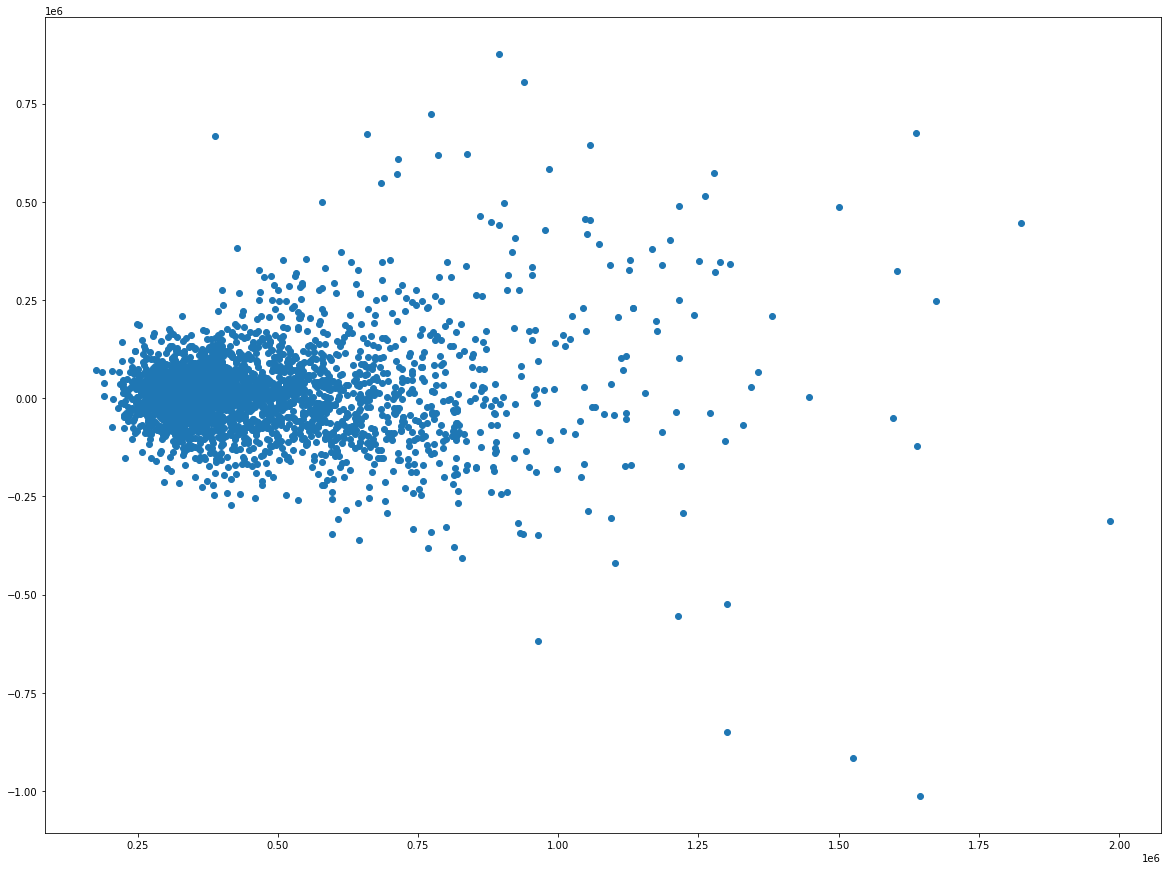

In [155]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(X_test_encoded)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions)
test_predictions_unscaled = test_predictions_unscaled.flatten().astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);

# Residuals plot

In [156]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
mae

81321.19

In [157]:
# MAE for properties UNDER 500k

under500 = pd.DataFrame(list(zip(test_actual, test_predictions_unscaled)), columns =['actual', 'predictions'])
under500 = under500[under500['actual'] < 500000]
mae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)
mae500

58440.37

In [158]:
# append our results to our lists

models['Models'].append('Basic LR - Encoded')
models['r2'].append(r2)
models['mae'].append(mae)
models['mae_500'].append(mae500)
values['lin_pred'] = test_predictions_unscaled

## Linear Regression - Feature Selectors

Feature selectors are different methods to help us pick which features we want to use in our model. In our example above where we used ALL predictors in our linear regression, several of our features had a p-value over .05, which indicates that there is more than a 5% chance that the changes attributed to that feature were actually by random chance. We want features where our p-value is below a threshold that we specify where we are reasonably confident that the feature is contributing to the model and not by random chance.

### Permutation Importance

In [159]:
'''model = LinearRegression()
model.fit(X_train_onehot, y_train)

from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_train_onehot, y_train,
                           n_repeats=15,
                            random_state=0,
                          n_jobs=-1)'''

'model = LinearRegression()\nmodel.fit(X_train_onehot, y_train)\n\nfrom sklearn.inspection import permutation_importance\nr = permutation_importance(model, X_train_onehot, y_train,\n                           n_repeats=15,\n                            random_state=0,\n                          n_jobs=-1)'

In [160]:
'''for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        print(f"{X_train_onehot.columns[i]:<8} "
            f"\t\tImportance: {r.importances_mean[i]:.3f} ")'''

'for i in r.importances_mean.argsort()[::-1]:\n    if r.importances_mean[i] >= 0.001:\n        print(f"{X_train_onehot.columns[i]:<8} "\n            f"\t\tImportance: {r.importances_mean[i]:.3f} ")'

In [161]:
'''importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        importances[X_train_onehot.columns[i]] = r.importances_mean[i]
    else: continue
        
importances

important_features_again = list(importances.keys())
important_features_again  '''

'importances = {}\n\nfor i in r.importances_mean.argsort()[::-1]:\n    if r.importances_mean[i] >= 0.001:\n        importances[X_train_onehot.columns[i]] = r.importances_mean[i]\n    else: continue\n        \nimportances\n\nimportant_features_again = list(importances.keys())\nimportant_features_again  '

In [162]:
important_features_again  = ['livingAreaSqFt',
 'zipcode_78704',
 'zipcode_78703',
 'zipcode_78731',
 'zipcode_78757',
 'zipcode_78745',
 'zipcode_78702',
 'zipcode_78717',
 'zipcode_78759',
 'zipcode_78723',
 'zipcode_78749',
 'zipcode_78729',
 'zipcode_78748',
 'zipcode_78756',
 'zipcode_78746',
 'zipcode_78750',
 'zipcode_78739',
 'propertyTaxRate_2.21',
 'zipcode_78751',
 'zipcode_78735',
 'numPriceChanges',
 'avgSchoolRating',
 'zipcode_78727',
 'zipcode_78721',
 'zipcode_78758',
 'zipcode_78722',
 'zipcode_78732',
 'zipcode_78733',
 'zipcode_78741',
 'zipcode_78705',
 'zipcode_78752',
 'zipcode_78730',
 'zipcode_78737',
 'hasAssociation_1',
 'year_block_13',
 'latest_salemonth_11',
 'latest_salemonth_12',
 'zipcode_78753',
 'zipcode_78736',
 'year_block_11',
 'zipcode_78726',
 'year_block_8',
 'zipcode_78728',
 'year_block_18',
 'year_block_16',
 'latest_salemonth_10',
 'avgSchoolSize',
 'year_block_9',
 'lotSizeSqFt',
 'year_block_6',
 'year_block_15',
 'year_block_7',
 'year_block_10',
 'latest_salemonth_9',
 'year_block_20',
 'zipcode_78744',
 'year_block_4',
 'year_block_21',
 'year_block_14',
 'latest_salemonth_8',
 'vault',
 'zipcode_78701',
 'mid century',
 'year_block_12',
 'latest_salemonth_7',
 'zipcode_78724',
 'propertyTaxRate_2.01',
 'year_block_17',
 'year_block_19',
 'numOfPhotos',
 'numOfStories',
 'condo',
 'year_block_22',
 'year_block_23',
 'stainless steel',
 'default',
 'vault ceiling',
 'year_block_3',
 'cul de',
 'patioporch_1',
 'year_block_5',
 'year_block_24',
 'zipcode_78747',
 'steel',
 'de',
 'numOfSchools_3',
 'hill country',
 'quartz',
 'dryer',
 'design',
 'curb',
 'latest_salemonth_6',
 'century',
 'washer dryer',
 'year_block_2',
 'curb appeal',
 'distance',
 'year_block_26',
 'year_block_25',
 'numOfSchools_2',
 'avgSchoolDistance',
 'large corner',
 'hike bike',
 'large corner lot',
 'hill',
 'great',
 'walk distance',
 'award win',
 'lot natural light',
 'corner lot']

In [163]:
permutation_x_train = X_train_onehot[important_features_again]
permutation_x_test = X_test_onehot[important_features_again]

model = LinearRegression()
model.fit(permutation_x_train, y_train)
cv_5 = cross_val_score(model, permutation_x_train, y_train, cv=5)
r2 = cv_5.mean()
r2

0.7703580769140129

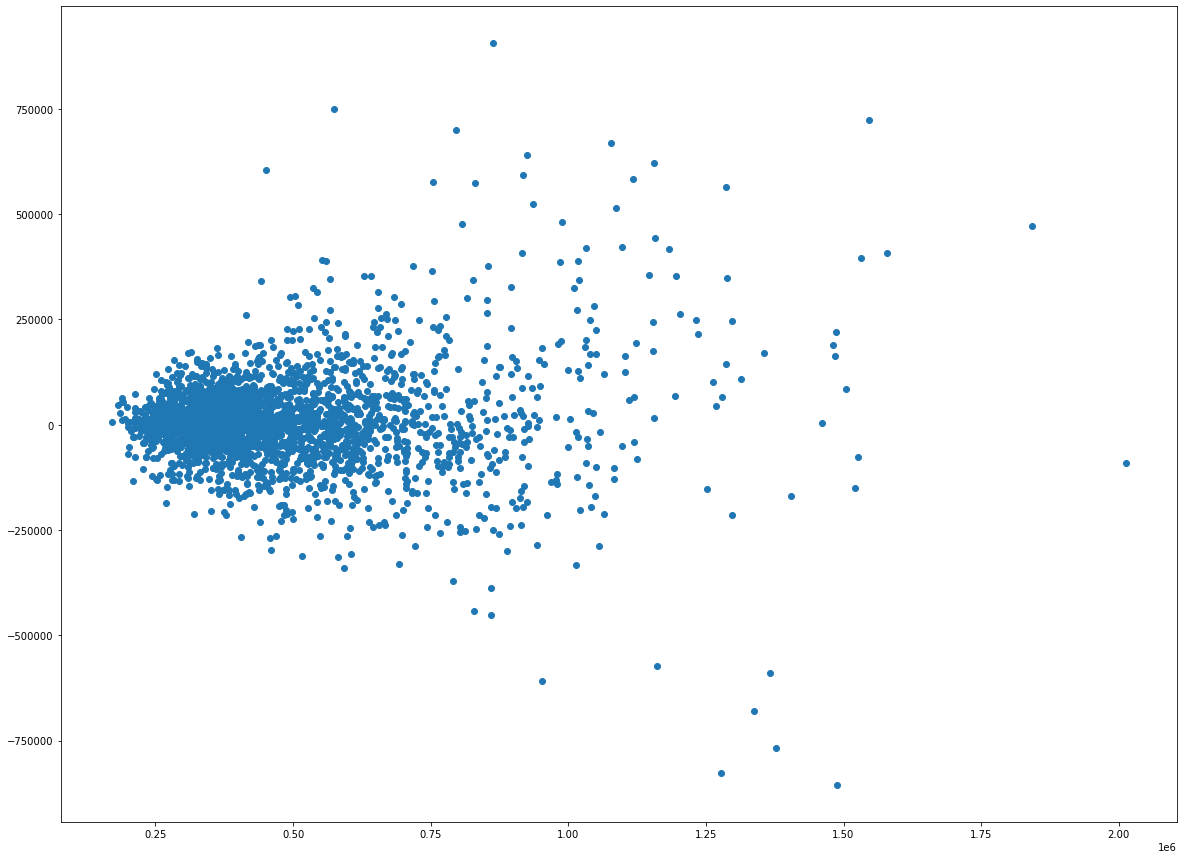

In [164]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(permutation_x_test)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions)
test_predictions_unscaled = test_predictions_unscaled.flatten().astype(int)

# get residuals
residuals = test_actual - test_predictions_unscaled

fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_unscaled, residuals);

# Residuals plot

In [165]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
mae

72557.09

In [166]:
# MAE for properties UNDER 500k

under500 = pd.DataFrame(list(zip(test_actual, test_predictions_unscaled)), columns =['actual', 'predictions'])
under500 = under500[under500['actual'] < 500000]
mae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)
mae500

52288.59

In [167]:
# append our results to our lists

models['Models'].append('LR - Permutation Importance')
models['r2'].append(r2)
models['mae'].append(mae)
models['mae_500'].append(mae500)
values['lin_pred'] = test_predictions_unscaled

### Forward-Backward Selector

First we'll try a simple forward-backward feature selection model based on p-value, using a statsmodel OLS linear regression model. This selector starts with zero features, internally runs the model for each feature individually, and adds the lowest p-value feature to its list to include. It then runs the model again with the original feature included and tries adding each other feature individually. It will either add the next best feature under the threshold or remove an existing feature if it is no longer within the threshold. This process iterates until all features in the model are under the p-value threshold.

This model takes quite some time to run, so is commented out with the results replicated in markdown following.

In [168]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = included[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included



In [169]:

#result = stepwise_selection(X_train_onehot, y_train, verbose=True)

#print('resulting features:', result)


result = ['avgSchoolRating', 'livingAreaSqFt', 'hasAssociation_1', 'zipcode_78704', 'zipcode_78703', 'avgSchoolSize', 'numPriceChanges', 'zipcode_78731', 'zipcode_78754', 'propertyTaxRate_2.01', 'propertyTaxRate_2.21', 'zipcode_78757', 'zipcode_78746', 'zipcode_78756', 'zipcode_78702', 'zipcode_78735', 'zipcode_78723', 'year_block_30', 'zipcode_78747', 'year_block_29', 'year_block_28', 'lotSizeSqFt', 'zipcode_78751', 'numOfPhotos', 'zipcode_78705', 'zipcode_78725', 'zipcode_78722', 'zipcode_78759', 'great', 'condo', 'quartz', 'design', 'zipcode_78750', 'year_block_27', 'avgSchoolDistance', 'numOfStories', 'latest_salemonth_12', 'patioporch_1', 'latest_salemonth_11', 'latest_salemonth_10', 'latest_salemonth_9', 'zipcode_78701', 'latest_salemonth_8', 'latest_salemonth_7', 'zipcode_78745', 'hasSpa_1', 'zipcode_78730', 'year_block_26', 'dryer', 'zipcode_78733', 'latest_salemonth_6', 'garageSpaces_4', 'investment', 'zipcode_78721', 'zipcode_78752', 'zipcode_78741', 'parking', 'zipcode_78749', 'walkable', 'convenient', 'congress', 'latest_salemonth_5', 'accessibility_1', 'garageSpaces_1', 'luxury', 'classic', 'hasHeating_1', 'zipcode_78729', 'zipcode_78717', 'year_block_13', 'wine', 'default', 'appliance', 'view', 'indoor', 'zipcode_78739', 'detach', 'floor', 'laminate', 'zilker', 'finish', 'hill', 'hill country', 'medium', 'addition', 'zipcode_78758', 'zipcode_78727', 'zipcode_78748', 'zipcode_78736', 'zipcode_78732', 'zipcode_78728', 'zipcode_78726', 'year_block_24', 'year_block_11', 'hike bike']

In [170]:
# Run our linear regression again, using only the features recommended by our feature selector

X_train_refined = X_train_onehot[result]
X_test_refined = X_test_onehot[result]

predictors_int = sm.add_constant(X_train_refined)
model = sm.OLS(y_train, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     386.8
Date:                Tue, 25 May 2021   Prob (F-statistic):               0.00
Time:                        22:31:34   Log-Likelihood:                 1757.2
No. Observations:               10489   AIC:                            -3322.
Df Residuals:                   10393   BIC:                            -2626.
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.7032      0.024    530.062      0.000      12.656      12.750
avgSchoolRating          0.0751      0.005     15.554      0.000       0.066       0.085
livingAreaSqFt           0.2253      0.004     62.178      0.000       0.218       0.232
hasAssociation_1        -0.0735      0.006    -11.919      0.000      -0.086      -0.061
zipcode_78704            0.8397      0.013     62.522      0.000       0.813       0.866
zipcode_78703            0.9352      0.018     51.417      0.000       0.900       0.971
avgSchoolSize           -0.0421      0.005     -9.082      0.000      -0.051      -0.033
numPriceChanges         -0.0623      0.002    -29.838      0.000      -0.066      -0.058
zipcode_78731            0.5967      0.016     37.638      0.000       0.566       0.628
zipcode_78754           -0.1512      0.015    -10.069      0.000      -0.181      -0.122
propertyTaxRate_2.01    -0.0513      0.019     -2.696      0.007      -0.089      -0.014
propertyTaxRate_2.21    -0.2995      0.035     -8.539      0.000      -0.368      -0.231
zipcode_78757            0.5124      0.014     36.185      0.000       0.485       0.540
zipcode_78746            0.7041      0.027     26.469      0.000       0.652       0.756
zipcode_78756            0.6895      0.023     30.504      0.000       0.645       0.734
zipcode_78702            0.5436      0.016     33.512      0.000       0.512       0.575
zipcode_78735            0.4177      0.020     21.268      0.000       0.379       0.456
zipcode_78723            0.3660      0.013     27.558      0.000       0.340       0.392
year_block_30            0.1855      0.015     12.467      0.000       0.156       0.215
zipcode_78747           -0.0369      0.015     -2.531      0.011      -0.065      -0.008
year_block_29            0.1602      0.012     13.379      0.000       0.137       0.184
year_block_28            0.1459      0.011     13.088      0.000       0.124       0.168
lotSizeSqFt              0.0259      0.003      9.902      0.000       0.021       0.031
zipcode_78751            0.5351      0.021     25.057      0.000       0.493       0.577
numOfPhotos              0.0223      0.002      9.778      0.000       0.018       0.027
zipcode_78705            0.6482      0.033     19.638      0.000       0.584       0.713
zipcode_78725           -0.1097      0.022     -4.998      0.000      -0.153      -0.067
zipcode_78722            0.5204      0.025     20.542      0.000       0.471       0.570
zipcode_78759            0.3557      0.015     23.043      0.000       0.325       0.386
great                   -0.2518      0.041     -6.103      0.000      -0.333      -0.171
condo                   -0.7114      0.071     -9.970      0.000      -0.851      -0.572
quartz                   0.4692      0.063      7.395    

In [171]:
print("{} predictors used".format(len(result)))

95 predictors used


In [172]:
model = LinearRegression()
model.fit(X_train_refined, y_train)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

cv_5 = cross_val_score(model, X_train_refined, y_train, cv=cv)
r2 = cv_5.mean()
r2

0.7736264481805483

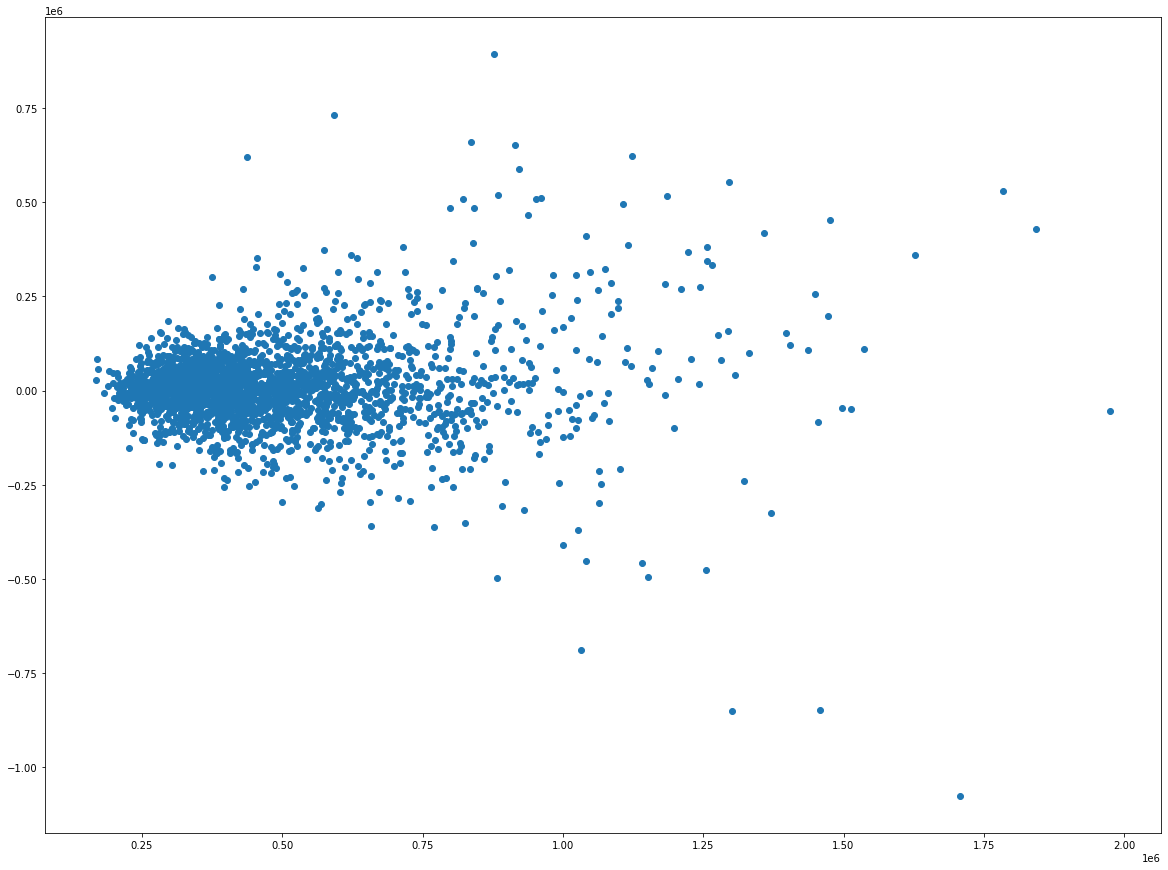

In [173]:
# apply our model to our test set and get predicted values
test_predictions_refined = model.predict(X_test_refined)

# reverse log transform our predicted values
test_predictions_refined_unscaled = np.exp(test_predictions_refined)
test_predictions_refined_unscaled=test_predictions_refined_unscaled.flatten()

# get residuals
residuals = test_actual - test_predictions_refined_unscaled

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(test_predictions_refined_unscaled, residuals)

In [174]:
# get mean absolute error
mae = round(mean_absolute_error(test_actual, test_predictions_refined_unscaled), 2)
mae

70644.14

In [175]:
# MAE for properties UNDER 500k

under500 = pd.DataFrame(list(zip(test_actual, test_predictions_refined_unscaled)), columns =['actual', 'predictions'])
under500 = under500[under500['actual'] < 500000]
mae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)
mae500

51482.46

In [176]:
# append our results to our lists

models['Models'].append('Forw-Back Selector')
models['r2'].append(r2)
models['mae'].append(mae)
models['mae_500'].append(mae500)
values['forw_back_pred'] = test_predictions_refined_unscaled

### Recursive Feature Elimination with Cross Validation - Linear Regression

RFECV is a reverse forward-backward selector. It starts the model with all features in use then removes the weakest one, and iterates until the best feature set is found. It uses integrated cross-validation to determine the optimal set of features in the model with the best cross-validated score. We score on mean absolute error.

In [177]:
# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

model = LinearRegression(n_jobs=-4)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-4)

# fit model to train set
rfecv.fit(X_train_onehot, y_train)

# print optimal number of features
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 213


In [178]:
dset = pd.DataFrame()
dset['attr'] = X_train_onehot.columns
dset['used'] = rfecv.support_

# make a list of the features used in the rfecv
rfecv_result = list(dset[(dset['used'] == True)]['attr'])

# Show the features that RFECV did not use
dset[dset['used']==False]

attr   used
1          lotSizeSqFt  False
3    avgSchoolDistance  False
4      avgSchoolRating  False
5        avgSchoolSize  False
6        numOfBedrooms  False
..                 ...    ...
302              stone  False
307           warranty  False
310             walnut  False
313        subway tile  False
314            concept  False

[102 rows x 2 columns]

In [179]:
# Run our linear regression again in statsmodels, using the features recommended by our feature selector

X_train_rfecv = X_train_onehot[rfecv_result]
X_test_rfecv = X_test_onehot[rfecv_result]

predictors_int = sm.add_constant(X_train_rfecv)
model = sm.OLS(y_train, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     161.4
Date:                Tue, 25 May 2021   Prob (F-statistic):               0.00
Time:                        22:32:35   Log-Likelihood:                 1513.6
No. Observations:               10489   AIC:                            -2601.
Df Residuals:                   10276   BIC:                            -1055.
Df Model:                         212                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         12.5493      0.025    505.905      0.000      12.501      12.598
numPriceChanges               -0.0648      0.002    -30.189      0.000      -0.069      -0.061
livingAreaSqFt                 0.2317      0.003     69.241      0.000       0.225       0.238
zipcode_78660                  0.1587      0.044      3.626      0.000       0.073       0.245
zipcode_78701                  1.1260      0.098     11.465      0.000       0.933       1.319
zipcode_78702                  0.7453      0.022     34.023      0.000       0.702       0.788
zipcode_78703                  1.1253      0.024     46.900      0.000       1.078       1.172
zipcode_78704                  1.0235      0.021     49.135      0.000       0.983       1.064
zipcode_78705                  0.8526      0.037     23.130      0.000       0.780       0.925
zipcode_78717                  0.6872      0.042     16.452      0.000       0.605       0.769
zipcode_78721                  0.5222      0.024     21.938      0.000       0.476       0.569
zipcode_78722                  0.7475      0.030     24.640      0.000       0.688       0.807
zipcode_78723                  0.5916      0.021     28.093      0.000       0.550       0.633
zipcode_78724                  0.2206      0.023      9.442      0.000       0.175       0.266
zipcode_78726                  0.4418      0.026     17.073      0.000       0.391       0.493
zipcode_78727                  0.4689      0.021     21.852      0.000       0.427       0.511
zipcode_78728                  0.3294      0.025     13.344      0.000       0.281       0.378
zipcode_78729                  0.6662      0.042     16.048      0.000       0.585       0.748
zipcode_78730                  0.6777      0.030     22.316      0.000       0.618       0.737
zipcode_78731                  0.8818      0.022     40.188      0.000       0.839       0.925
zipcode_78732                  0.4858      0.023     21.022      0.000       0.441       0.531
zipcode_78733                  0.7530      0.029     25.841      0.000       0.696       0.810
zipcode_78735                  0.6614      0.026     25.144      0.000       0.610       0.713
zipcode_78736                  0.4700      0.028     17.011      0.000       0.416       0.524
zipcode_78737                  0.3748      0.021     17.598      0.000       0.333       0.417
zipcode_78739                  0.5369      0.020     26.213      0.000       0.497       0.577
zipcode_78741                  0.4541      0.024     18.654      0.000       0.406       0.502
zipcode_78744                  0.1926      0.020      9.457      0.000       0.153       0.233
zipcode_78745                  0.5066      0.019     26.153      0.000       0.469       0.545
zipcode_78746                  1.0314      

In [180]:
# getting the r2 score of our best feature set
r2 = model.rsquared
r2

0.7690517009572668

RFECV still includes features with a p-value over .05. Overall though, accuracy is higher than other feature selection methods.


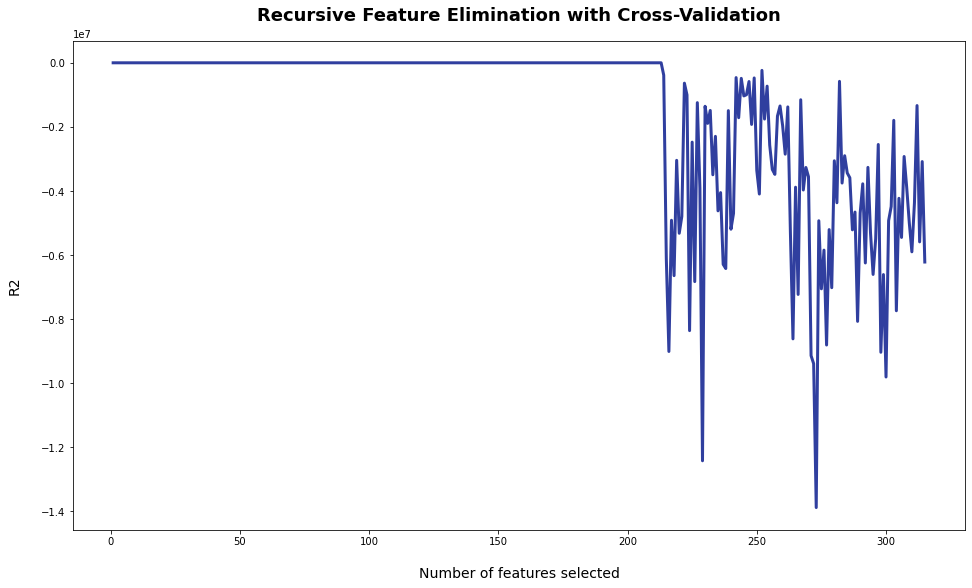

In [181]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('R2', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

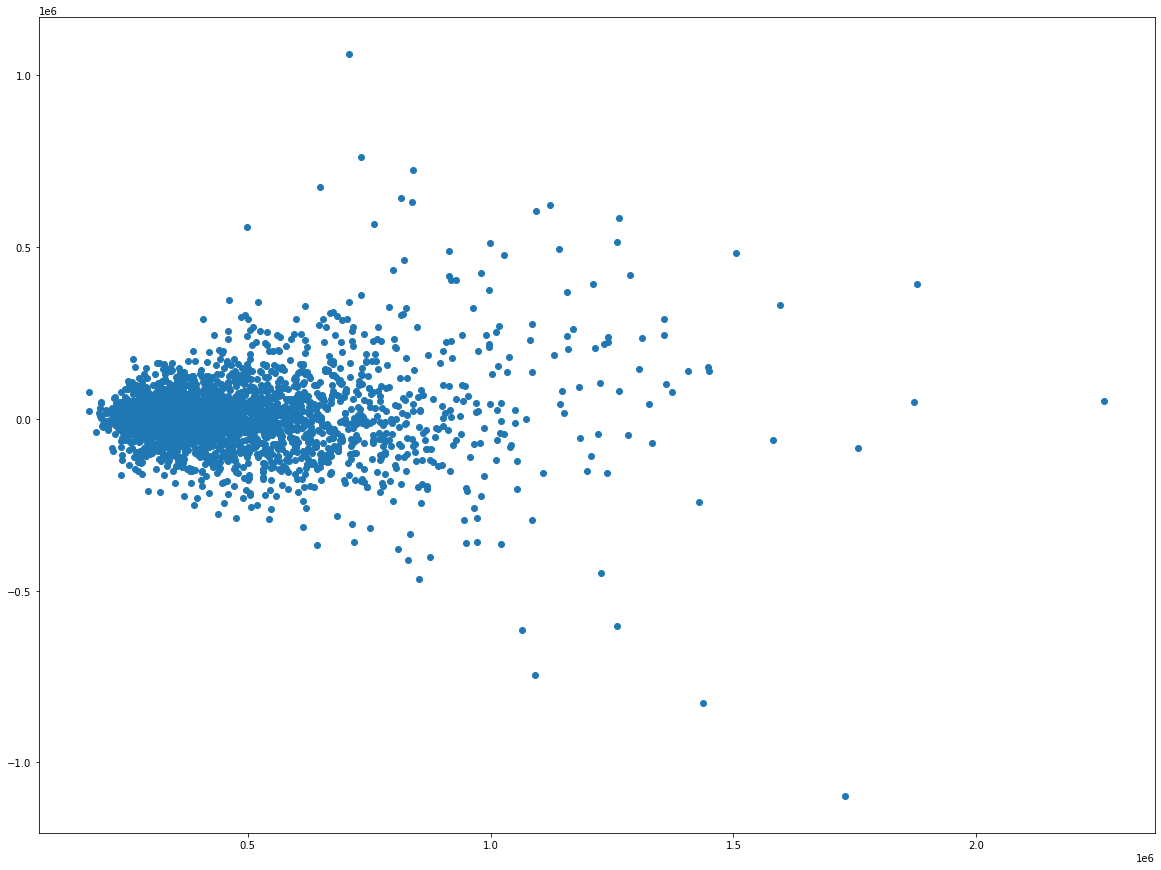

In [182]:
# predict on new data
rfecv_predictions = rfecv.predict(X_test_onehot)

rfecv_predictions_unscaled = np.exp(rfecv_predictions)
rfecv_predictions_unscaled = rfecv_predictions_unscaled.flatten().astype(int)

# get residuals
residuals = test_actual - rfecv_predictions_unscaled

#plot residuals 
fig = plt.figure(figsize=(20,15))
plt.scatter(rfecv_predictions_unscaled, residuals);

In [183]:
# get mean absolute error

mae = round(mean_absolute_error(test_actual, rfecv_predictions_unscaled), 2)
mae

74736.28

In [184]:
# MAE for properties UNDER 500k

under500 = pd.DataFrame(list(zip(test_actual, rfecv_predictions_unscaled)), columns =['actual', 'predictions'])
under500 = under500[under500['actual'] < 500000]
mae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)
mae500

54594.97

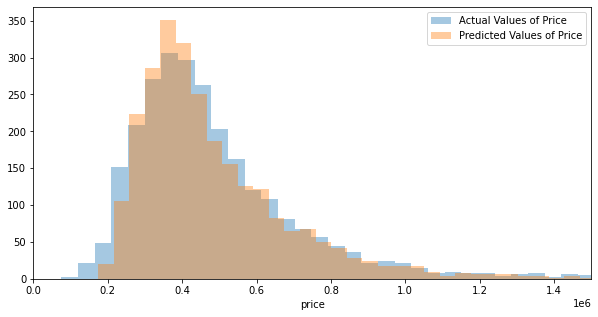

In [185]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(rfecv_predictions_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,1500000);

In [186]:
models['Models'].append('RFECV')
models['r2'].append(r2)
models['mae'].append(mae)
models['mae_500'].append(mae500)
values['rfecv_pred'] = rfecv_predictions_unscaled

## K-Nearest Neighbors Model

K-Nearest Neighbors is more commonly used for classification. Its basic premise is to determine "what is this like" in making a prediction, by looking at other things that are close in value/type. We can pick how many neighbors it assesses to make a classification. As we will see, it doesn't work very well for this type of application (or, I've not tuned the hyperparameters properly and/or don't know how to use it well).

We're using our target encoded data set on this.

In [187]:
mae_val = [] #to store mae values for different k

# checks mean absolute error scores on k from 1 to 25
for K in range(25):
    K = K+1
    
    # set up the KNN regressor
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_encoded, y_train)  #fit the model
    pred=model.predict(X_test_encoded) #make prediction on test set
    error = mean_absolute_error(y_test,pred) #calculate rmse
    mae_val.append(error) #store mae values
    print('MAE value for k= ' , K , 'is:', error)
    
# gets optimal k-value based on score minimum
index_min = np.argmin(mae_val) + 1

# makes model and fits using optimal k
model = neighbors.KNeighborsRegressor(n_neighbors = index_min)
model.fit(X_train_encoded, y_train)  #fit the model

# Get R^2 with cv
scores = cross_val_score(model, X_train_encoded, y_train, scoring='r2', cv=5, n_jobs=-1, error_score='raise')
r2 = np.mean(scores)
r2

MAE value for k=  1 is: 0.22997198100578778
MAE value for k=  2 is: 0.19639472653159035
MAE value for k=  3 is: 0.18679503061686598
MAE value for k=  4 is: 0.18298959395015943
MAE value for k=  5 is: 0.18061774826825797
MAE value for k=  6 is: 0.17911078383233198
MAE value for k=  7 is: 0.17879001814790918
MAE value for k=  8 is: 0.17801134233335367
MAE value for k=  9 is: 0.17755773239851258
MAE value for k=  10 is: 0.17736517167188892
MAE value for k=  11 is: 0.1766214607738636
MAE value for k=  12 is: 0.1769845266370424
MAE value for k=  13 is: 0.17732310816570573
MAE value for k=  14 is: 0.17647384788620027
MAE value for k=  15 is: 0.17700423473716476
MAE value for k=  16 is: 0.17733612324924475
MAE value for k=  17 is: 0.1776123389238627
MAE value for k=  18 is: 0.17847172342342424
MAE value for k=  19 is: 0.17864663447265192
MAE value for k=  20 is: 0.17862854642866316
MAE value for k=  21 is: 0.17834920840510513
MAE value for k=  22 is: 0.1783225216156349
MAE value for k=  23 is

0.6859903014708028

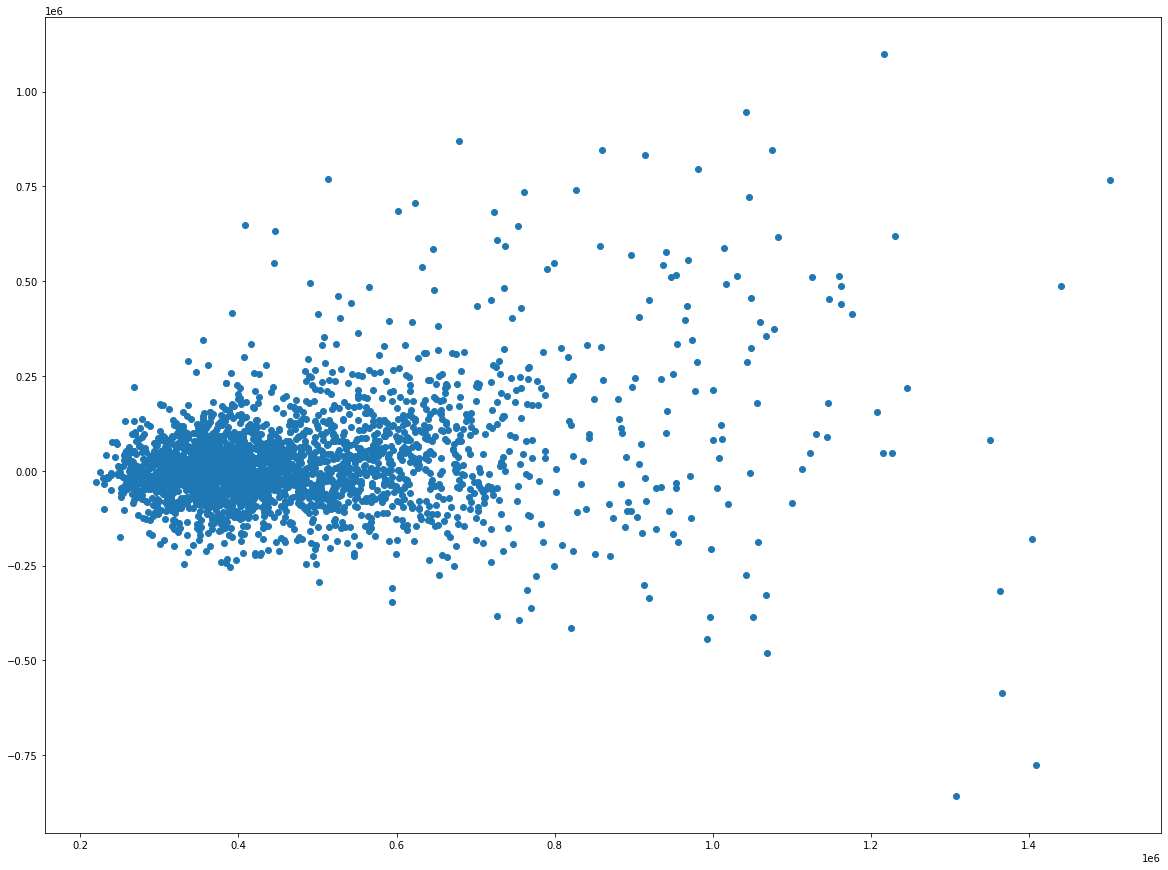

In [188]:
#make prediction on test set
pred_knn = model.predict(X_test_encoded)
pred_knn = np.exp(pred_knn).flatten().astype(int)

# get residuals
residuals = test_actual - pred_knn

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(pred_knn, residuals)

In [189]:
# get mean absolute error

mae = round(mean_absolute_error(test_actual, pred_knn), 2)
mae

88954.82

In [190]:
# MAE for properties UNDER 500k

under500 = pd.DataFrame(list(zip(test_actual, pred_knn)), columns =['actual', 'predictions'])
under500 = under500[under500['actual'] < 500000]
mae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)
mae500

58149.41

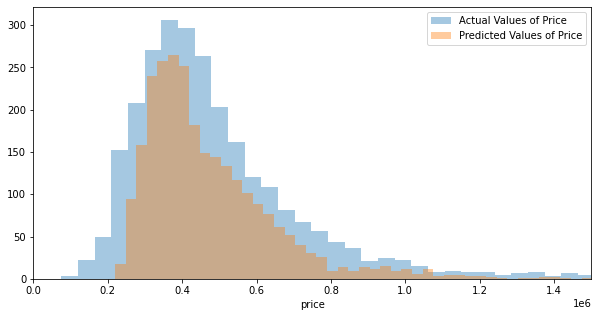

In [191]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(pred_knn, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,1500000);

In [192]:
models['Models'].append('KNN')
models['r2'].append(r2)
models['mae'].append(mae)
models['mae_500'].append(mae500)
values['knn_pred'] = pred_knn

## Support Vector Regression

Support vector regression is a form of regression that allows us to define the acceptable error in our model and then finds the line that best fits the data, according to our specifications. This is really useful with something like housing price predictions, where we are ok with our prediction being within a certain dollar amount. SVR will attempt to get all of the predictions within that dollar amount when possible. This will result in a fit line that is different than a linear regression would have produced, but should result in a lower absolute error, which is a reasonable scoring metric for housing price predictions.

We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our SVM! Here are the parameters we are trying out:

* kernel: linear is parametric, and rbf is non-parametric. One of these should perform better. Our data is not totally normal, so it might be rbf.
* epsilon: This value is how much error we're ok with accepting without assigning a penalty to the model
* C: The error that we will accept from a point outside our epsilon

Our C and epsilon need to be in scale with our output variable, which is our log-transformed price.


In [193]:
'''# Parameter Tuning

param_grid = {'kernel' : ['linear', 'rbf'],
              'gamma' : ['scale', 'auto'],
              'C':[3,6,10],
              'epsilon':[.05, .1]
              }

svr = SVR(tol=.005, verbose=True)
grid_search = GridSearchCV(svr, param_grid, verbose=10, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

grid_search.fit(X_train_onehot, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

'# Parameter Tuning\n\nparam_grid = {\'kernel\' : [\'linear\', \'rbf\'],\n              \'gamma\' : [\'scale\', \'auto\'],\n              \'C\':[3,6,10],\n              \'epsilon\':[.05, .1]\n              }\n\nsvr = SVR(tol=.005, verbose=True)\ngrid_search = GridSearchCV(svr, param_grid, verbose=10, scoring=\'neg_mean_absolute_error\', cv=5, n_jobs=-1)\n\ngrid_search.fit(X_train_onehot, y_train)\n\ngrid_search.best_estimator_\n\nprint("Best parameters set found on train set: \n")\nprint(grid_search.best_params_)\nprint("\nGrid scores on train set:\n")\nmeans = grid_search.cv_results_[\'mean_test_score\']\nstds = grid_search.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, grid_search.cv_results_[\'params\']):\n    print("%0.3f (+/-%0.03f) for %r"\n              % (mean, std * 2, params))'

Best parameters set found on train set: 

    {'C': 10, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}

    Grid scores on train set:

    -0.141 (+/-0.004) for {'C': 3, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}
    -0.144 (+/-0.004) for {'C': 3, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 3, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'linear'}
    -0.139 (+/-0.003) for {'C': 3, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    -0.147 (+/-0.004) for {'C': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
    -0.140 (+/-0.002) for {'C': 3, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 6, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}
    -0.149 (+/-0.004) for {'C': 6, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 6, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'linear'}
    -0.136 (+/-0.003) for {'C': 6, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 6, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    -0.150 (+/-0.004) for {'C': 6, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 6, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
    -0.138 (+/-0.002) for {'C': 6, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 10, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'linear'}
    -0.151 (+/-0.004) for {'C': 10, 'epsilon': 0.05, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.141 (+/-0.004) for {'C': 10, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'linear'}
    -0.135 (+/-0.003) for {'C': 10, 'epsilon': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    -0.152 (+/-0.004) for {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
    -0.142 (+/-0.004) for {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
    -0.136 (+/-0.002) for {'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

In [194]:
'''# setting up estimator with our optimal parameters
params = {'kernel' : 'rbf', 'C' : 10, 'epsilon' : .05, 'gamma':'auto'}
svr = SVR(**params, verbose=True, tol=.005)

# fitting our estimator to train data
svr.fit(X_train_onehot, y_train)

# getting R^2 with cv
cv_5 = cross_val_score(svr, X_train_onehot, y_train, cv=5, n_jobs=-1)
r2 = cv_5.mean()
r2'''

"# setting up estimator with our optimal parameters\nparams = {'kernel' : 'rbf', 'C' : 10, 'epsilon' : .05, 'gamma':'auto'}\nsvr = SVR(**params, verbose=True, tol=.005)\n\n# fitting our estimator to train data\nsvr.fit(X_train_onehot, y_train)\n\n# getting R^2 with cv\ncv_5 = cross_val_score(svr, X_train_onehot, y_train, cv=5, n_jobs=-1)\nr2 = cv_5.mean()\nr2"

In [195]:
'''# make new predictions on test
predictions_SVR = svr.predict(X_test_onehot)
predictions_SVR_unscaled = np.exp(predictions_SVR)

# get residuals
residuals = test_actual - predictions_SVR_unscaled

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(predictions_SVR_unscaled, residuals)'''

'# make new predictions on test\npredictions_SVR = svr.predict(X_test_onehot)\npredictions_SVR_unscaled = np.exp(predictions_SVR)\n\n# get residuals\nresiduals = test_actual - predictions_SVR_unscaled\n\n# plot residuals\nfig = plt.figure(figsize=(20,15))\nplt.scatter(predictions_SVR_unscaled, residuals)'

In [196]:
'''# get mean absolute error

mae = round(mean_absolute_error(test_actual, predictions_SVR_unscaled), 2)
mae'''

'# get mean absolute error\n\nmae = round(mean_absolute_error(test_actual, predictions_SVR_unscaled), 2)\nmae'

In [197]:
'''# MAE for properties UNDER 500k

under500 = pd.DataFrame(list(zip(test_actual, predictions_SVR_unscaled)), columns =['actual', 'predictions'])
under500 = under500[under500['actual'] < 500000]
mae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)
mae500'''

"# MAE for properties UNDER 500k\n\nunder500 = pd.DataFrame(list(zip(test_actual, predictions_SVR_unscaled)), columns =['actual', 'predictions'])\nunder500 = under500[under500['actual'] < 500000]\nmae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)\nmae500"

In [198]:
'''# plot actual and predictions
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(predictions_SVR_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,1500000);'''

"# plot actual and predictions\nplt.figure(figsize=(10,5))\nsns.distplot(np.exp(y_test), hist=True, kde=False)\nsns.distplot(predictions_SVR_unscaled, hist=True, kde=False)\nplt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])\nplt.xlim(0,1500000);"

In [199]:
'''models['Models'].append('SVR')
models['r2'].append(r2)
models['mae'].append(mae)
models['mae_500'].append(mae500)
values['svr_pred'] = predictions_SVR_unscaled'''

"models['Models'].append('SVR')\nmodels['r2'].append(r2)\nmodels['mae'].append(mae)\nmodels['mae_500'].append(mae500)\nvalues['svr_pred'] = predictions_SVR_unscaled"

## Redo Data for Decision-Based Regressors

We're now going to work with some different model types that are entirely different from linear regression.

There's conflicting information on whether we should use one-hot encoding, or target encoding. We'll solve this by trying both and figuring out what works best for our data set.

### Decision Tree Regressors - One Hot

We need to slightly redo our one-hot encodings to not drop the first entry. We'll also make year_built into total one-hot encodings rather than bins.

In [200]:
dummies_boost_cats_test = pd.get_dummies(holdout_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=False)
dummies_boost_cats_train = pd.get_dummies(df_categoricals[high_one_hot_cat], prefix=high_one_hot_cat, drop_first=False)

x_train_boost = pd.concat([df_cont_high_one_hot, dummies_boost_cats_train, train_word_vectors_refined], axis=1)
x_test_boost = pd.concat([df_cont_high_one_hot_holdout, dummies_boost_cats_test, holdout_word_vectors_refined], axis=1)

# redoing our y_train and y_test as non-log transformed
y = df[target] # our target variable

# creating our train/validation sets and our test sets
y_train, y_test = train_test_split(y, test_size=0.2, random_state=randomstate)

# reset indices to avoid index mismatches
y_train = pd.DataFrame(y_train)
y_train.reset_index(inplace=True)
y_train.drop('index', axis=1, inplace=True)

y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace=True)
y_test.drop('index', axis=1, inplace=True)

#### Random Forest

Random Forest is a decision tree model. It runs a large number of randomized decision trees and uses the averages of its results to make a prediction. It attempts to pick each tree at random without a directed or iterative plan.

We're going to do extensive parameter tuning to find the best hyperparameters for our random forest, tuning only one or two hyperparameters at a time. When we find an optimal hyperparameter we will add it to our model and tune a different parameter. This iterative approach allows us to test parameters in less time than a large GridSearchCV, although a larger grid search would prove more exhaustive to explore parameter interactions.

Here are the parameters we are trying out:

    max_depth: This determines how many tree nodes the estimator looks at before making a prediction. We don't know what is best here, so we are trying a large scale from 10-100 first and seeing what looks right.
    min_samples_split: The minimum number of samples required to split an internal node
    min_samples_leaf: The minimum number of samples required to be at a leaf node
    max_features: The number of features to consider when looking for the best split
    bootstrap: Whether bootstrap samples are used when building trees
    n_estimators: The number of trees in the forest

In [201]:
'''model = RandomForestRegressor(criterion='mae', n_jobs=-1, max_depth=40, n_estimators=250, warm_start=True)
model.fit(x_train_boost, y_train)

from sklearn.inspection import permutation_importance
r = permutation_importance(model, x_train_boost, y_train,
                           n_repeats=5,
                            random_state=0,
                          n_jobs=-1)

importances = {}

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] >= 0.001:
        importances[x_train_boost.columns[i]] = r.importances_mean[i]
    else: continue

important_features_forest = list(importances.keys())
important_features_forest'''

"model = RandomForestRegressor(criterion='mae', n_jobs=-1, max_depth=40, n_estimators=250, warm_start=True)\nmodel.fit(x_train_boost, y_train)\n\nfrom sklearn.inspection import permutation_importance\nr = permutation_importance(model, x_train_boost, y_train,\n                           n_repeats=5,\n                            random_state=0,\n                          n_jobs=-1)\n\nimportances = {}\n\nfor i in r.importances_mean.argsort()[::-1]:\n    if r.importances_mean[i] >= 0.001:\n        importances[x_train_boost.columns[i]] = r.importances_mean[i]\n    else: continue\n\nimportant_features_forest = list(importances.keys())\nimportant_features_forest"

In [202]:
important_features_forest = ['livingAreaSqFt',
 'avgSchoolRating',
 'avgSchoolSize',
 'zipcode_78704',
 'zipcode_78703',
 'hasAssociation_1',
 'hasAssociation_0',
 'numPriceChanges',
 'lotSizeSqFt',
 'avgSchoolDistance',
 'zipcode_78702',
 'propertyTaxRate_1.98',
 'zipcode_78735',
 'zipcode_78746',
 'zipcode_78731',
 'numOfPhotos',
 'zipcode_78757',
 'zipcode_78723',
 'numOfSchools_3',
 'numOfAppliances',
 'lot',
 'zipcode_78759',
 'zipcode_78750',
 'great',
 'zilker',
 'pool',
 'year_block_1',
 'numOfBedrooms',
 'floor',
 'zipcode_78730',
 'appliance',
 'living',
 'new',
 'large',
 'design',
 'build',
 'propertyTaxRate_2.21',
 'zipcode_78753',
 'numOfStories',
 'space',
 'numOfSchools_4',
 'numOfSchools_2',
 'garageSpaces_0',
 'hardwood',
 'light',]

In [203]:
x_train_forest = x_train_boost[important_features_forest]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:    7.7s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:   11.4s remaining:   52.4s
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:   12.1s remaining:   28.4s
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:   15.1s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:   19.1s remaining:   16.3s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:   20.7s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   23.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   26.8s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.6s finished


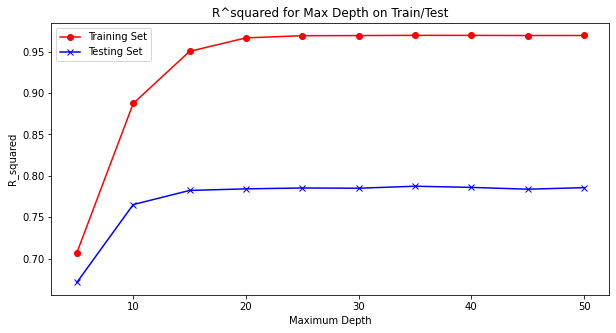

In [213]:
# visualize changes to model score as it is tried on different max depths from 10 to 100, to get a starting point for max depth

from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, 
                                               target, param_name, np.arange(5,55,5), 
                                               cv=5, scoring='r2', verbose=10, n_jobs=-1)
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(5,55,5), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(5,55,5), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('R_squared')
    plt.title("R^squared for Max Depth on Train/Test")
    
ValidationCurve(RandomForestRegressor(), x_train_forest, y_train, 'max_depth', 'Maximum Depth')

In [214]:
'''# Parameter Tuning

param_grid = {'max_depth' : [25, 30, 35, 40],            
              }

model = RandomForestRegressor(criterion='mae', verbose=10, n_jobs=-1)

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

Fitting 5 folds for each of 2 candidates, totalling 10 fits


KeyboardInterrupt: 

Best parameters set found on train set:

    {'max_depth': 20}

    Grid scores on train set:

    0.782 (+/-0.028) for {'max_depth': 20}
    0.782 (+/-0.027) for {'max_depth': 40}
    0.781 (+/-0.027) for {'max_depth': 60}
    0.781 (+/-0.025) for {'max_depth': 80}
    0.781 (+/-0.024) for {'max_depth': 100}

In [207]:
'''# Parameter Tuning

param_grid = {'min_samples_split': [2, 5, 8]            
              }

model = RandomForestRegressor(criterion='mae', verbose=10, max_depth=20, n_jobs=-4)

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

'# Parameter Tuning\n\nparam_grid = {\'min_samples_split\': [2, 5, 8]            \n              }\n\nmodel = RandomForestRegressor(criterion=\'mae\', verbose=10, max_depth=20, n_jobs=-4)\n\ngrid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, \n                                   verbose=10, n_jobs=-4)\ngrid_search.fit(x_train_boost, y_train)\n\ngrid_search.best_estimator_\n\nprint("Best parameters set found on train set: \n")\nprint(grid_search.best_params_)\nprint("\nGrid scores on train set:\n")\nmeans = grid_search.cv_results_[\'mean_test_score\']\nstds = grid_search.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, grid_search.cv_results_[\'params\']):\n    print("%0.3f (+/-%0.03f) for %r"\n              % (mean, std * 2, params))'

Best parameters set found on train set: 

    {'min_samples_split': 2}

    Grid scores on train set:

    0.783 (+/-0.028) for {'min_samples_split': 2}
    0.782 (+/-0.027) for {'min_samples_split': 5}
    0.781 (+/-0.025) for {'min_samples_split': 8}

In [208]:
'''#Parameter Tuning

param_grid = {'min_samples_split': [2, 3, 4]            
              }

model = RandomForestRegressor(criterion='mae', verbose=10, max_depth=20, n_jobs=-4)

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

'#Parameter Tuning\n\nparam_grid = {\'min_samples_split\': [2, 3, 4]            \n              }\n\nmodel = RandomForestRegressor(criterion=\'mae\', verbose=10, max_depth=20, n_jobs=-4)\n\ngrid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, \n                                   verbose=10, n_jobs=-4)\ngrid_search.fit(x_train_boost, y_train)\n\ngrid_search.best_estimator_\n\nprint("Best parameters set found on train set: \n")\nprint(grid_search.best_params_)\nprint("\nGrid scores on train set:\n")\nmeans = grid_search.cv_results_[\'mean_test_score\']\nstds = grid_search.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, grid_search.cv_results_[\'params\']):\n    print("%0.3f (+/-%0.03f) for %r"\n              % (mean, std * 2, params))'

Best parameters set found on train set: 

    {'min_samples_split': 2}

    Grid scores on train set:

    0.782 (+/-0.028) for {'min_samples_split': 2}
    0.780 (+/-0.024) for {'min_samples_split': 3}
    0.781 (+/-0.024) for {'min_samples_split': 4}

In [209]:
'''# Parameter Tuning

param_grid = {'min_samples_leaf': [1, 3],
              'max_features': ['auto', 'sqrt']
              }

model = RandomForestRegressor(criterion='mae', max_depth=20, min_samples_split=2, n_jobs=-4)

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

'# Parameter Tuning\n\nparam_grid = {\'min_samples_leaf\': [1, 3],\n              \'max_features\': [\'auto\', \'sqrt\']\n              }\n\nmodel = RandomForestRegressor(criterion=\'mae\', max_depth=20, min_samples_split=2, n_jobs=-4)\n\ngrid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, \n                                   verbose=10, n_jobs=-4)\ngrid_search.fit(x_train_boost, y_train)\n\ngrid_search.best_estimator_\n\nprint("Best parameters set found on train set: \n")\nprint(grid_search.best_params_)\nprint("\nGrid scores on train set:\n")\nmeans = grid_search.cv_results_[\'mean_test_score\']\nstds = grid_search.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, grid_search.cv_results_[\'params\']):\n    print("%0.3f (+/-%0.03f) for %r"\n              % (mean, std * 2, params))'

Best parameters set found on train set: 

    {'max_features': 'auto', 'min_samples_leaf': 1}

    Grid scores on train set:

    0.782 (+/-0.023) for {'max_features': 'auto', 'min_samples_leaf': 1}
    0.780 (+/-0.025) for {'max_features': 'auto', 'min_samples_leaf': 3}
    0.747 (+/-0.028) for {'max_features': 'sqrt', 'min_samples_leaf': 1}
    0.724 (+/-0.030) for {'max_features': 'sqrt', 'min_samples_leaf': 3}

In [210]:
'''# Parameter Tuning

param_grid = {
         'bootstrap': [True, False]
        }

model = RandomForestRegressor(criterion='mae', max_depth=20, min_samples_split=2, max_features='auto', min_samples_leaf=1, n_jobs=-4)

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

'# Parameter Tuning\n\nparam_grid = {\n         \'bootstrap\': [True, False]\n        }\n\nmodel = RandomForestRegressor(criterion=\'mae\', max_depth=20, min_samples_split=2, max_features=\'auto\', min_samples_leaf=1, n_jobs=-4)\n\ngrid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, \n                                   verbose=10, n_jobs=-4)\ngrid_search.fit(x_train_boost, y_train)\n\ngrid_search.best_estimator_\n\nprint("Best parameters set found on train set: \n")\nprint(grid_search.best_params_)\nprint("\nGrid scores on train set:\n")\nmeans = grid_search.cv_results_[\'mean_test_score\']\nstds = grid_search.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, grid_search.cv_results_[\'params\']):\n    print("%0.3f (+/-%0.03f) for %r"\n              % (mean, std * 2, params))'

Best parameters set found on train set: 

    {'bootstrap': True}

    Grid scores on train set:

    0.781 (+/-0.025) for {'bootstrap': True}
    0.598 (+/-0.074) for {'bootstrap': False}

In [ ]:
break

In [ ]:
# set our regressor with optimal parameterss. I'm going to go with 500 on the estimators because they all seemed very close.
randomforest = RandomForestRegressor(criterion='mae',
                                     max_depth=20, 
                                     min_samples_split=2, 
                                     max_features='auto', 
                                     min_samples_leaf=1, 
                                     bootstrap=True, 
                                     n_estimators=500, 
                                     n_jobs=-4)

# fit random forest regressor to train
randomforest.fit(x_train_boost, y_train)

# check cross_val R^2

cv_5 = cross_val_score(randomforest, x_train_boost, y_train, cv=5, n_jobs=-4)
r2 = cv_5.mean()
r2

In [ ]:
# apply our model to our test set and get predicted values
forest_predictions = randomforest.predict(x_test_boost)

# calculate residuals
residuals = test_actual - forest_predictions

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(forest_predictions, residuals)

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, forest_predictions), 2)
mae

In [ ]:
# MAE for properties UNDER 500k

under500 = pd.DataFrame(list(zip(test_actual, forest_predictions)), columns =['actual', 'predictions'])
under500 = under500[under500['actual'] < 500000]
mae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)
mae500

In [ ]:
models['Models'].append('Random Forest - One Hot')
models['r2'].append(r2)
models['mae'].append(mae)
models['mae_500'].append(mae500)
values['forest_pred'] = forest_predictions

#### XGBoost

This model is entirely different than linear regression. Gradient boosting uses decision trees to learn about outcomes, with trees being added to the model one at a time and existing trees in the model are not changed. Each successive tree tries to improve upon the predictions of the first one, with the weights of the various decision points being updated each time. Gradient boosting uses the residuals to improve its next tree prediction. Overall much more opaque of a process than linear regression.

Gradient Boosting performs best with optimal parameter tuning. We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our gradient booster! Here are the parameters we are trying out:

* n_estimators: Number of boosts to perform. Gradient boosting is pretty robust to over-fitting so more is usually better
* max_depth: This determines how many tree nodes the estimator looks at before making a prediction. We don't know what is best here, so we are trying things from 2-4 to see what works the best
* min_child_weight: Min sum of instance weight needed in a child
* gamma: Minimum loss reduction to make another partition on a leaf node. Higher results in more conservative algorithm.
* subsample: Ratio of training sets. .5 means that it will sample half the training data before making trees. Occurs with each boosting iteration.
* colsample_by_tree: ratio of columns when making a tree
* alpha: L1 regularization. Higher will make model more conservative.
* learning_rate: Tuning this setting alters how much the model corrects after it runs a boost. .1 is a common rate and we will test a lower and higher rate as well.

In [ ]:
# visualize changes to model score as it is tried on different max depths from 10 to 80, to get a starting point for max depth

from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, target, 
                                               param_name, np.arange(10,90,10), 
                                               cv=5, scoring='r2', n_jobs=-4)
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(10,90,10), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(10,90,10), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('R_squared')
    plt.title("R^squared for Max Depth on Train/Test")
    
ValidationCurve(xgb.XGBRegressor(), x_train_boost, y_train, 'max_depth', 'Maximum Depth')

In [ ]:
'''# Parameter Tuning max_depth

param_grid = {"max_depth": [5, 10],
                          
              }

model = xgb.XGBRegressor(
                 n_estimators=250,                                                                    
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-4)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

Best parameters set found on train set: 

    {'max_depth': 5}

    Grid scores on train set:
    
    0.790 (+/-0.016) for {'max_depth': 5}
    0.770 (+/-0.037) for {'max_depth': 10}

In [ ]:
'''# Parameter Tuning max_depth and min_child_weight

param_grid = {"max_depth": [3, 5, 7],
              "min_child_weight" : [6, 8, 10]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,                                                                    
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

Best parameters set found on train set: 

    {'max_depth': 3, 'min_child_weight': 8}

    Grid scores on train set:

    0.794 (+/-0.019) for {'max_depth': 3, 'min_child_weight': 6}
    0.797 (+/-0.025) for {'max_depth': 3, 'min_child_weight': 8}
    0.795 (+/-0.021) for {'max_depth': 3, 'min_child_weight': 10}
    0.787 (+/-0.018) for {'max_depth': 5, 'min_child_weight': 6}
    0.785 (+/-0.019) for {'max_depth': 5, 'min_child_weight': 8}
    0.792 (+/-0.022) for {'max_depth': 5, 'min_child_weight': 10}
    0.783 (+/-0.028) for {'max_depth': 7, 'min_child_weight': 6}
    0.780 (+/-0.023) for {'max_depth': 7, 'min_child_weight': 8}
    0.780 (+/-0.031) for {'max_depth': 7, 'min_child_weight': 10}

In [ ]:
'''# Parameter Tuning max_depth and min_child_weight

param_grid = {"max_depth": [2, 3, 4],
              "min_child_weight" : [7, 8, 9]            
              }

model = xgb.XGBRegressor(
                 n_estimators=250,                                                                    
                 seed=42,
                 missing=0,
                 eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

Best parameters set found on train set: 

    {'max_depth': 3, 'min_child_weight': 8}

    Grid scores on train set:

    0.794 (+/-0.019) for {'max_depth': 2, 'min_child_weight': 7}
    0.793 (+/-0.023) for {'max_depth': 2, 'min_child_weight': 8}
    0.795 (+/-0.024) for {'max_depth': 2, 'min_child_weight': 9}
    0.797 (+/-0.022) for {'max_depth': 3, 'min_child_weight': 7}
    0.797 (+/-0.025) for {'max_depth': 3, 'min_child_weight': 8}
    0.795 (+/-0.026) for {'max_depth': 3, 'min_child_weight': 9}
    0.790 (+/-0.016) for {'max_depth': 4, 'min_child_weight': 7}
    0.793 (+/-0.019) for {'max_depth': 4, 'min_child_weight': 8}
    0.792 (+/-0.029) for {'max_depth': 4, 'min_child_weight': 9}

In [ ]:
'''# Parameter Tuning gamma

param_grid = {'gamma':[.1, .3, .5, .7, .9]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight = 8,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

Best parameters set found on train set: 

    {'gamma': 0.1}

    Grid scores on train set:

    0.797 (+/-0.025) for {'gamma': 0.1}
    0.797 (+/-0.025) for {'gamma': 0.3}
    0.797 (+/-0.025) for {'gamma': 0.5}
    0.797 (+/-0.025) for {'gamma': 0.7}
    0.797 (+/-0.025) for {'gamma': 0.9}

In [ ]:
'''# Parameter Tuning subsample

param_grid = {
 'subsample':[.2, .4, .6, .8, 1],
 
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight = 8,
                gamma = .1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

In [ ]:
'''# Parameter Tuning colsample_by_tree

param_grid = {
 'colsample_bytree':[.2, .4, .6, .8, 1]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight = 8,
                gamma = .1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

In [ ]:
# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 100]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight = 8,
                gamma = .1,
                colsample_bytree=.8,
                reg_lambda = 1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'reg_alpha': 10}

    Grid scores on train set:

    0.803 (+/-0.019) for {'reg_alpha': 1e-05}
    0.803 (+/-0.019) for {'reg_alpha': 0.01}
    0.803 (+/-0.019) for {'reg_alpha': 0.1}
    0.803 (+/-0.019) for {'reg_alpha': 1}
    0.803 (+/-0.019) for {'reg_alpha': 10}
    0.802 (+/-0.020) for {'reg_alpha': 100}

In [ ]:
'''# Parameter Tuning alpha

param_grid = {
    'reg_alpha':[5, 10, 25, 50]
    }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight = 8,
                gamma = .1,
                colsample_bytree=.8,
                reg_lambda = 1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

Best parameters set found on train set: 

    {'reg_alpha': 10}

    Grid scores on train set:

    0.803 (+/-0.019) for {'reg_alpha': 5}
    0.803 (+/-0.019) for {'reg_alpha': 10}
    0.802 (+/-0.020) for {'reg_alpha': 25}
    0.802 (+/-0.020) for {'reg|_alpha': 50}

In [ ]:
# Parameter Tuning lambda

param_grid = {'lambda':[0.1, 1, 10, 100, 500, 1000, 2500]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight = 8,
                gamma = .1,
                colsample_bytree=.8,
                reg_alpha = 10,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'lambda': 1}

    Grid scores on train set:

    0.797 (+/-0.022) for {'lambda': 0.1}
    0.803 (+/-0.019) for {'lambda': 1}
    0.802 (+/-0.013) for {'lambda': 10}
    0.794 (+/-0.018) for {'lambda': 100}
    0.780 (+/-0.029) for {'lambda': 500}
    0.772 (+/-0.023) for {'lambda': 1000}
    0.755 (+/-0.021) for {'lambda': 2500}

In [ ]:
# Parameter Tuning lambda

param_grid = {'lambda':[0.5, 1, 5]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight = 8,
                gamma = .1,
                colsample_bytree=.8,
                reg_alpha = 10,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

    {'lambda': 1}

    Grid scores on train set:

    0.799 (+/-0.023) for {'lambda': 0.5}
    0.803 (+/-0.019) for {'lambda': 1}
    0.801 (+/-0.023) for {'lambda': 5}

In [ ]:
'''# Parameter Tuning num_estimators

param_grid = {'num_estimators':[250, 500, 1000, 5000]            
              }

model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight = 8,
                gamma = .1,
                colsample_bytree=.8,
                reg_alpha = 10,
                reg_lambda = 1,
                seed=42,
                missing=0,
                eval_metric='mae' )

grid_search = GridSearchCV(model, param_grid=param_grid, cv = 5, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(x_train_boost, y_train)

grid_search.best_estimator_

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

Best parameters set found on train set: 

    {'num_estimators': 250}

    Grid scores on train set:

    0.803 (+/-0.019) for {'num_estimators': 250}
    0.803 (+/-0.019) for {'num_estimators': 500}
    0.803 (+/-0.019) for {'num_estimators': 1000}
    0.803 (+/-0.019) for {'num_estimators': 5000}

In [ ]:
best_xgb_model = xgb.XGBRegressor(
                n_estimators=250,
                max_depth = 3,
                min_child_weight = 8,
                gamma = .1,
                colsample_bytree=.8,
                reg_alpha = 10,
                reg_lambda = 1,
                seed=42,
                missing=0,
                eval_metric='mae' )
best_xgb_model.fit(x_train_boost, y_train)

cv_5 = cross_val_score(best_xgb_model, x_train_boost, y_train, cv=5)
r2 = cv_5.mean()
r2

In [ ]:
# make prediction
preds = best_xgb_model.predict(x_test_boost)

#log residuals
residuals = test_actual - preds

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(preds, residuals)

In [ ]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, preds), 2)
mae

In [ ]:
# MAE for properties UNDER 500k

under500 = pd.DataFrame(list(zip(test_actual, preds)), columns =['actual', 'predictions'])
under500 = under500[under500['actual'] < 500000]
mae500 = round(mean_absolute_error(under500['actual'], under500['predictions']), 2)
mae500

In [ ]:
models['Models'].append('XGBoost')
models['r2'].append(r2)
models['mae'].append(mae)
models['mae_500'].append(mae500)
values['boost_pred'] = preds

### Decision Tree Regressors - Target Encoding

# Model Selection

We ran several different types of models, and logged the r^squared and mean absolute error for each model type. Which model performed the best for us?

In [ ]:
# make data frame from our models dictionary
model_types = pd.DataFrame(models)

# sort data frame by mae and reset index
model_types = model_types.sort_values('mae', ascending=True).reset_index()
model_types.drop('index',axis=1, inplace=True)
model_types.set_index('Models', inplace=True)

model_types

In [ ]:
# plot model mae

plt.figure(figsize=(15,10))
plt.plot(model_types['mae'])
plt.title("Mean Average Error")
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel("MAE");

In [ ]:
# get residuals for a few types
values['rfecv_resid'] = (values['actual'] - values['rfecv_pred'])/10000
values['compsmodel_resid'] = (values['actual'] - values['compsmodel_pred'])/10000
values['boost_resid'] = (values['actual'] - values['boost_pred'])/10000

In [ ]:
# plot overlapping residuals for a few types
fig = plt.figure(figsize=(20,15))

plt.scatter(values['boost_pred'], values['boost_resid'], color='red')
plt.scatter(values['compsmodel_pred'], values['compsmodel_resid'], color='blue')
plt.scatter(values['rfecv_pred'], values['rfecv_resid'], color='green')
plt.title("Residuals")
#plt.xticks(rotation=90)
plt.xlabel('Predictions in millions')
plt.ylabel("Distance from Actual, in $10,000");

Ultimately we will select the sklearn RFECV method for our model. This method performs optimal feature selection via cross validation in order to determine the best feature set for the data. 

Support Vector Regression and Ridge performed better, but it doesn't fulfill two of the asks for this project - that the model be a linear regression, and that it be easily explained. RFECV also had the lowest MAE on properties under 500k, so we're happy with its overall performance.

# Final Model

Now that we've chosen a favorite regression for this problem (RFECV), we want to be able to actually use the model to predict new data. Our steps are as follows:

* Build a model using our ENTIRE dataset for deployment
* Write our own standardization functions that we can apply to incoming new data
* Prepare a more intuitive GUI for predicting on new data

## Prepare full data set for final model

In [ ]:
# merge our x_test and x_train continuous variables into one data frame, then make sure index is reset
X_all_continuous = x_test_cont.append(x_train_cont)
X_all_continuous.reset_index(inplace=True)
X_all_continuous.drop(['index'], axis=1, inplace=True)

# merge our x_test and x_train categorical variables into one data frame, then make sure index is reset
X_all_categoricals = x_test_cat.append(x_train_cat)
X_all_categoricals.reset_index(inplace=True)
X_all_categoricals.drop('index', axis=1, inplace=True)

While forming our model, we used the sklearn StandardScaler. But how do we scale brand new features that we are trying to predict from? In order to do so, we need to write a standardization function for each of our features, that we can then save and apply to our new prediction data.

In [ ]:
# make dictionary to store standardization coefficients
standardization_coeffs = {}

# make standardization coefficients for each column
for item in X_all_continuous:
    standardization_coeffs[item+'_mean'] = X_all_continuous[item].mean()
    standardization_coeffs[item+'_std'] = X_all_continuous[item].std()

# log transform all continuous
X_all_continuous = np.log(X_all_continuous)

# apply standardization to all continuous
for item in X_all_continuous:
    X_all_continuous[item] = (X_all_continuous[item] - standardization_coeffs[item+'_mean'])/standardization_coeffs[item+'_std']
    
# concat continuous and categoricals into a final X
X_final = pd.concat([X_all_continuous, X_all_categoricals], axis=1)

# concat train and test y into a final y, reset index so it matches X
y_final = y_test.append(y_train_val)
y_final.reset_index(inplace=True)
y_final.drop('index',  axis=1, inplace=True) 

## Train Final Model

Using sklearn RFECV to perform integrated CV while picking the number of features.

We're running a heavy cv to ensure that we really, truly have the right feature selection. We're using sets of 5 folds, and then repeating 5 times with different sets of 5 folds using mean absolute error as the scoring metric - we're looking for lowest error range

In [ ]:
# define estimator and cv plan
model = LinearRegression()
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

# create final model using RFECV
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error')

# fit final model to all data
rfecv.fit(X_final, y_final)

# final model r^2
rfecv.score(X_final, y_final)

### Get Coefficient Importance

In [ ]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

In [ ]:
# get list of features used by the final model
dset = pd.DataFrame()
dset['attr'] = X_final.columns
dset['used'] = rfecv.support_

# make a list of the features used in the rfecv
rfecv_result = list(dset[(dset['used'] == True)]['attr'])

In [ ]:
# Run the model with the selected features in statsmodels OLS so we can get
# a list of model pvalues
X_specific = X_final[rfecv_result]

predictors_train = sm.add_constant(X_specific)
model = sm.OLS(y_final, predictors_train).fit()

model.summary()

We have values over p-value .05, so we're going to dump those by doing the feature selector on this.

In [ ]:
# run feature selector and get list of features with p-value under .05
stepwise_result = stepwise_selection(X_specific, y_final, verbose=True)

Our stepwise selector shows us our most important features. Grade, sqft_living, condition, and several zip codes were incredibly important features. Almost all included features had p-values so low that the probability that these features are influencing the price by random chance is near zero. Our highest included p-value, zipcode 98003, has only a .3% chance of having influenced prices by random chance.

In [ ]:
# make one last data set using the features that the selector accepted
X_specific = X_specific[stepwise_result]

# make final model
final_model = LinearRegression()
final_model.fit(X_specific, y_final)

# evaluate final model
predictors_train = sm.add_constant(X_specific)
model = sm.OLS(y_final, predictors_train).fit()

model.summary()

In [ ]:
# save our final summary to image
plt.rc('figure', figsize=(10,23))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
#plt.savefig('images/output.png')

In [ ]:
# final model MAE

end_z = np.exp(final_model.predict(X_specific))
mae = round(mean_absolute_error(np.exp(y_final), end_z), 2)
mae

In [ ]:
# get residuals
residuals = np.exp(y_final) - end_z

# plot residuals
fig = plt.figure(figsize=(20,15))
plt.scatter(end_z, residuals)
plt.title("Residuals")
#plt.xticks(rotation=90)
plt.xlabel('Predictions in millions')
plt.ylabel("Distance from Actual, in $10,000");

#plt.savefig('images/residuals.png')

Our residuals show the heteroscedasticity described by our Durbin Watson score above 2.

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True, ax=ax)

QQ-plot of residuals shows heavy tails.

### Observations on final model summary

> 88.2% of our variation in price can be explained by our model variables. Our equal R^2 and adjusted R^2 tells us that all of our features are contributing to our model. Adjusted R^2 penalizes the R^2 formula based on number of variables, so a same score tells us that our variables are all contributors.

> F-statistic and Prob(F-statistic) tell us if our variable group as a whole is statistically significant.The null hypothesis is a model with no variables (only intercept). Our prob(f-statistic) evaluates the chance that our null hypothesis is true and our variables have no effect. On our model this chance is so low that it's functionally 0. F-statistic is evaluating all of the coefficients used together, so p-value of individual coefficients is still important. So this number tells us that our MODEL is significant without telling us if any individual feature is significant.

> Omnibus and prob(omnibus) are telling us that our residuals are not normally distributed. We want to see a value close to 0 for Omnibus, and a value close to 1 for Prob(Omnibus). Neither of these things is the case. We saw heteroscedasticity on the residuals for all of our model types that we tried. All of our models seem to perform well at lower values and then variance increases as price increases. This was true on both linear and nonlinear approaches such as decision trees.

> Our data is skewed slightly left. Our data has high kurtosis which implies tighter grouping of our residuals around zero and fewer outliers, which implies a fitted model.

> Durbin Watson is a measure of homoscedasticity - an even distribution of errors. We are showing slight heteroscedasticity because we'd like to see this number between 1 and 2. We saw that heteroscedasticity in the residuals.

> Our low condition number implies no multicollinearity with our features.

> Overall our characteristics are mediocre. Our high omnibus and above 2 Durbin-Watson are problematic. Our QQ-plot shows very heavy tails. But no better model was found to correct for the heteroscedasticity.



# Analysis

> Our final model utilizes a combination of continuous variables and one-hot-encoded categoricals to produce a linear regression with R^2 of 88.2% and a mean absolute error of 56k. I tried several different transformations including polynomial features, mean target encoding, lower-granularity binning, and median rank as a continuous, and ALL of these efforts resulted in a lower R^2 and higher mean absolute error, leading to a final decision to one-hot encode all 70 zip codes individually. Similar efforts on other categoricals such as age and month sold also did not improve the model over one-hot encoding. This resulted in the greatest accuracy despite a model that is more "messy" with a large number of features.

> Features were selected using the sklean "Recursive Feature Elimination with Cross Validation" function, or RFECV. RFECV uses cross-validation and begins the model with all features, then eliminates the weakest feature and scores the model again, using cv with each iteration. At the end it returns the model with the feature set that produced the highest score on the cv. In the case of price predictions I used mean absolute error as my preferred scoring metric. Then, starting with the features recommended by RFECV, I ran the model again through a forward-backward feature selector, which starts with zero features and iteratively adds and subtracts features until all features have a p-value under the threshold (in this case .05). 

> Almost all included features had p-values so low that the probability that these features are influencing the price by random chance is near zero. Our highest included p-value, zipcode 98003, has only a .3% chance of having influenced prices by random chance.

> 88.2% of our variation in price can be explained by our model variables. Our equal R^2 and adjusted R^2 tells us that all of our features are contributing to our model. Adjusted R^2 penalizes the R^2 formula based on number of variables, so a same score tells us that our variables are all contributors.

> F-statistic and Prob(F-statistic) tell us if our variable group as a whole is statistically significant.The null hypothesis is a model with no variables (only intercept). Our prob(f-statistic) evaluates the chance that our null hypothesis is true and our variables have no effect. On our model this chance is so low that it's functionally 0. F-statistic is evaluating all of the coefficients used together, so p-value of individual coefficients is still important. So this number tells us that our MODEL is significant without telling us if any individual feature is significant.

> Omnibus and prob(omnibus) are telling us that our residuals are not normally distributed. We want to see a value close to 0 for Omnibus, and a value close to 1 for Prob(Omnibus). Neither of these things is the case. We saw heteroscedasticity on the residuals for all of our model types that we tried. All of our models seem to perform well at lower values and then variance increases as price increases. This was true on both linear and nonlinear approaches such as decision trees.

> Our data is skewed slightly left. Our data has high kurtosis which implies tighter grouping of our residuals around zero and fewer outliers, which implies a fitted model.

> Durbin Watson is a measure of homoscedasticity - an even distribution of errors. We are showing slight heteroscedasticity because we'd like to see this number between 1 and 2. We saw that heteroscedasticity in the residuals.

> Our low condition number implies no multicollinearity with our features.

> Overall our characteristics are mediocre. Our high omnibus and above 2 Durbin-Watson are problematic. But no better model was found to correct for the heteroscedasticity.

# Conclusions and Recommendations

#### What are the primary factors influencing housing prices in the King County metro area?
> As square footage increases so does quality of materials. Most importantly you can see the upward price trend with both increased square footage and materials grade. I was intrigued that our lower bound of data points is very linear, but as our square footage increases, the upper bound gradually breaks away with higher variance. 

>I ranked the 70 zip codes in King County by median home value, and used those ranks to color our data points.  Our low median zip codes have a low price per square footage, and price per square foot increases with zip code median, which makes sense, but also shows the importance of zip code to pricing. I found it interesting that while most zip codes exhibit a clear trend of price per square foot decreasing with increased total square footage, which is entirely normal, certain very high value zip codes seem to retain their high price per square foot regardless of total square footage. Certain zip codes seem immune to the usual price per square foot decay. 

> As they say, location is everything, and it is the primary influencing factor for a home price in the King County metro area. Our darkest areas, and therefore highest value sales, are clustered in and around Seattle to the west of Lake Washington and into the eastern lake cities of Bellevue and Redmond which are the technical employer hubs of the region. As we move away from Seattle and the tech hubs into the suburbs, our prices clearly go down.

> These three features alone explain 85% of the price variance.

#### Can we effectively use a regression model based system for realtors to determine a proper list price?
> Our regression model, while explaining over 88% of the price variance with our features, was nonetheless far from accurate in absolute terms. A mean average error of 55k in either direction is a huge variance to a home price - one that is so large that it renders the prediction much less meaningful and useful. Other models need to be explored, better data needs to be sourced, or easy-to-use features that an average realtor is capable of evaluating/acquiring should be added to the model to improve its predictive quality. The model is providing at best a baseline starting point.

#### Is a model-based system more accurate for determining list price than the traditional comps-based system?
>At present, the regression model is only slightly more accurate than the comps-based system on our test data - and this is even with our comps-based simulator lacking a feature set as robust as our model. In fact our realtor simulator performed better on new data than our model. The model is lacking something - quality start data, predictive features, proper feature engineering, or something else - and we should identify and include them.

> With our model one major pro is it is a mathematical model and we can use it without housing data on hand. It would be benefited by up to date data, but it doesn't require it to function. This certainly results in less labor overhead as it only needs occasional updating. However the wide error range gives only a starting point, and it ultimately requires human intervention to determine final price, which is likely a comps-based manual pass anyway.

> The comps based system, on the other hand, is a familiar method for realtors. It somehow more accurately captures the location granularity that the model misses. And most importantly, it can still be accomplished programmatically, as I've demonstrated, which can provide a quicker starting point for a realtor instead of them identifying the comps manually. The downside here is cost of maintenance - the comps finder requires the entire data set to be present to function, and it must be updated frequently, preferably daily, for most accurate results. With that in mind the realtor simulator requires a lot more overhead to remain usable.

#### What easy-to-use features can we add to our model to increase its accuracy?

>I would consider two different models that separate urban and suburban areas, to better capture the non-decaying price per square foot in our high value zip codes that we saw back on our square footage visualization.

> I'd source better data for this project. Data that includes the type of sale would be incredibly important to weed out non-market sales which may be hurting our model.  When I searched out new data on which to test our completed model I saw a large proportion of non-standard sales on record, and this adds noise to our data.

> I want to use latitude and longitude as a more granular location identifier in place of zip code

> If we add features to the model, they need to be ones that an average realtor is capable of finding and utilizing with average Google skills. We could add frontend GUI features and backend web scraping that allows some of these things to be run by the model software. For example, using latititude and longitude, GreatSchools.org can tell a property's exact school assignments and ratings. A realtor doesn't know lat and long, but we can use under the hood web scraping that takes the address and uses a reverse address finder such as at https://www.latlong.net/Show-Latitude-Longitude.html to determine lat/long, then takes that result to GreatSchools.org to scrape for school information. Lat/long can also be utilized within the model in combination with the many GIS map tools available from King County about public services, parks, school districts, area income and more to obtain and enter data without the realtor needing to do any more than enter an address.


# Visualizations

## Feature Visualizations

In [ ]:
# refresh on our original data frame
df

In [ ]:
# get the columns we are going to make visualizations from
viz_df = df[['price', 'sqft_living', 'median_zip', 'zip_rank', 'grade']]
viz_df['pr_sf'] = round(viz_df['price']/viz_df['sqft_living'], 2)
viz_df

In [ ]:
# make simpler variables for our visualiation variables
viz_target = viz_df['price']/100000
viz_sqft = viz_df['sqft_living']
viz_grade = viz_df['grade']
viz_zip = viz_df['zip_rank'] 
viz_zip2 = viz_df['median_zip']
viz_pr_sf = viz_df['pr_sf']

In [ ]:
fig, ax=plt.subplots(figsize=(20,15)) # prepare our figure

sns.set(font_scale = 1.5) # set our font scale bigger for this vis

# scatter our data
scatter2 = sns.scatterplot(x="sqft_living", y=viz_target, data=viz_df, hue='grade', palette='magma_r')

# label axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price in $100,000', fontsize=16)
ax.set_title("Price to Total Square Footage\nby Grade of Materials", fontsize=20)

# label and position our legend
plt.legend(title='Grade', loc='upper left', title_fontsize=20);

# save visualization to png
#plt.savefig('images/pr_grade.png')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))

#ax.scatter(viz_sqft, viz_pr_sf, c=viz_zip, cmap='magma_r')
scatter2 = sns.scatterplot(x="sqft_living", y="pr_sf", data=viz_df, hue='grade', palette='magma_r')

# label axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price per Square Foot', fontsize=16)
ax.set_title("Price per Square Foot to Total Square Footage\nby Grade of Materials", fontsize=20)

# label and position our legend
plt.legend(title='Grade', loc='upper right', title_fontsize=20);

# save visualization to png
#plt.savefig('images/pr_sf_grade.png');

In [ ]:
# prepare figure
fig, ax = plt.subplots(figsize=(20, 15))

#scatter our data
scatter3 = sns.scatterplot(x="sqft_living", y="price", data=viz_df, hue='zip_rank', palette='magma_r')
#ax.scatter(viz_sqft, viz_target, c=viz_zip, cmap='magma_r')

# label our axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price in $100,000', fontsize=16)
ax.set_title("Price per Total Square Footage\nby Zip Code Median Value Rank", fontsize=20);

# save visualization to png
#plt.savefig('images/sqft.png');

In [ ]:
# prepare figure
fig, ax = plt.subplots(figsize=(20, 15))

#scatter our data
scatter3 = sns.scatterplot(x="sqft_living", y="pr_sf", data=viz_df, hue='zip_rank', palette='magma_r')
#ax.scatter(viz_sqft, viz_target, c=viz_zip, cmap='magma_r')

# label our axes and title
ax.set_xlabel('Total Square Footage', fontsize=16)
ax.set_ylabel('Price per Square Foot', fontsize=16)
ax.set_title("Price per per Square Foot to Total Square Footage\nby Zip Code Median Value Rank", fontsize=20);

# save visualization to png
#plt.savefig('images/pr_sf_zip.png');

In [ ]:
viz_y = viz_df['price']
viz_x = viz_df.drop('price', axis=1)

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(viz_sqft, viz_grade, viz_target, c=viz_zip, cmap='magma_r')
#ax.scatter(viz_sqft, viz_grade, viz_target, c='red', label="Predictions")
#ax.scatter(viz_sqft, viz_grade, end_z/100000, c='green', label="Actuals")

ax.set_xlabel('Square Feet of Living Space', fontsize=12)
ax.set_ylabel('Grade of Materials', fontsize=12)
ax.set_zlabel('Price', fontsize=12)

ax.set_title("Price per Square Footage and Grade of Materials, by Zip Median Rank", fontsize=20)

# first num is tilt angle, second num is turn angle
# default is about 30,305
# 0, 270 creates side view of pr/sqft
# 0, 360 creates side view of pr/grade
ax.view_init(30, 305)


# save visualization to png
#plt.savefig('images/3d_feats.png');